In [3]:
%run './model/multi_corpus.py'
%run './constants.py'


In [8]:
corpora = co_citation_graphs(n_edges=50)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 53 nodes and 50 edges
Geometry Graph with 47 nodes and 50 edges
Geophysics Graph with 69 nodes and 50 edges
Economics Graph with 41 nodes and 50 edges
Language & Linguistics Graph with 43 nodes and 50 edges
Probability & Statistics Graph with 26 nodes and 50 edges
Material Engineering Graph with 48 nodes and 50 edges
Artificial Intelligence Graph with 48 nodes and 50 edges
Sociology Graph with 39 nodes and 50 edges
International Business Graph with 39 nodes and 50 edges
Political Science Graph with 77 nodes and 50 edges
Genetics & Genomics Graph with 32 nodes and 50 edges
Immunology Graph with 65 nodes and 50 edges
Human Resources & Organizations Graph with 51 nodes and 50 edges
Ethnic & Cultural Studies Graph with 51 nodes and 50 edges
Neurology Graph with 48 nodes and 50 edges


# Girvan-Newman

Gender Studies


/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_69179/334238915.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


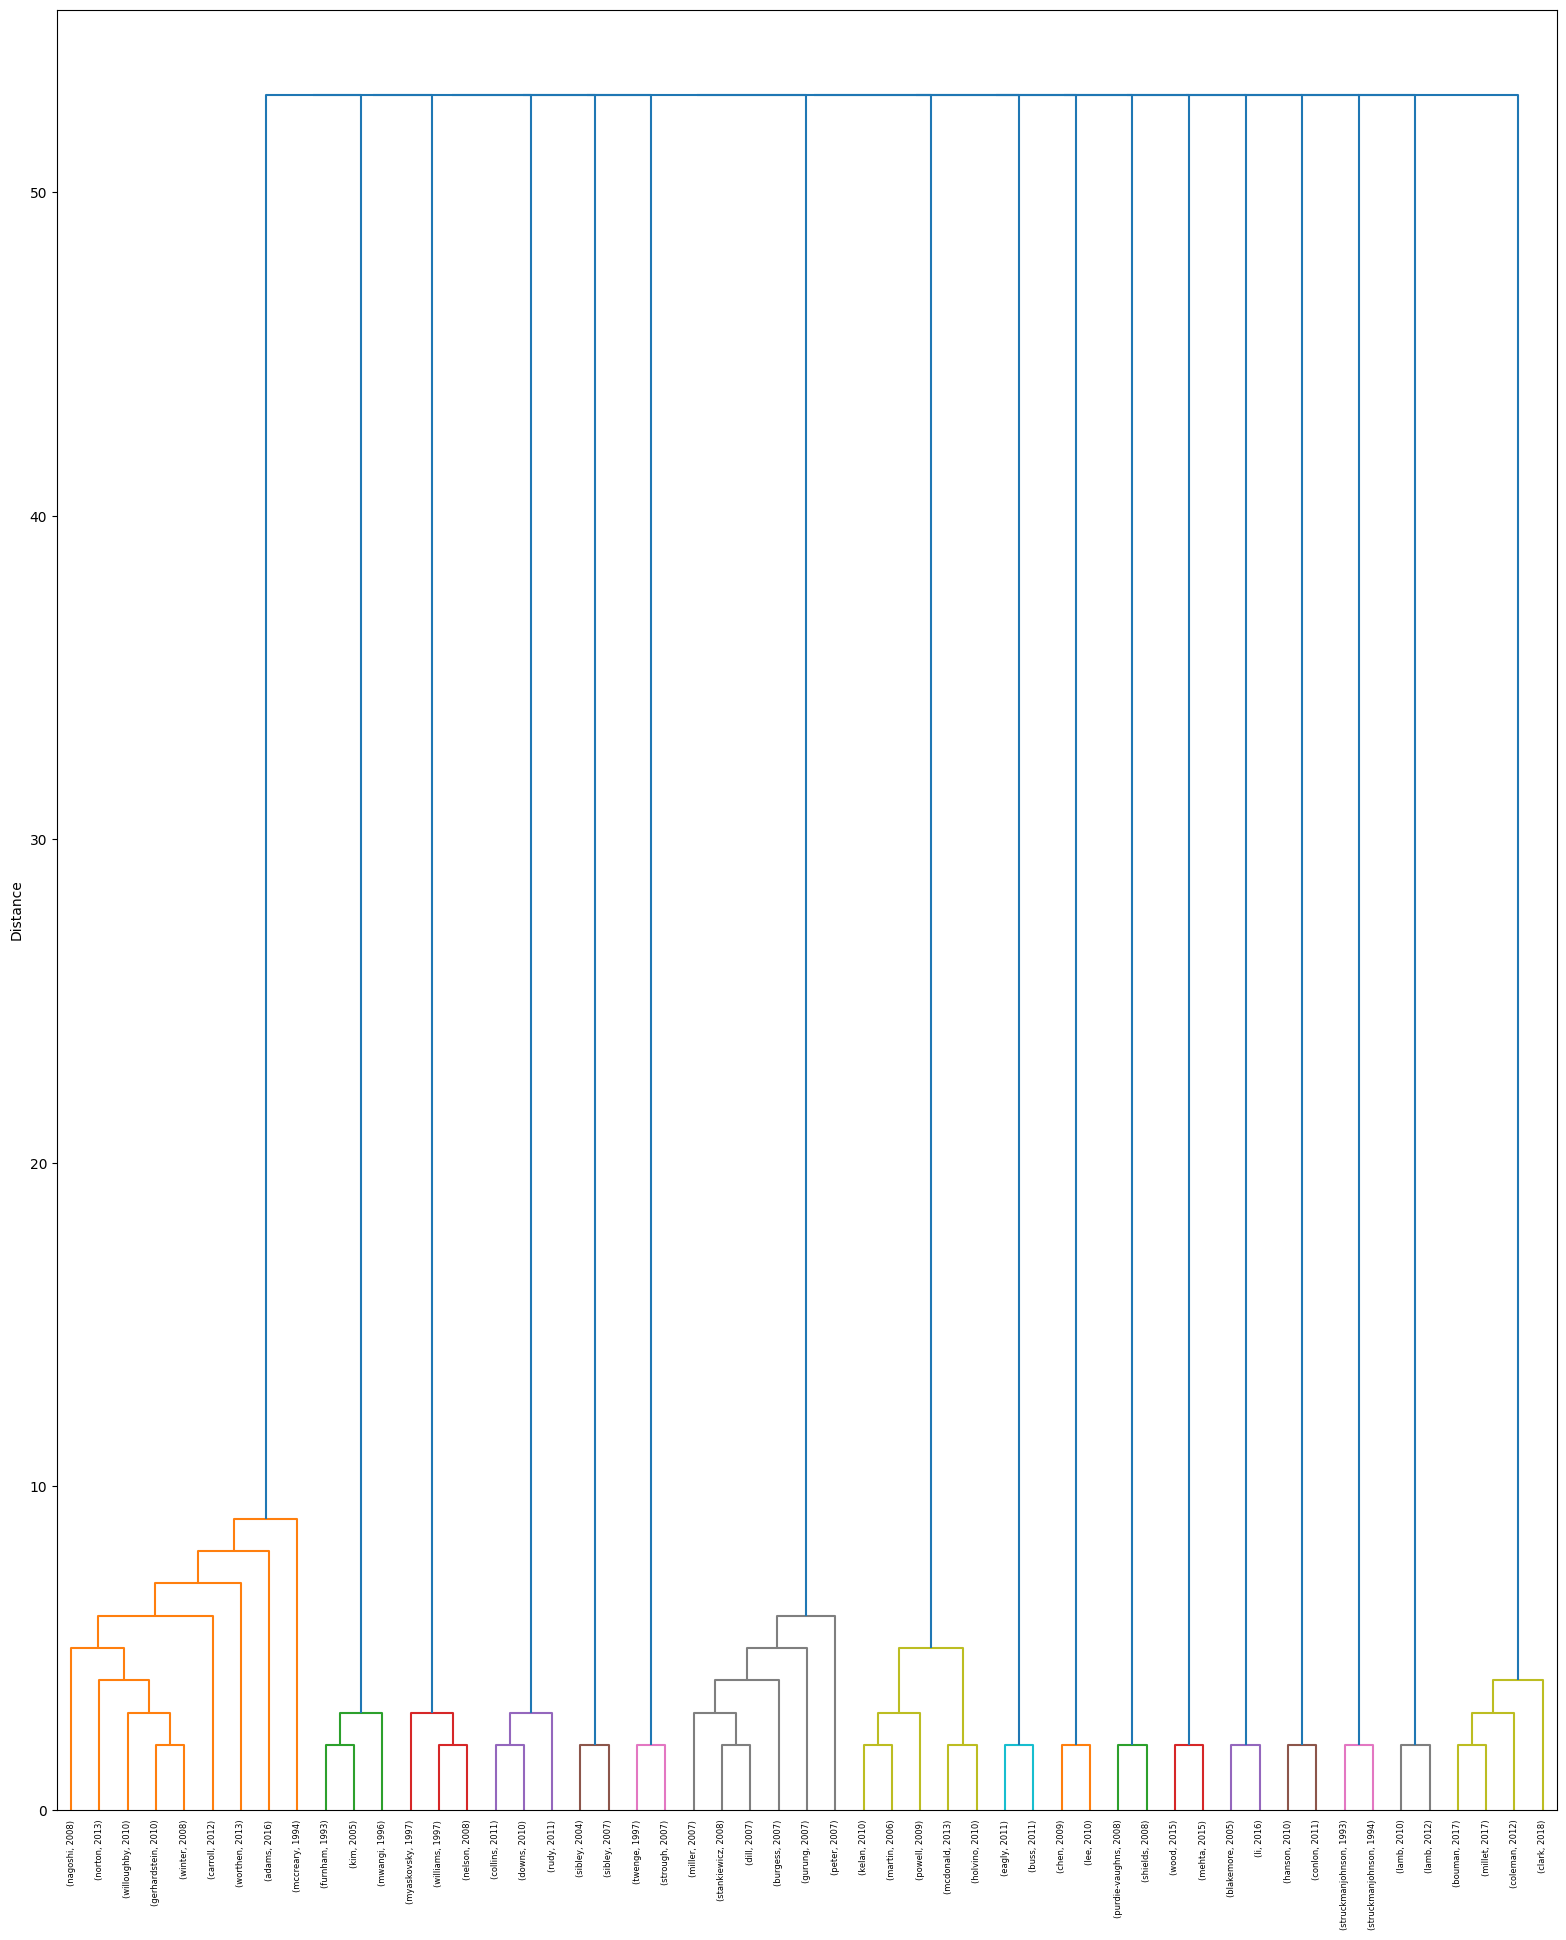

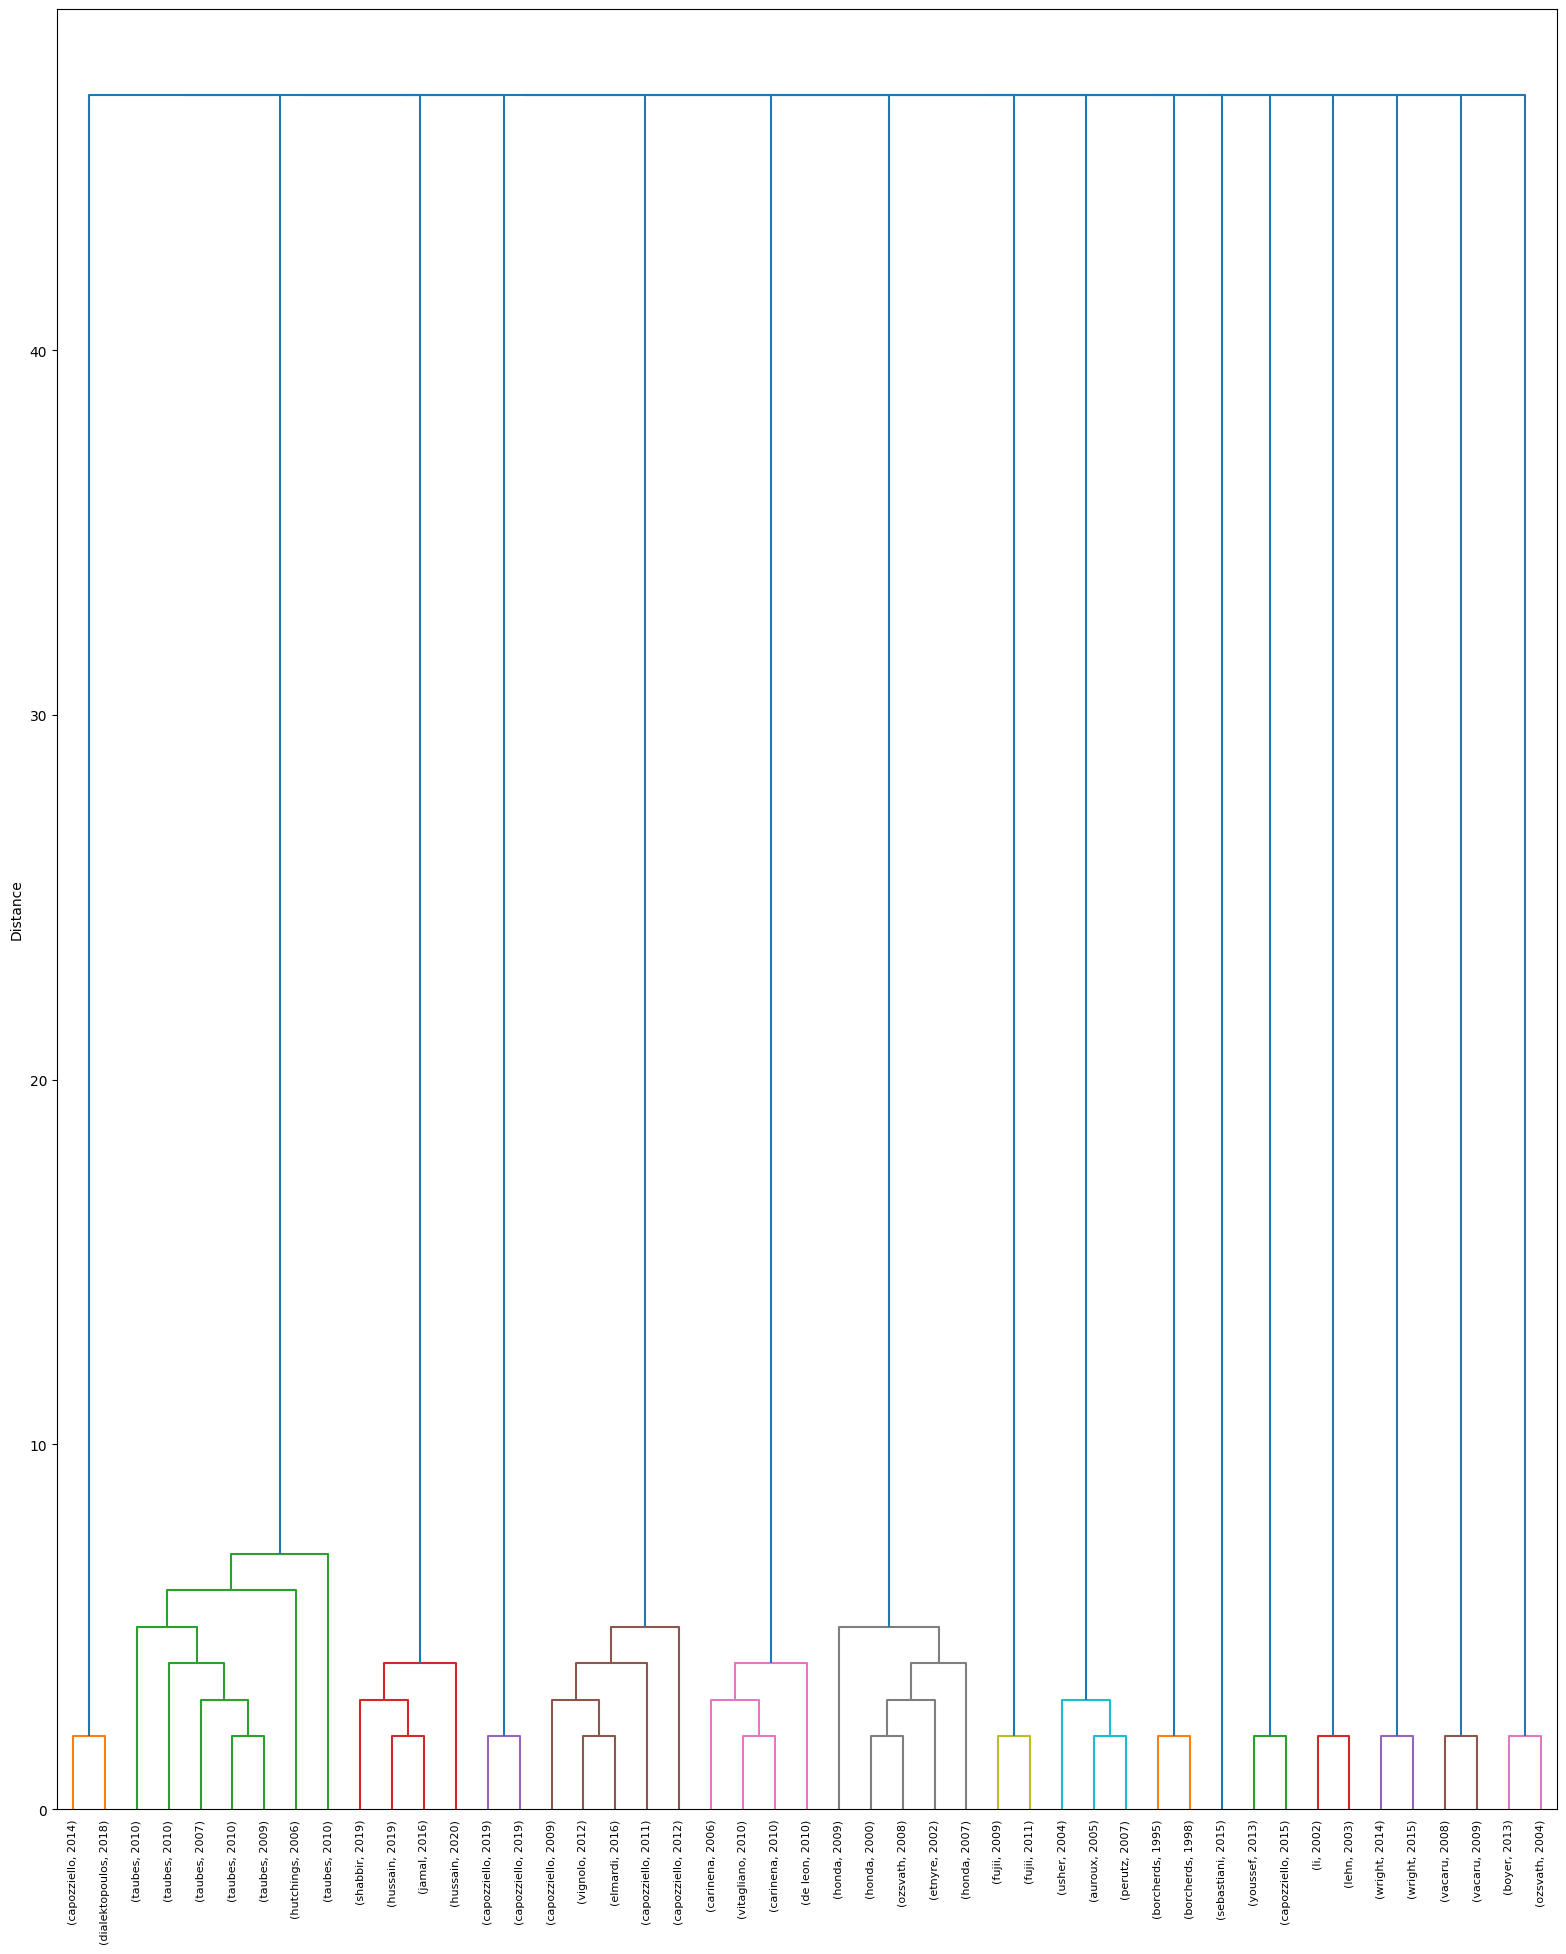

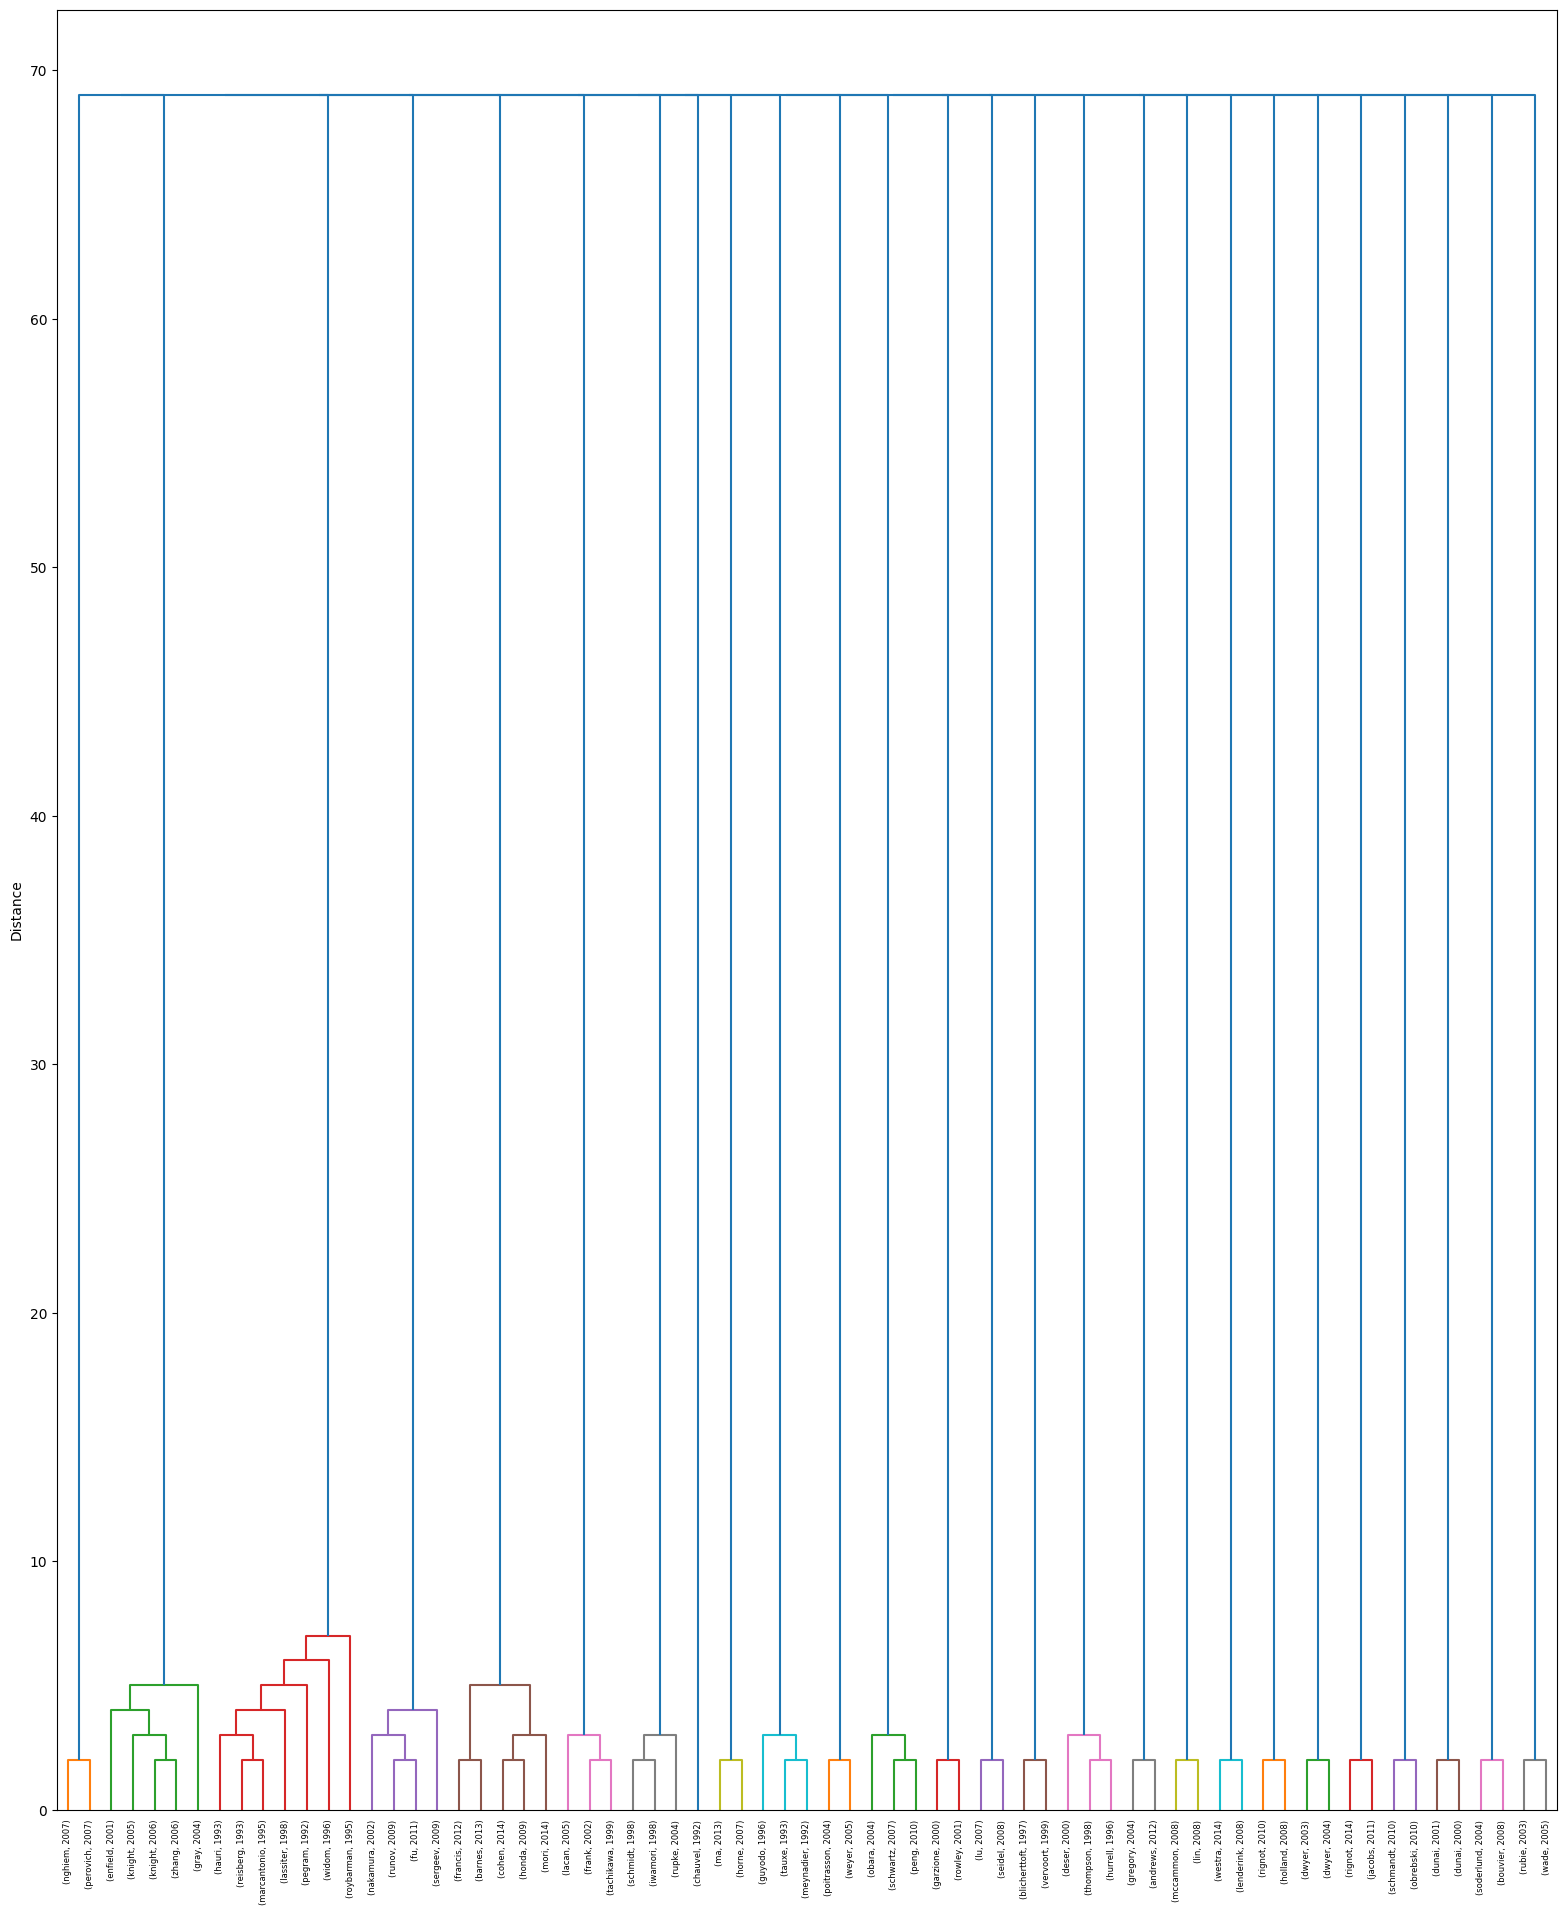

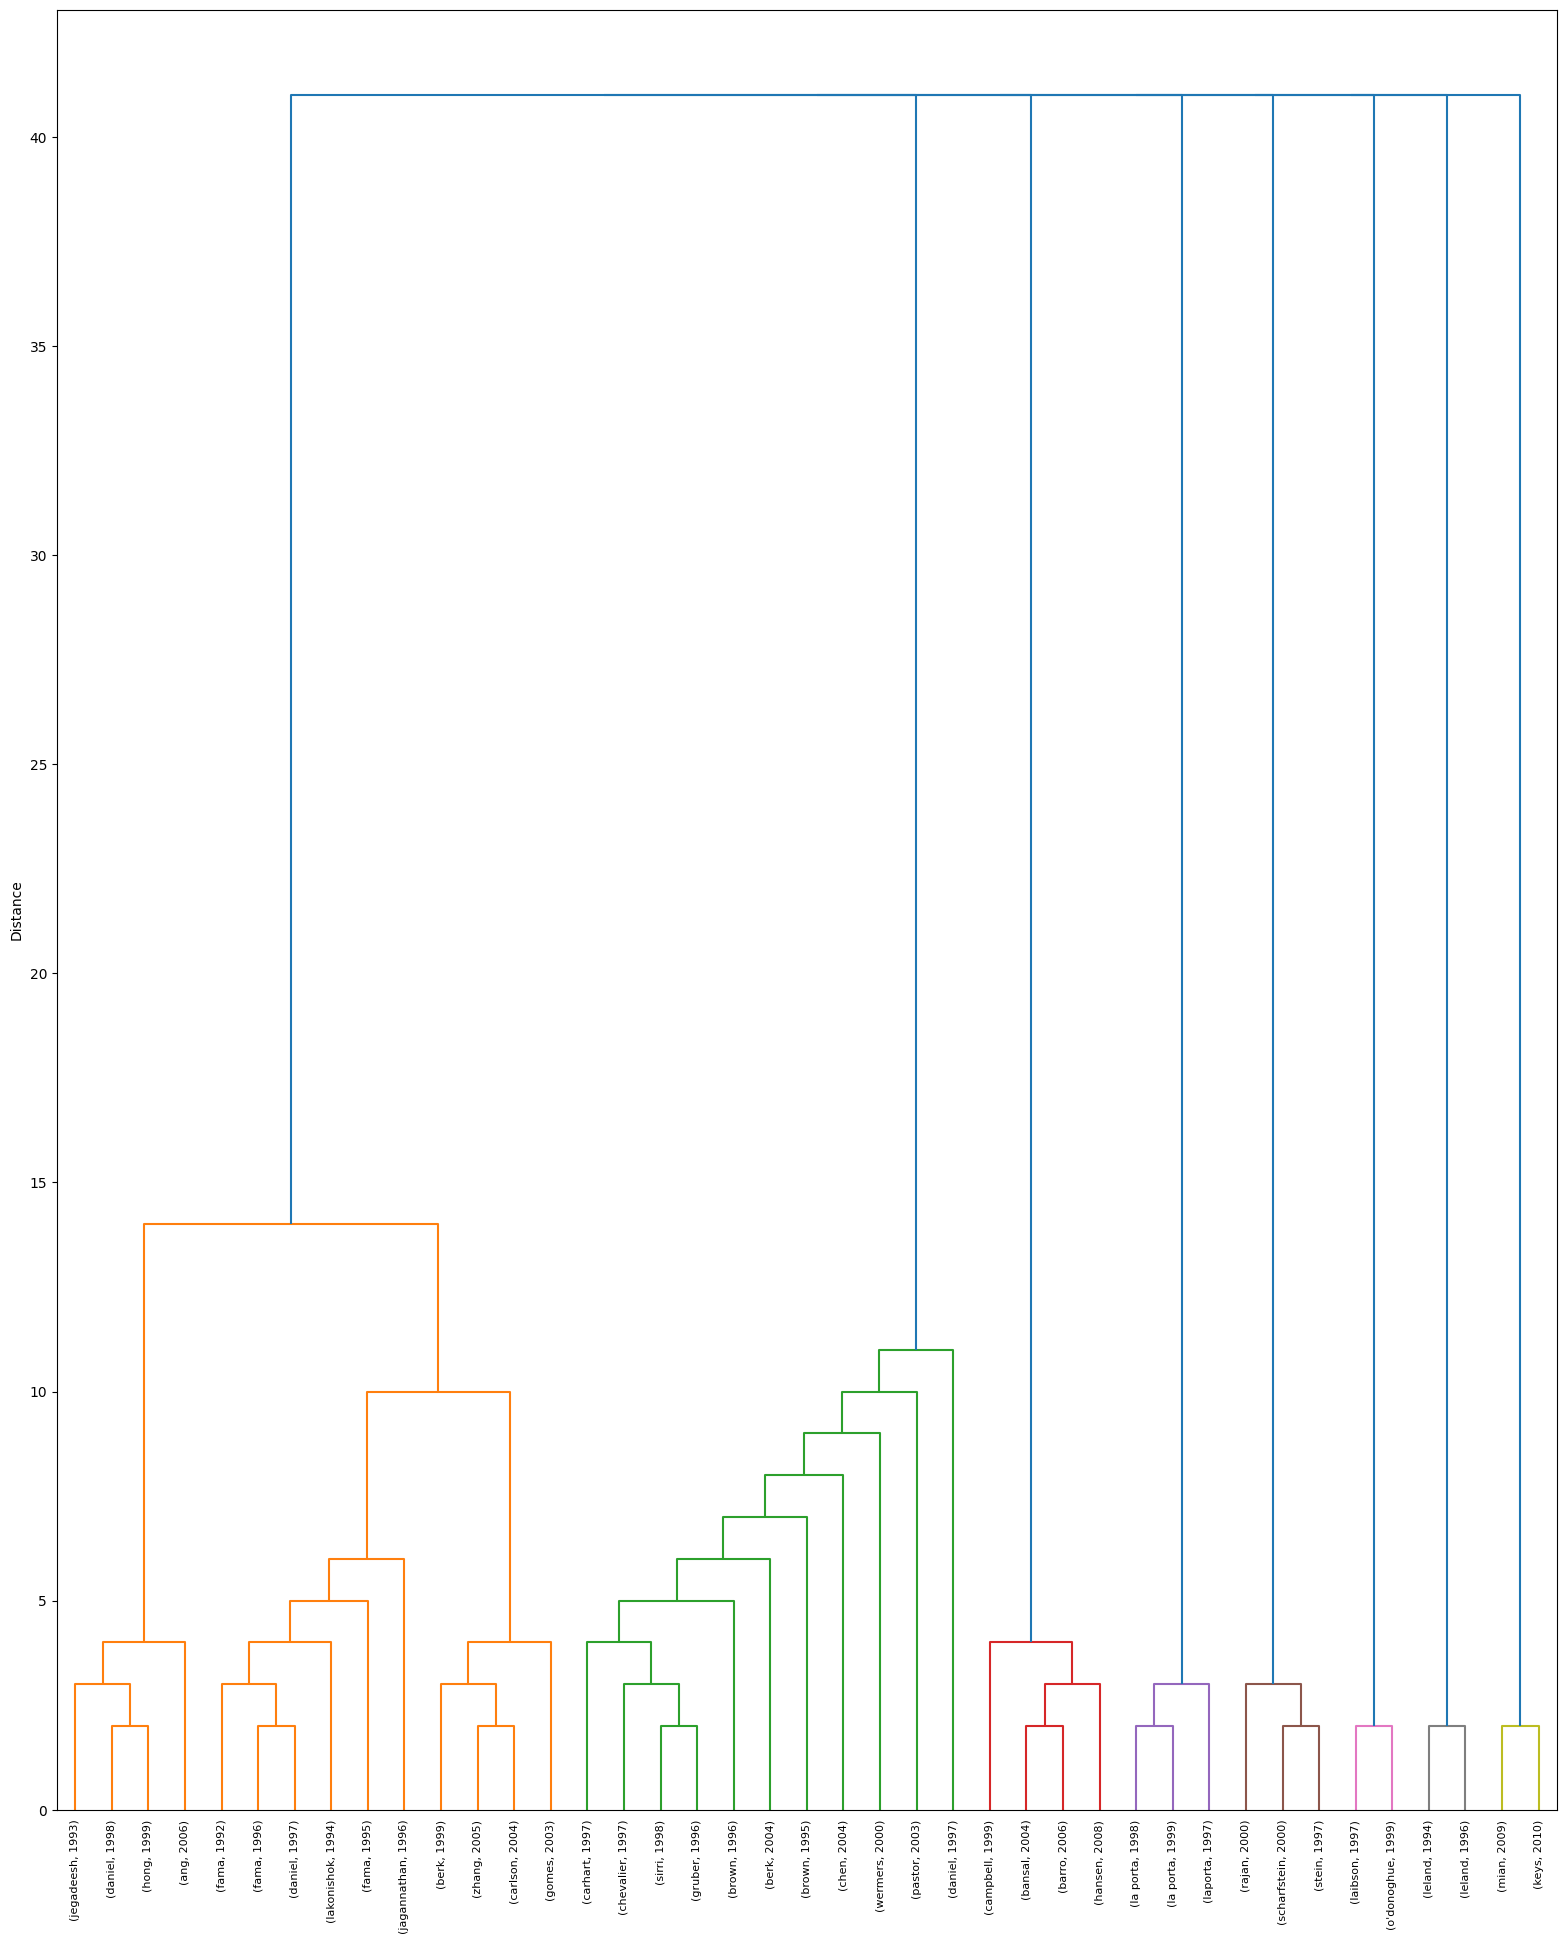

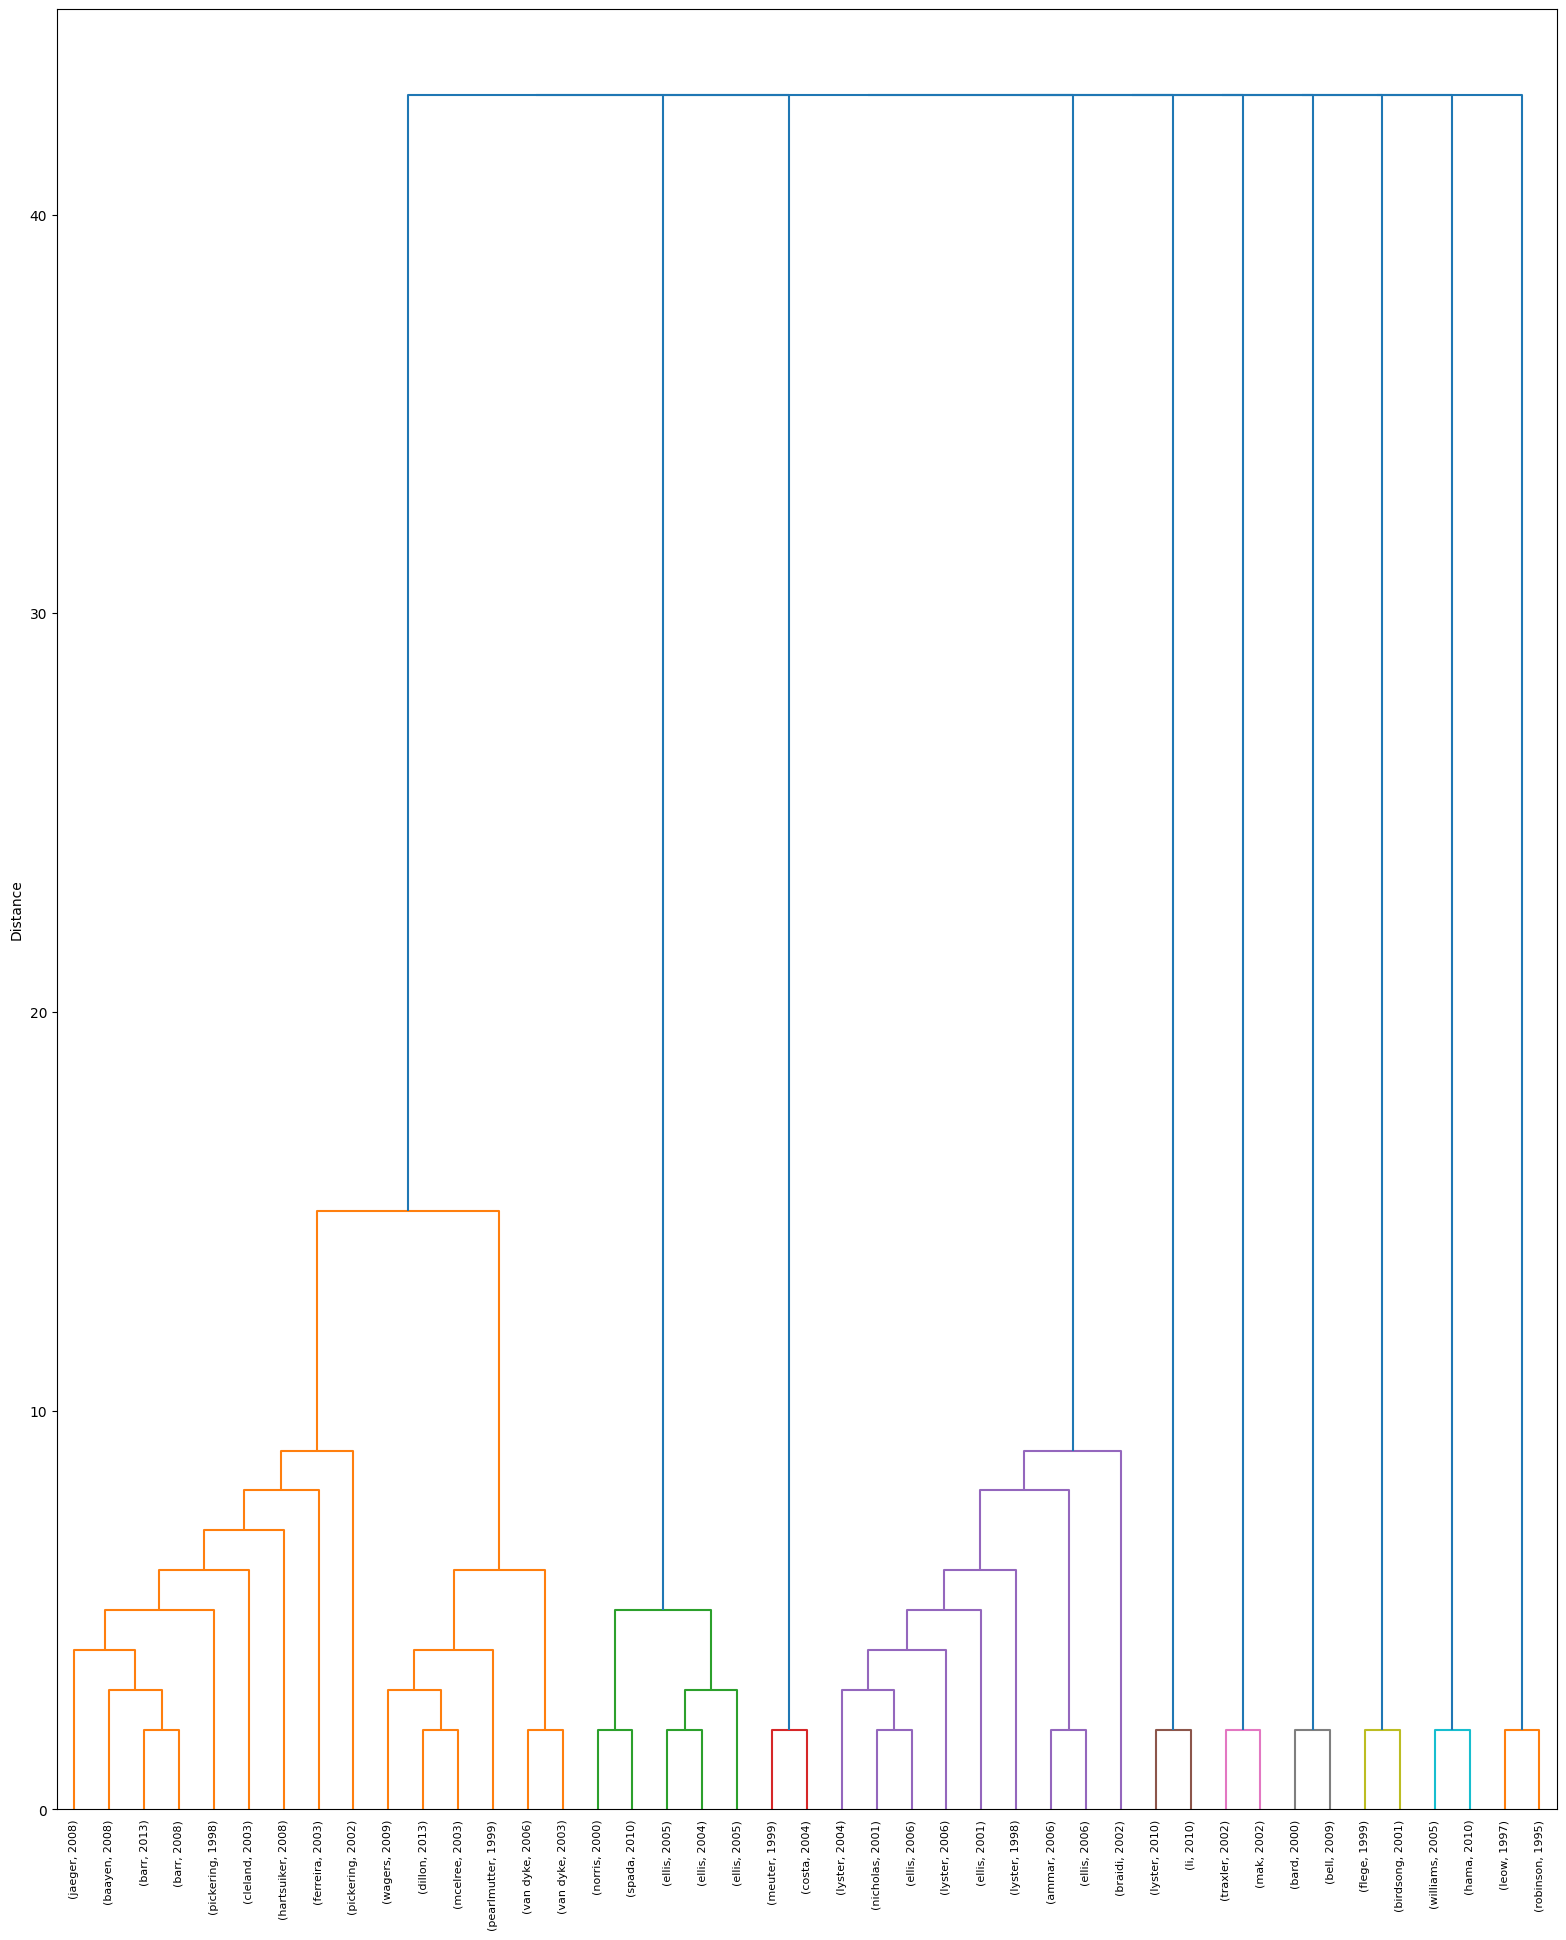

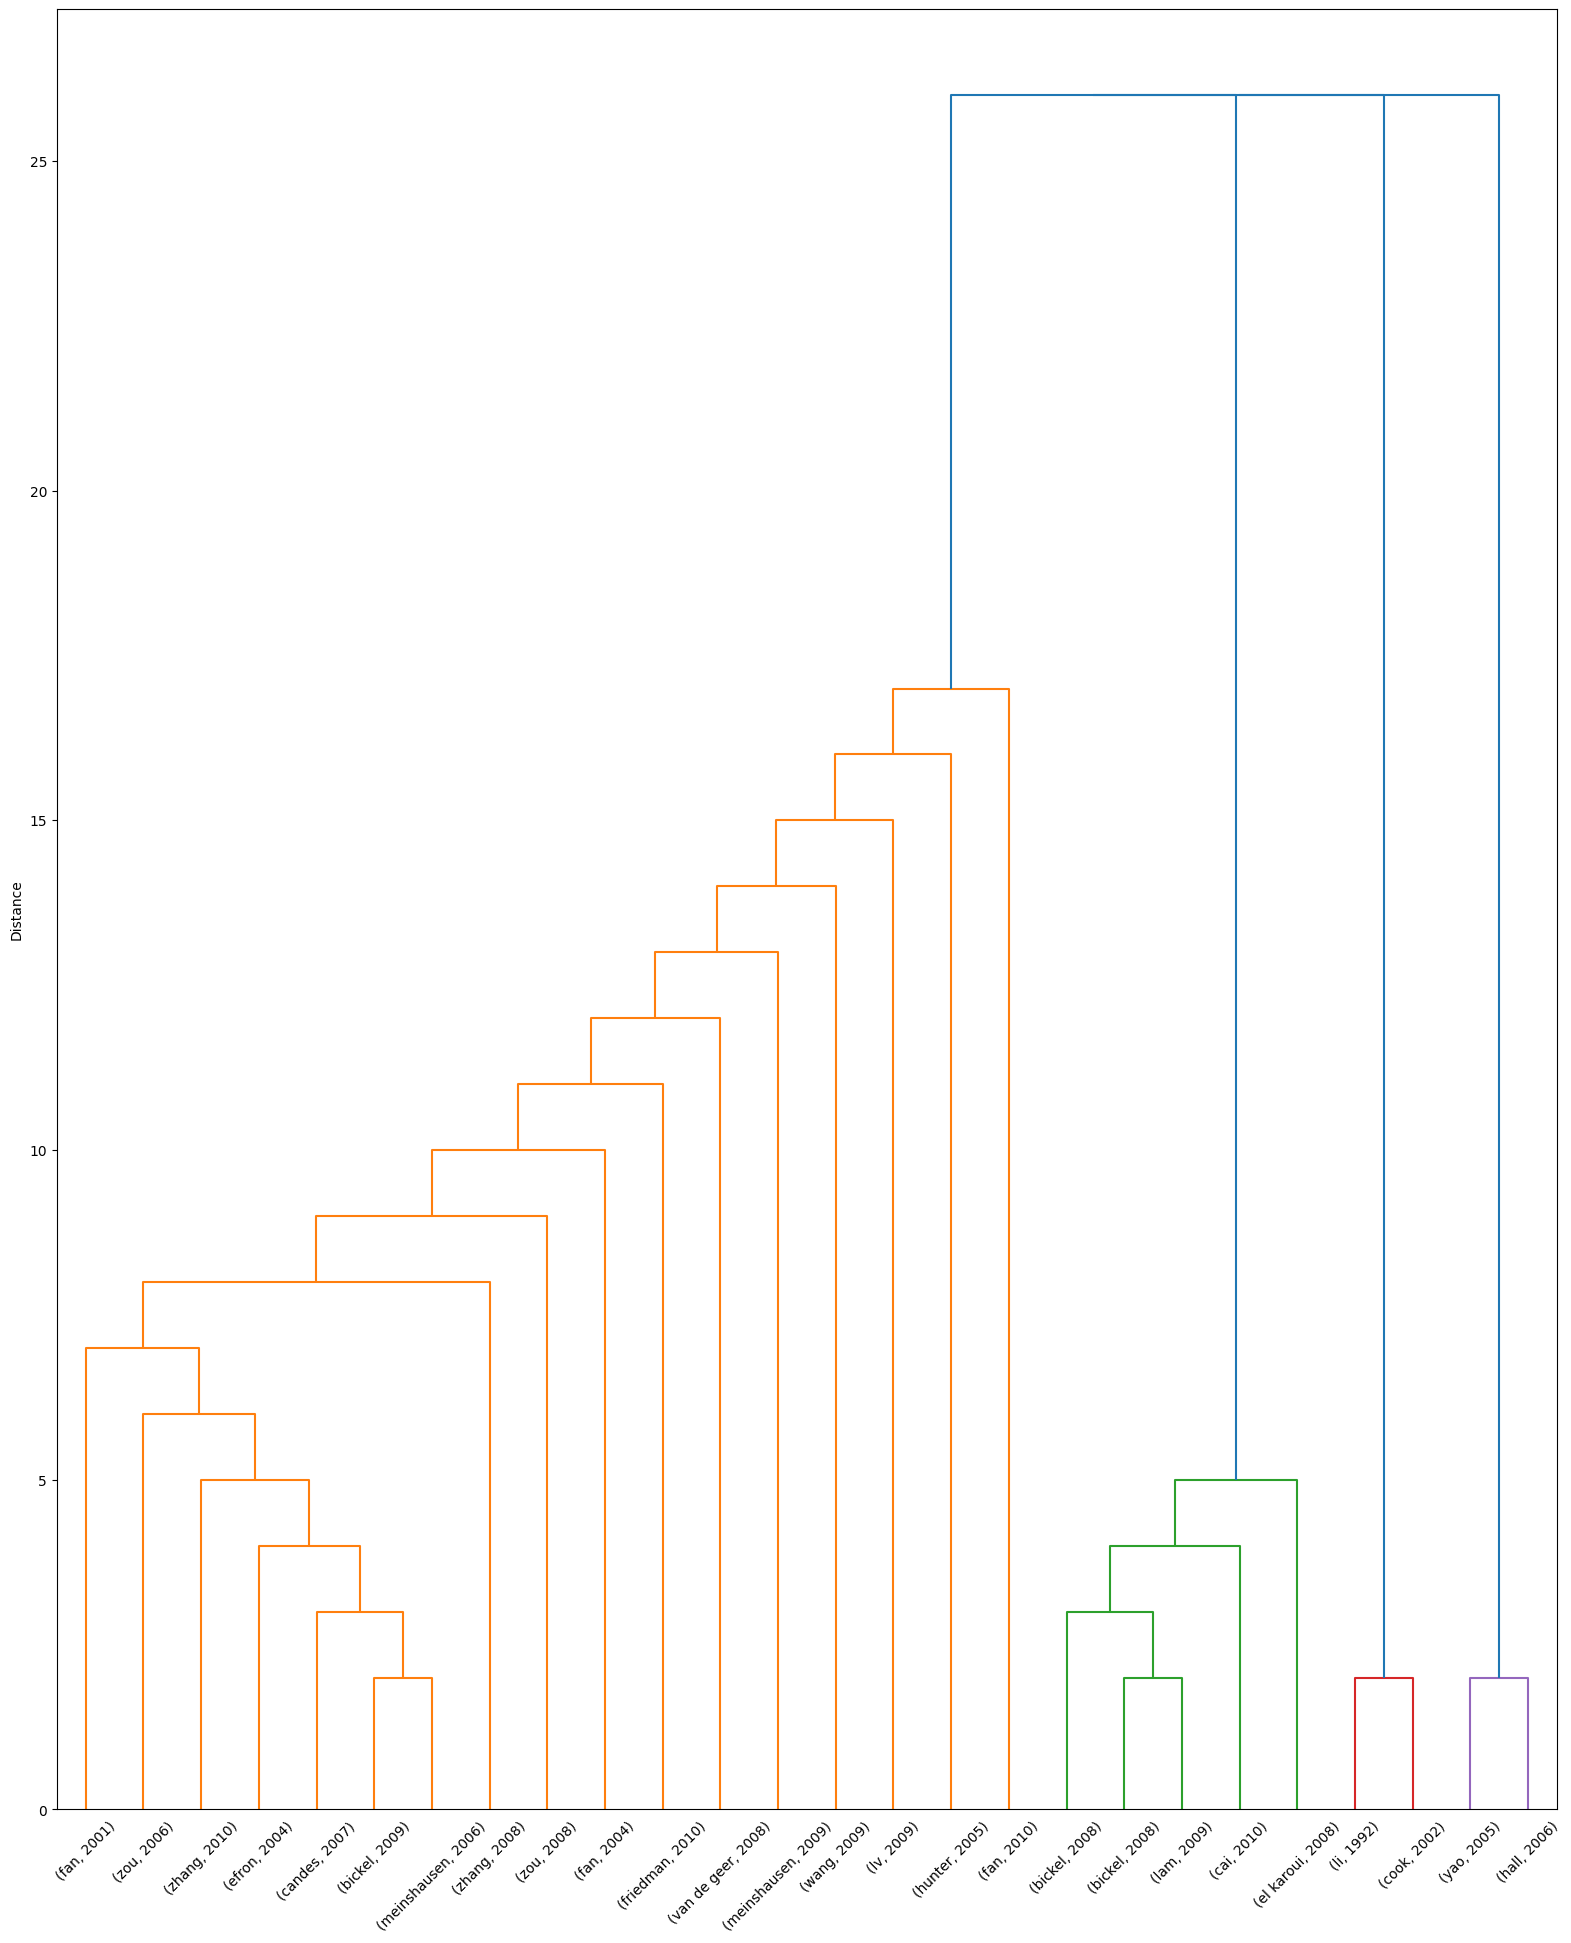

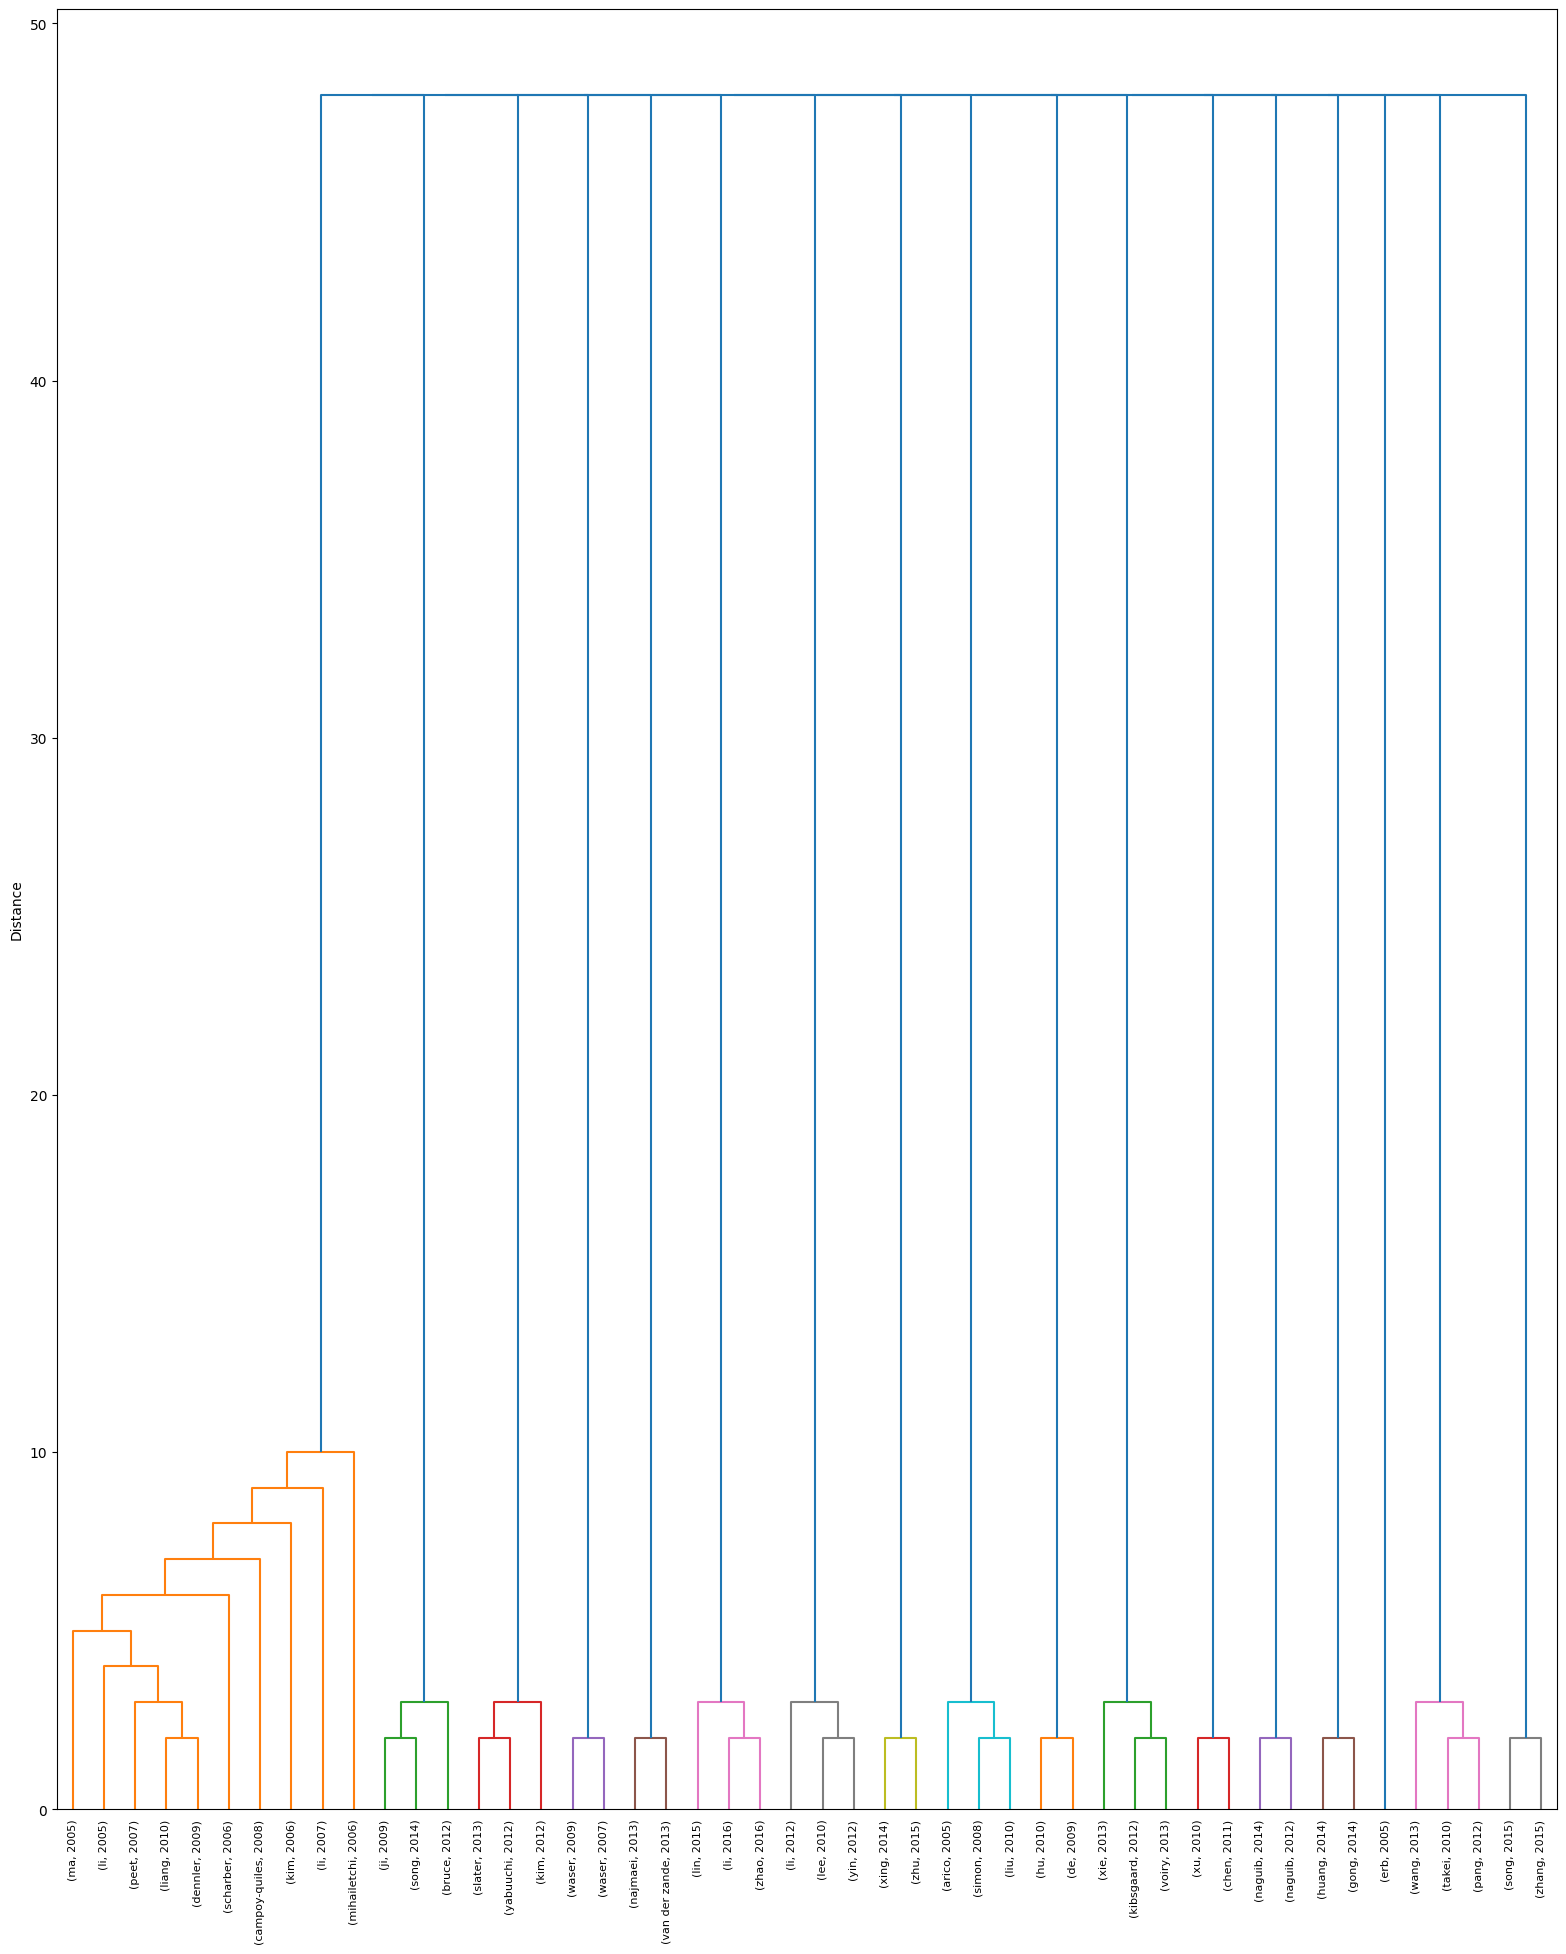

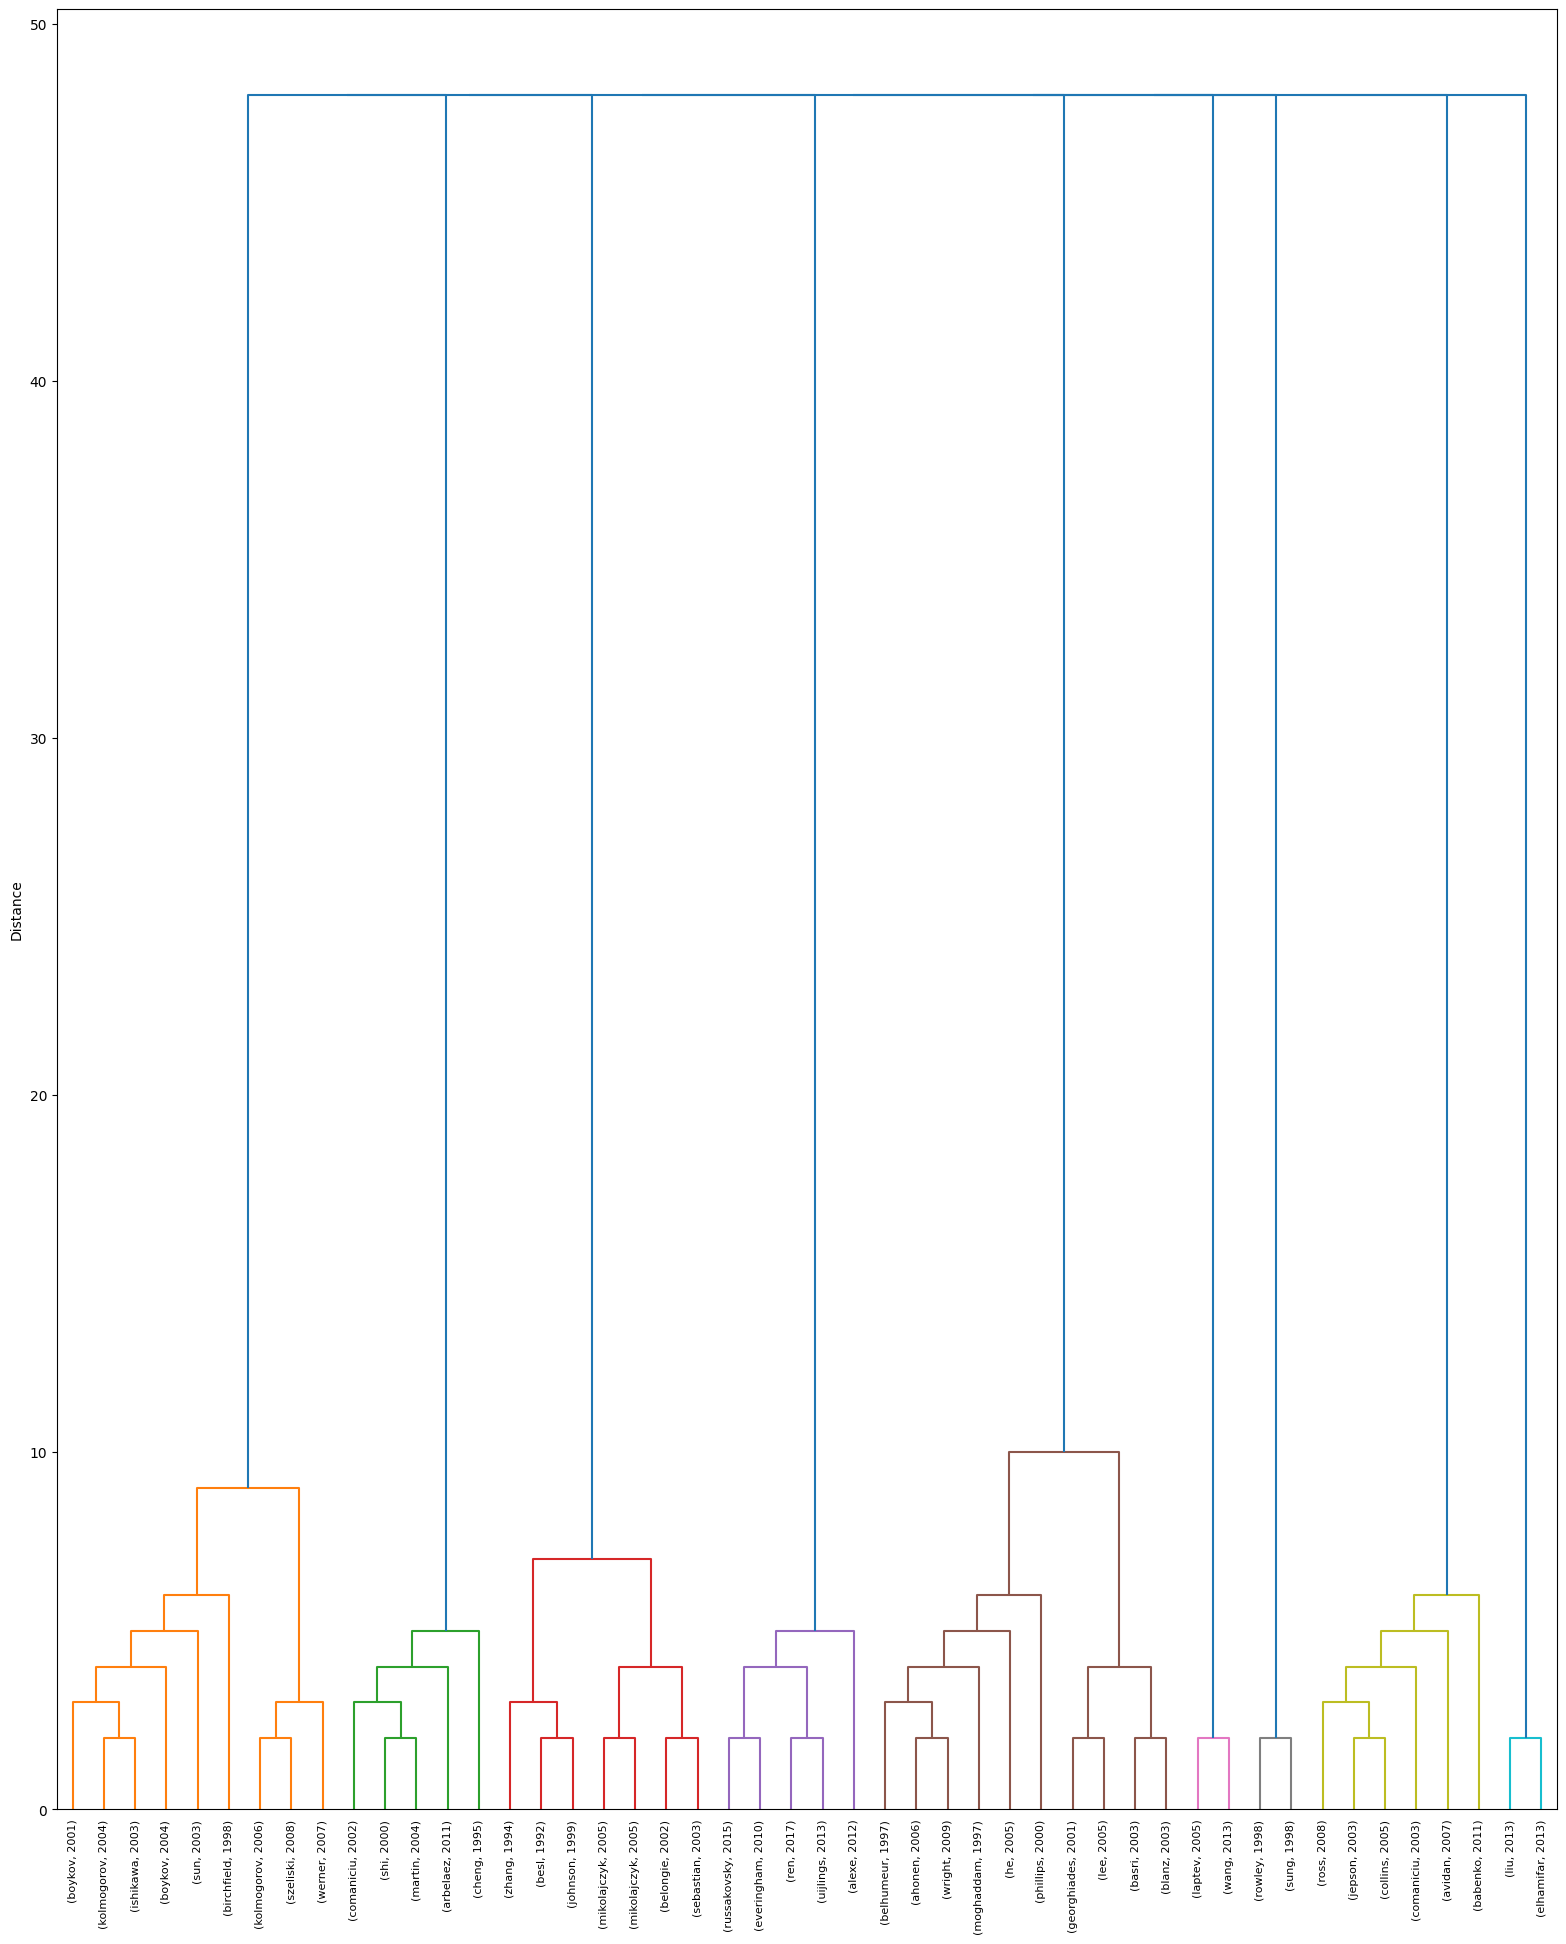

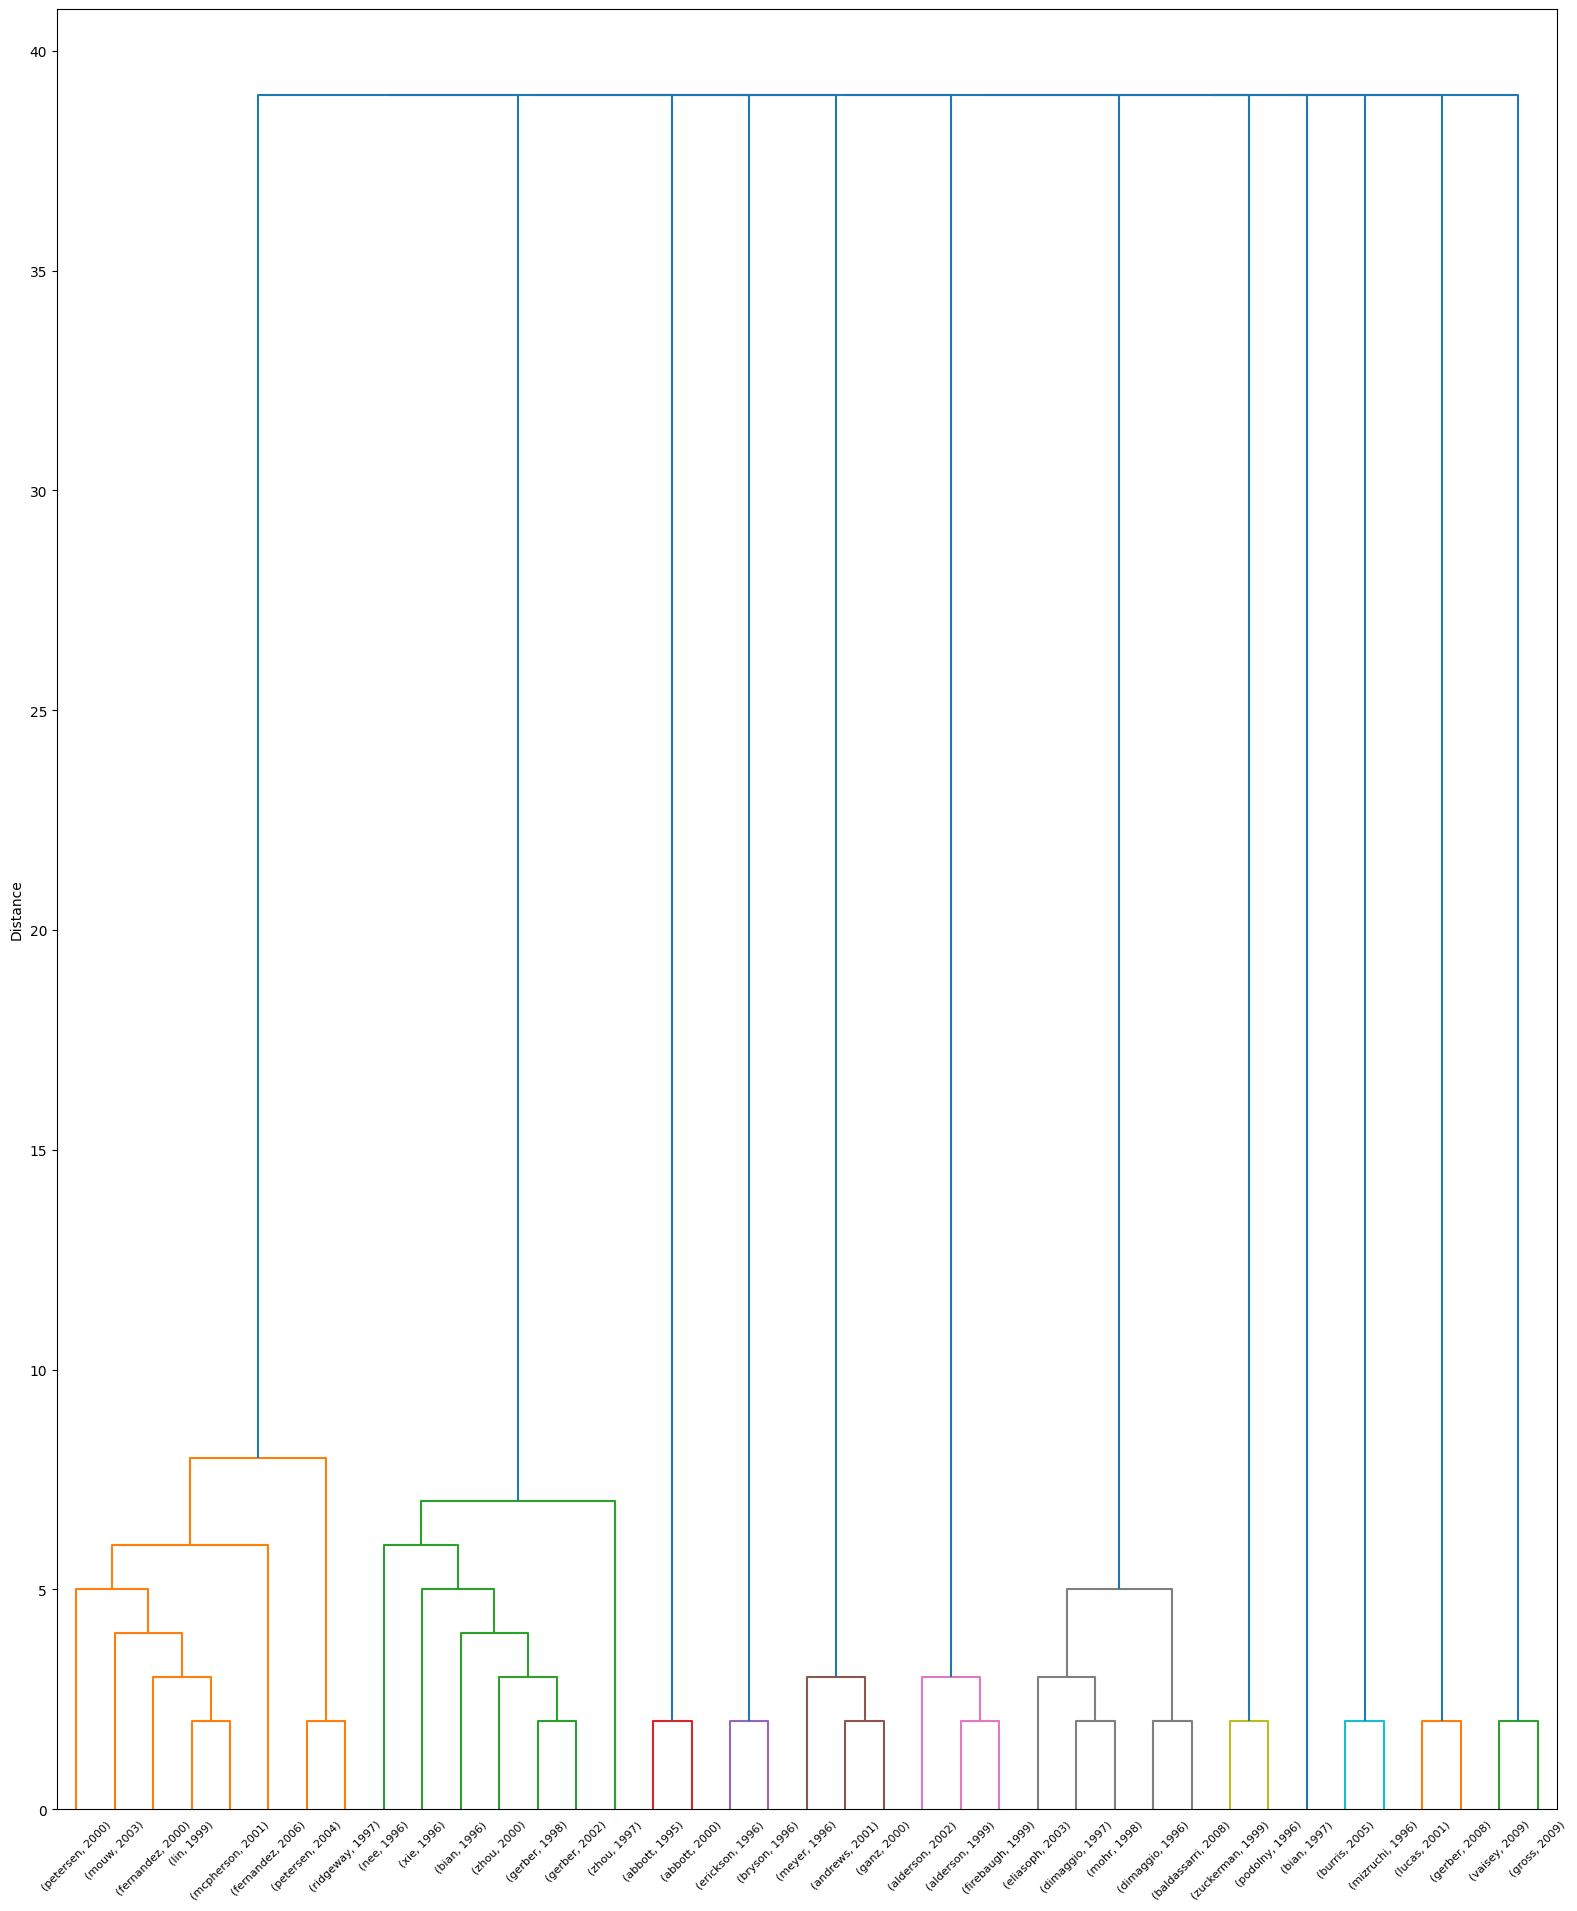

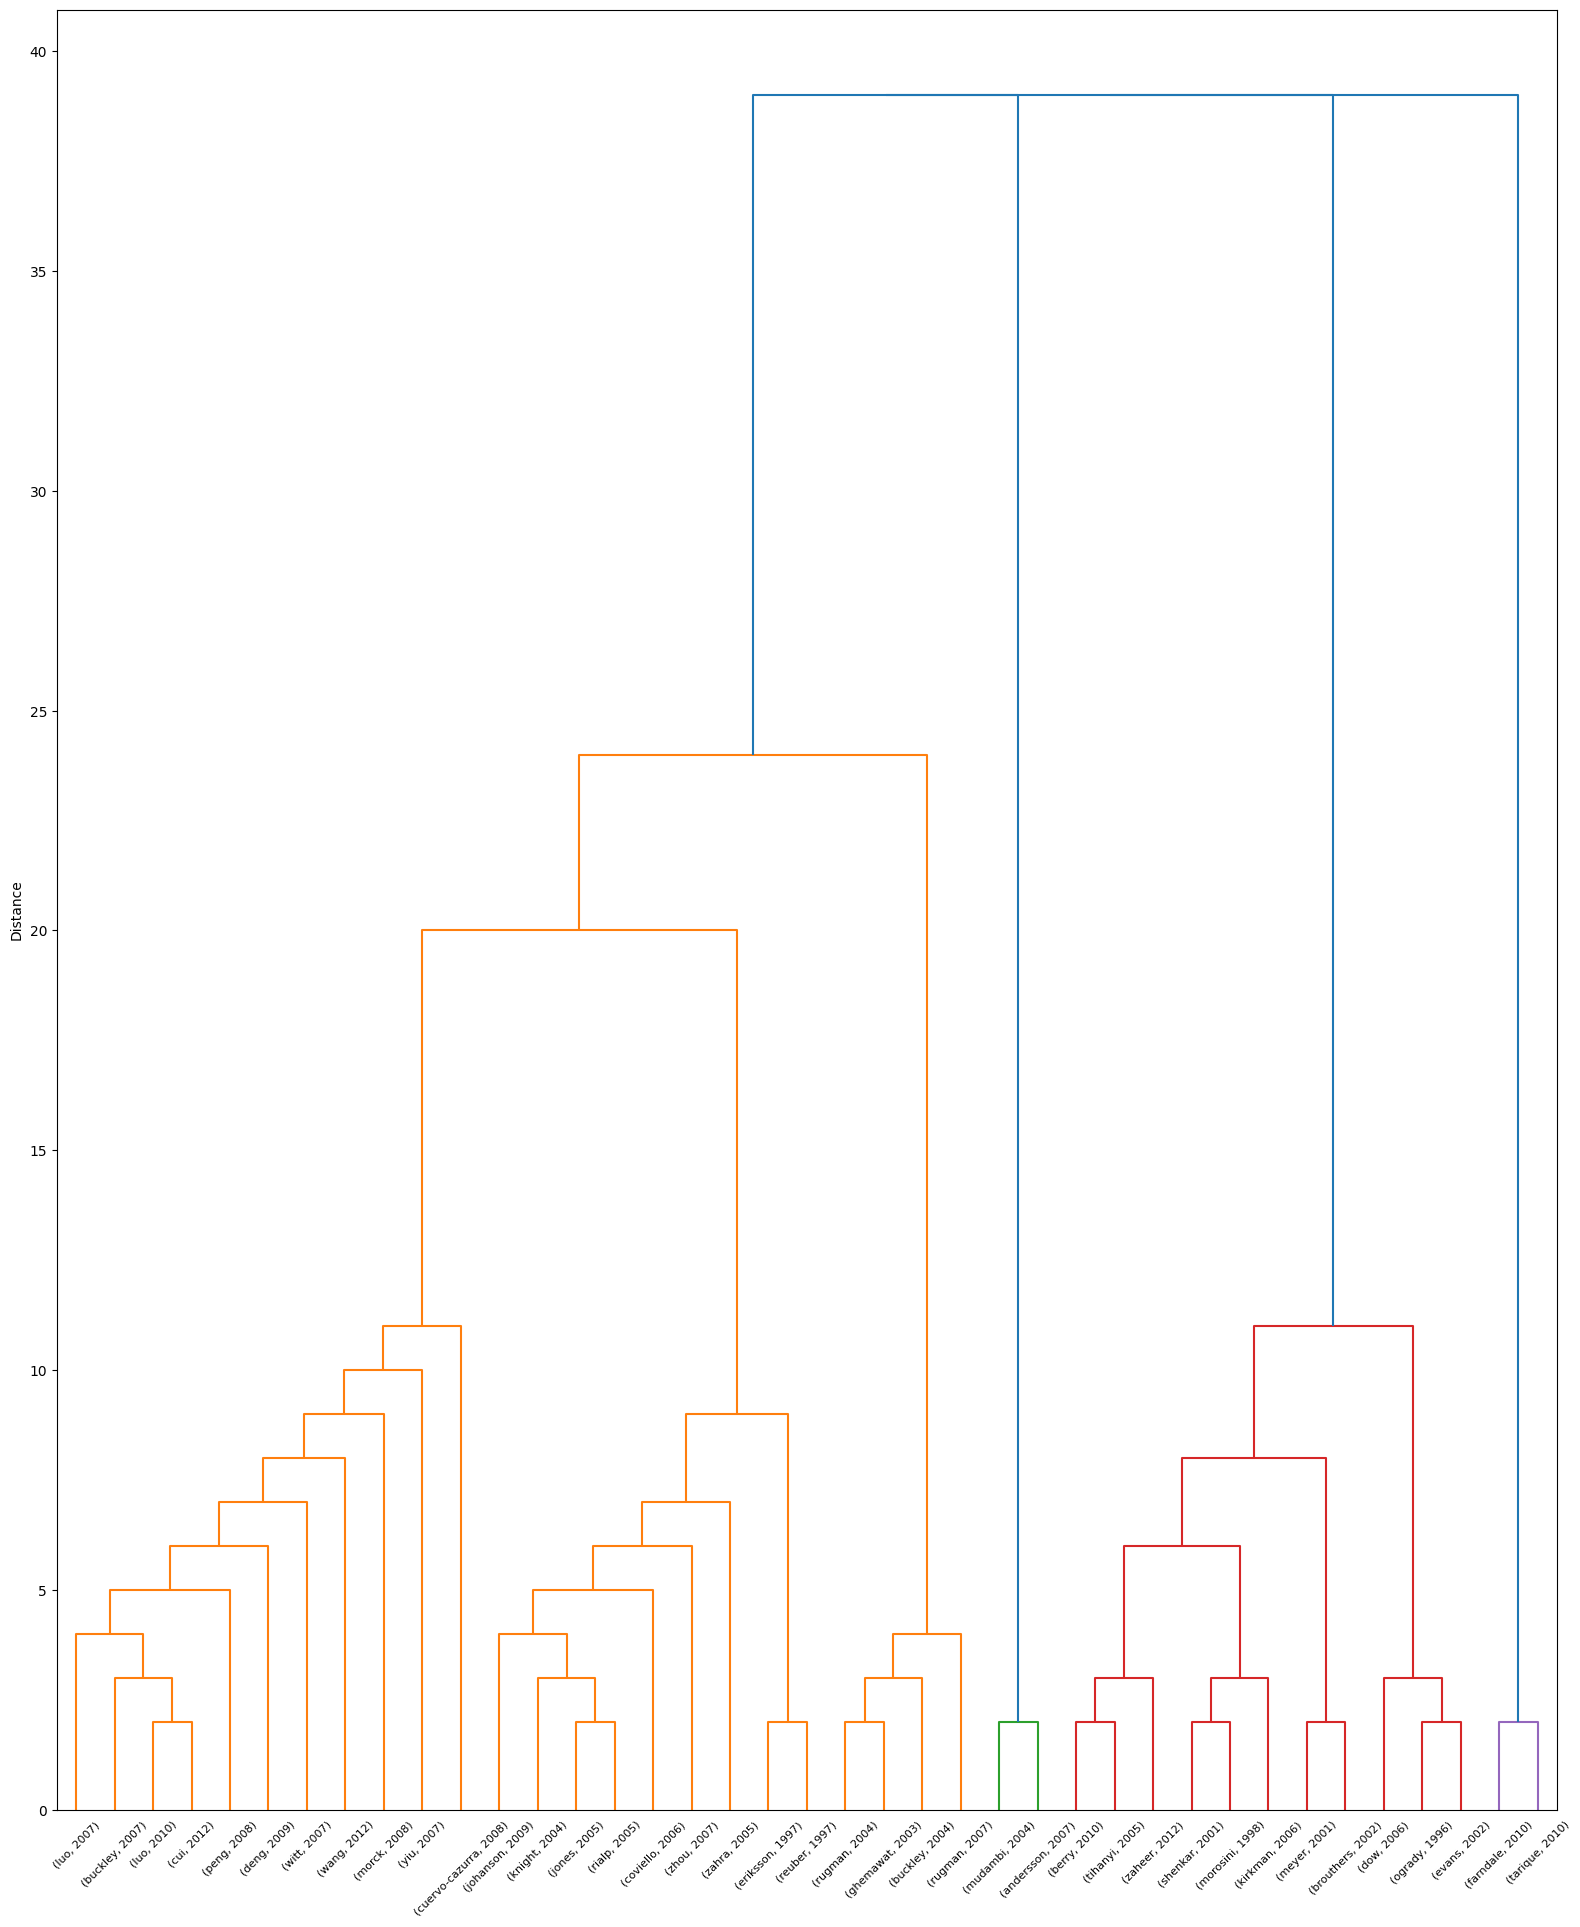

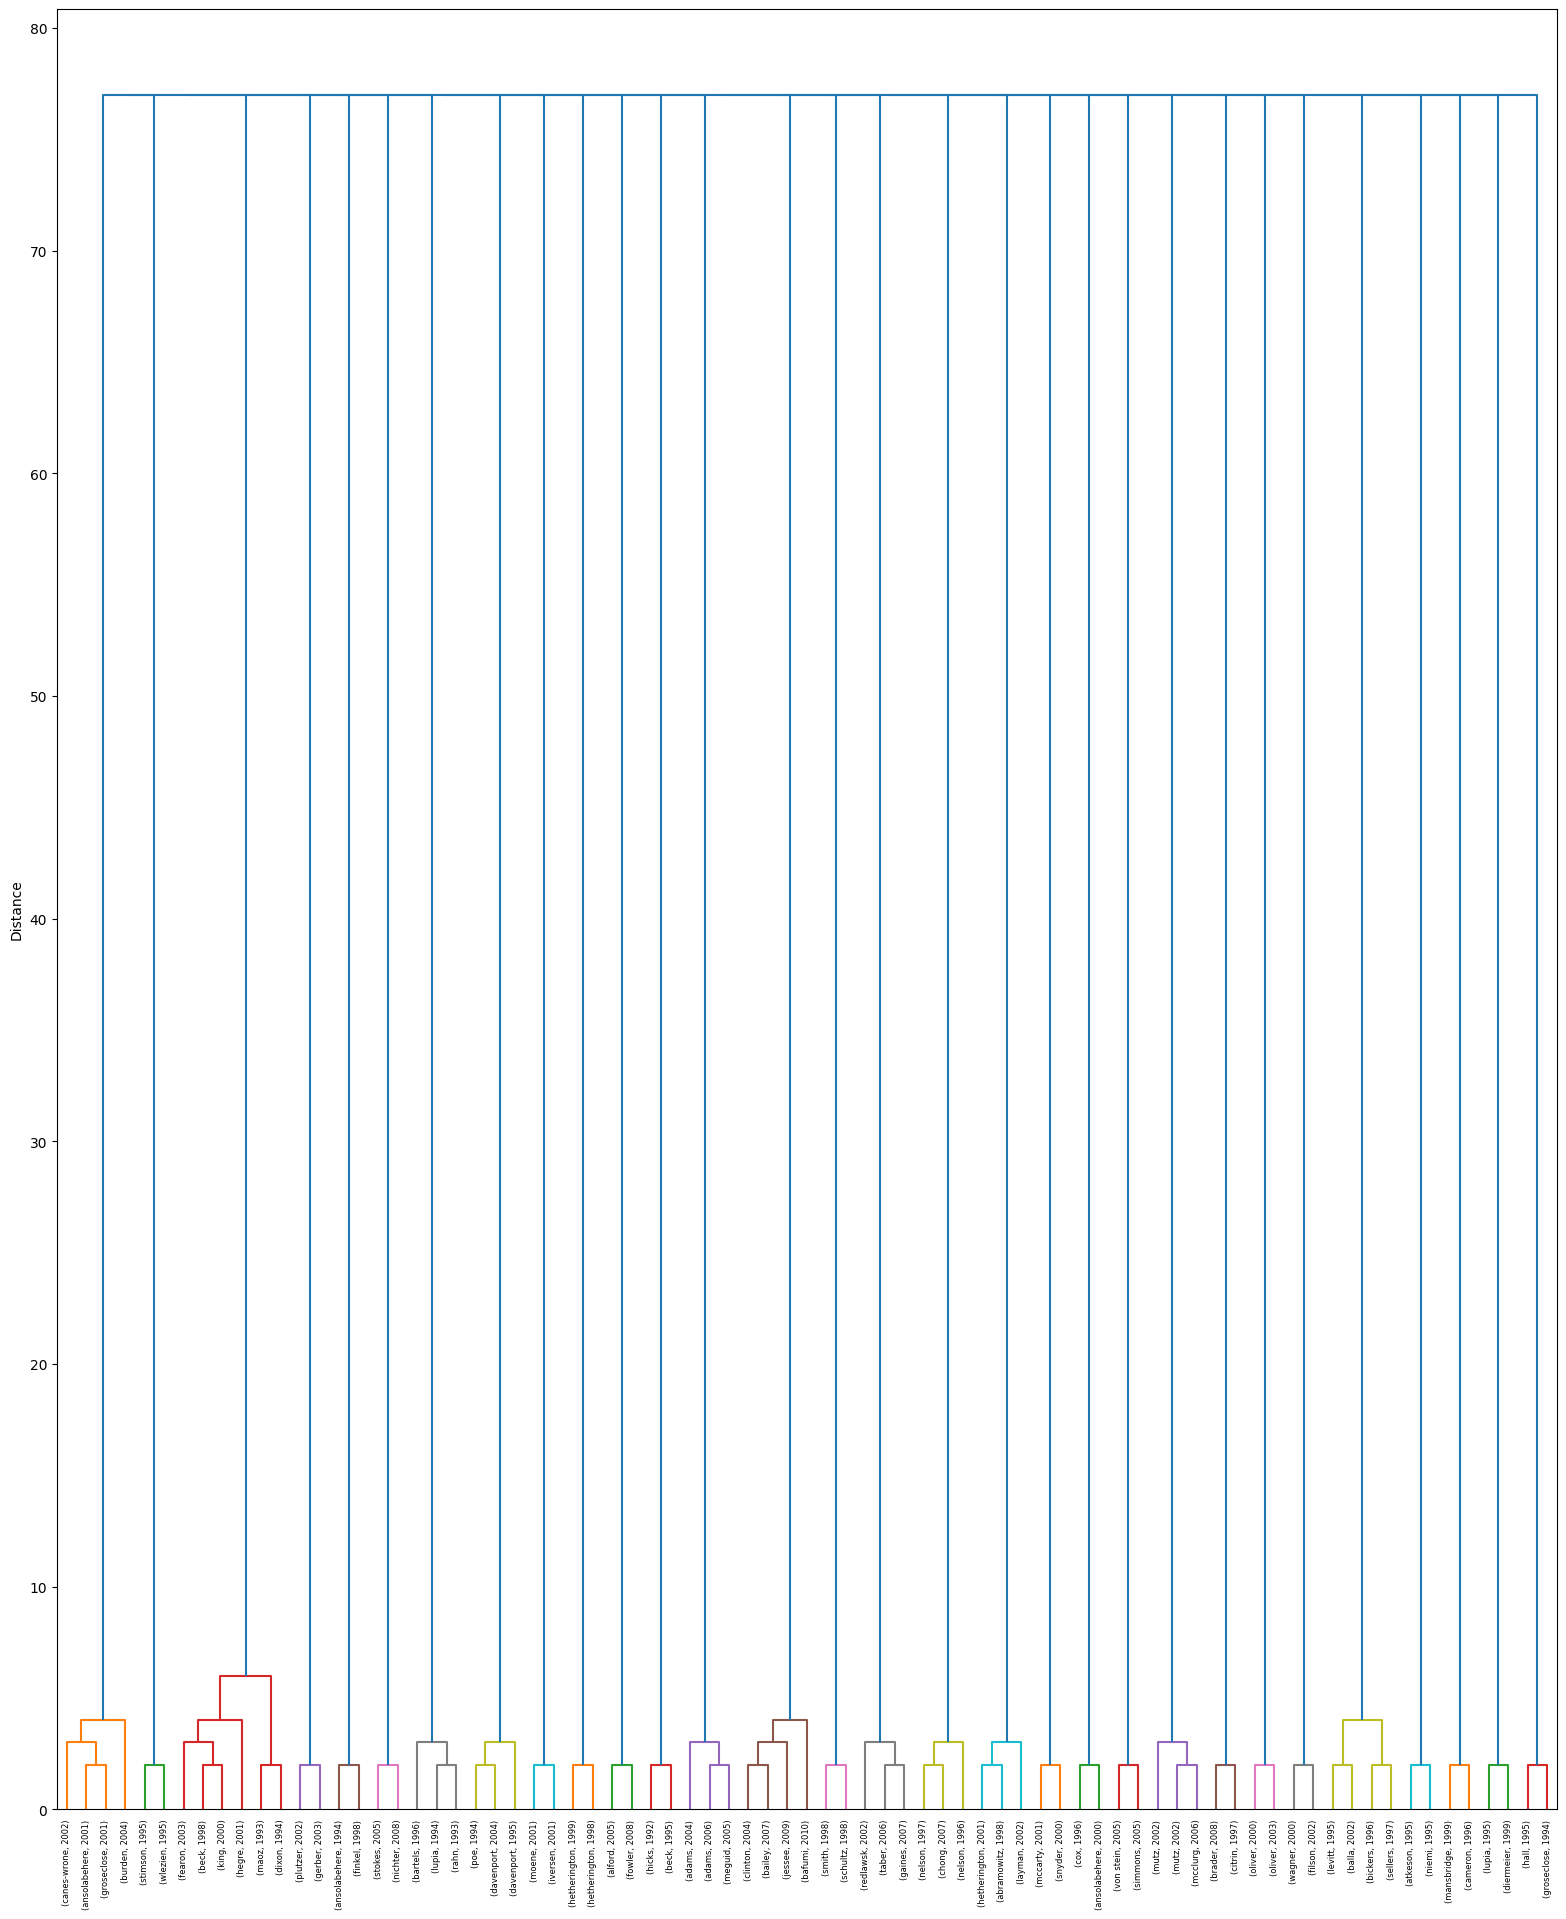

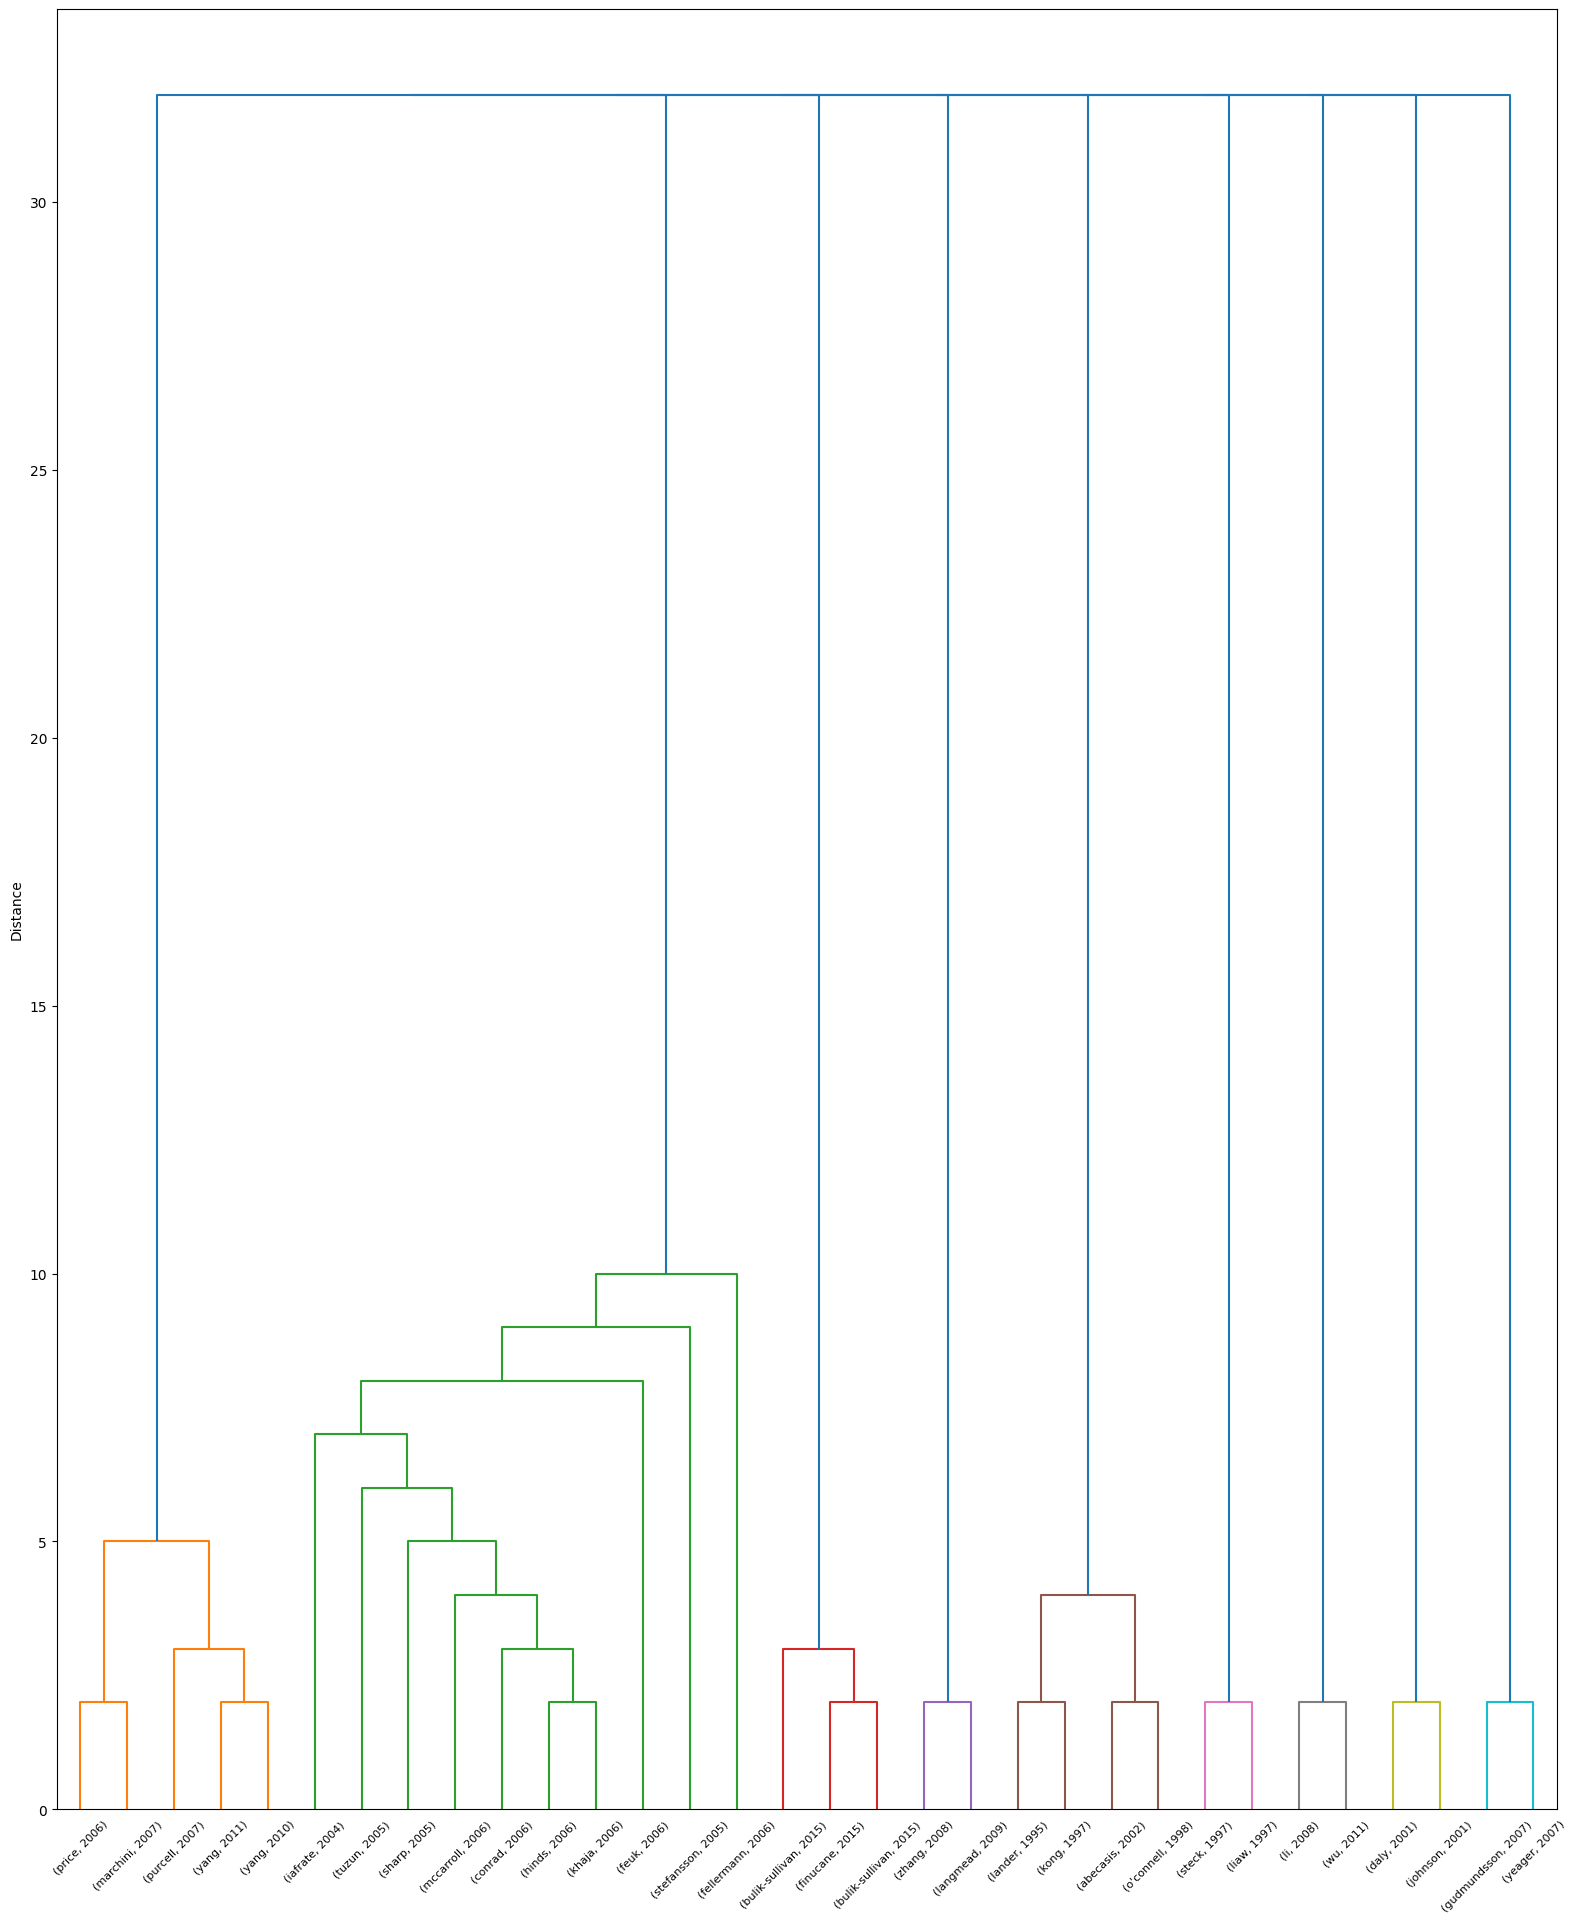

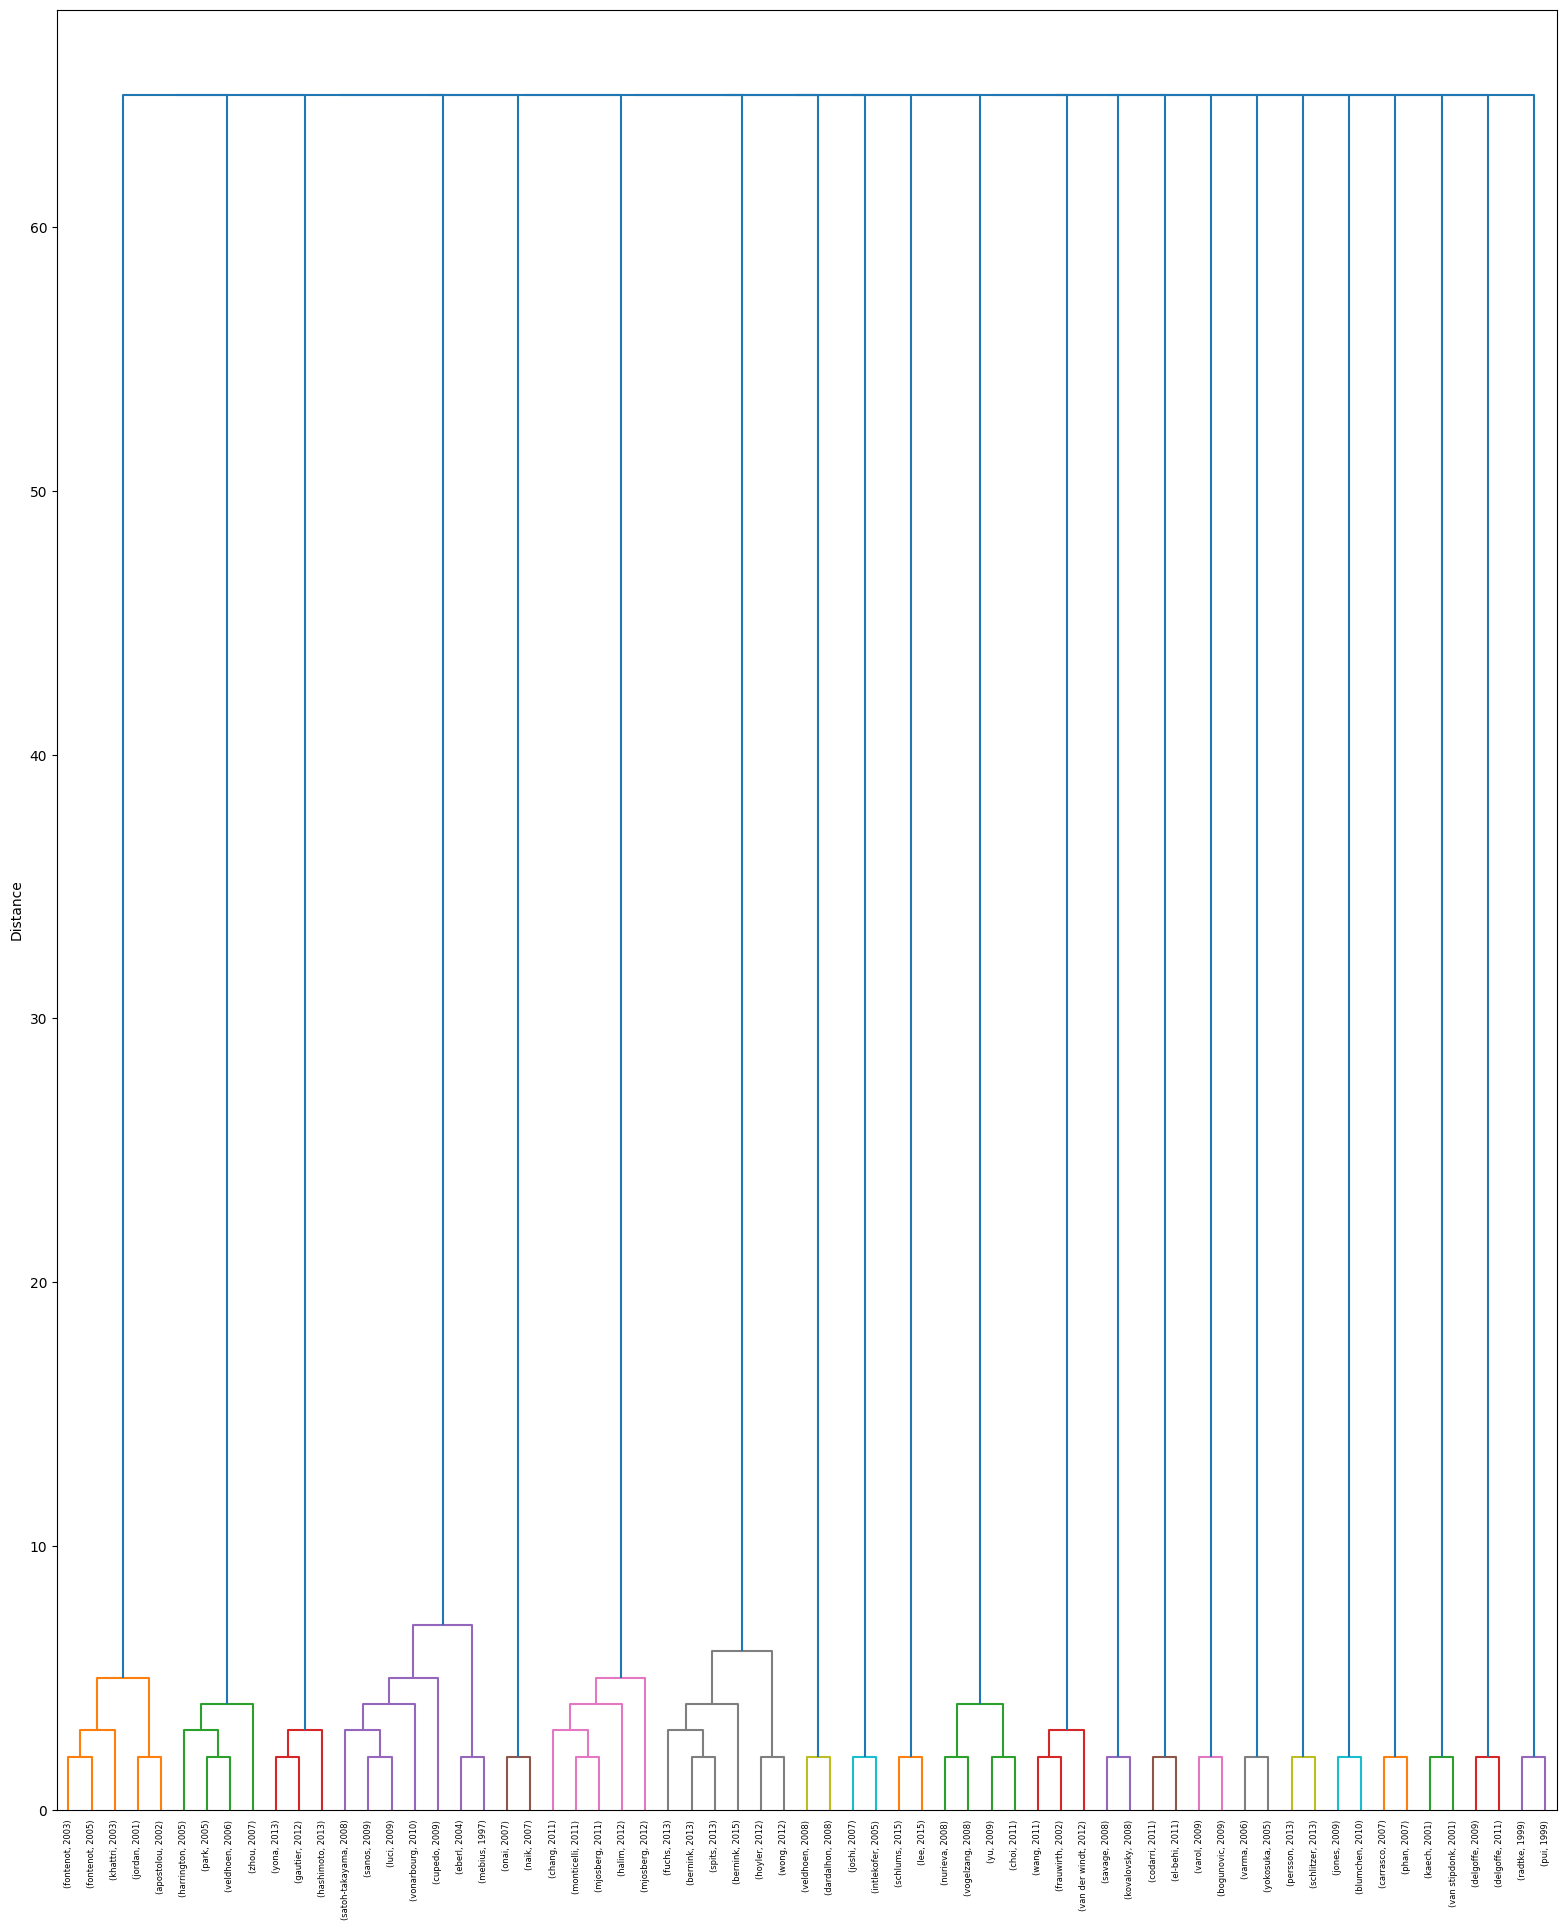

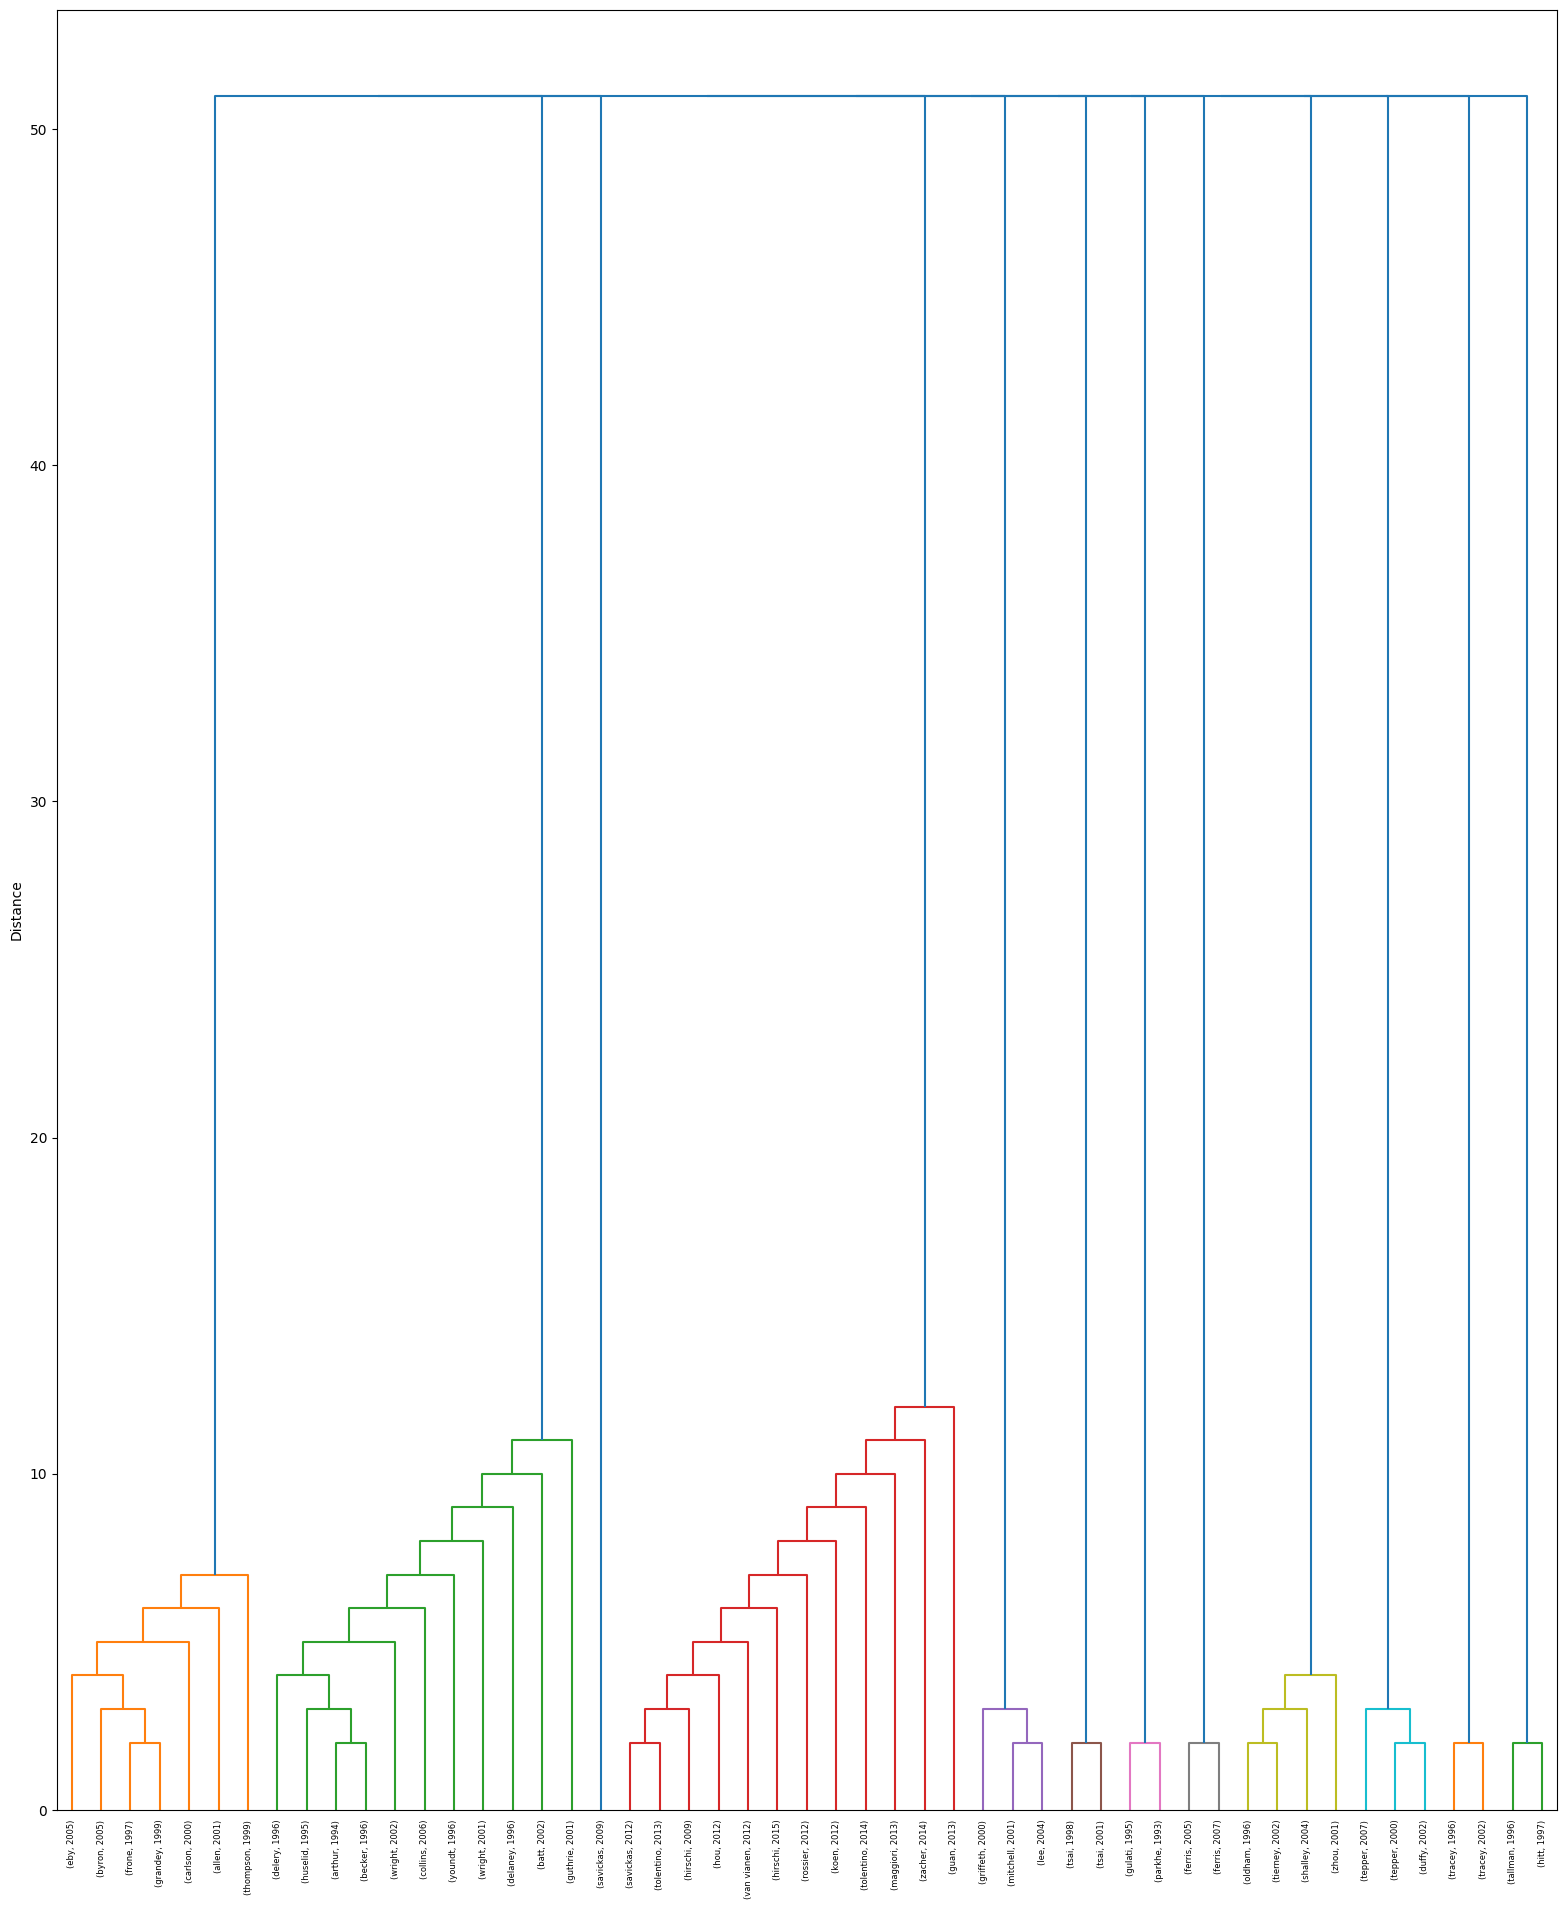

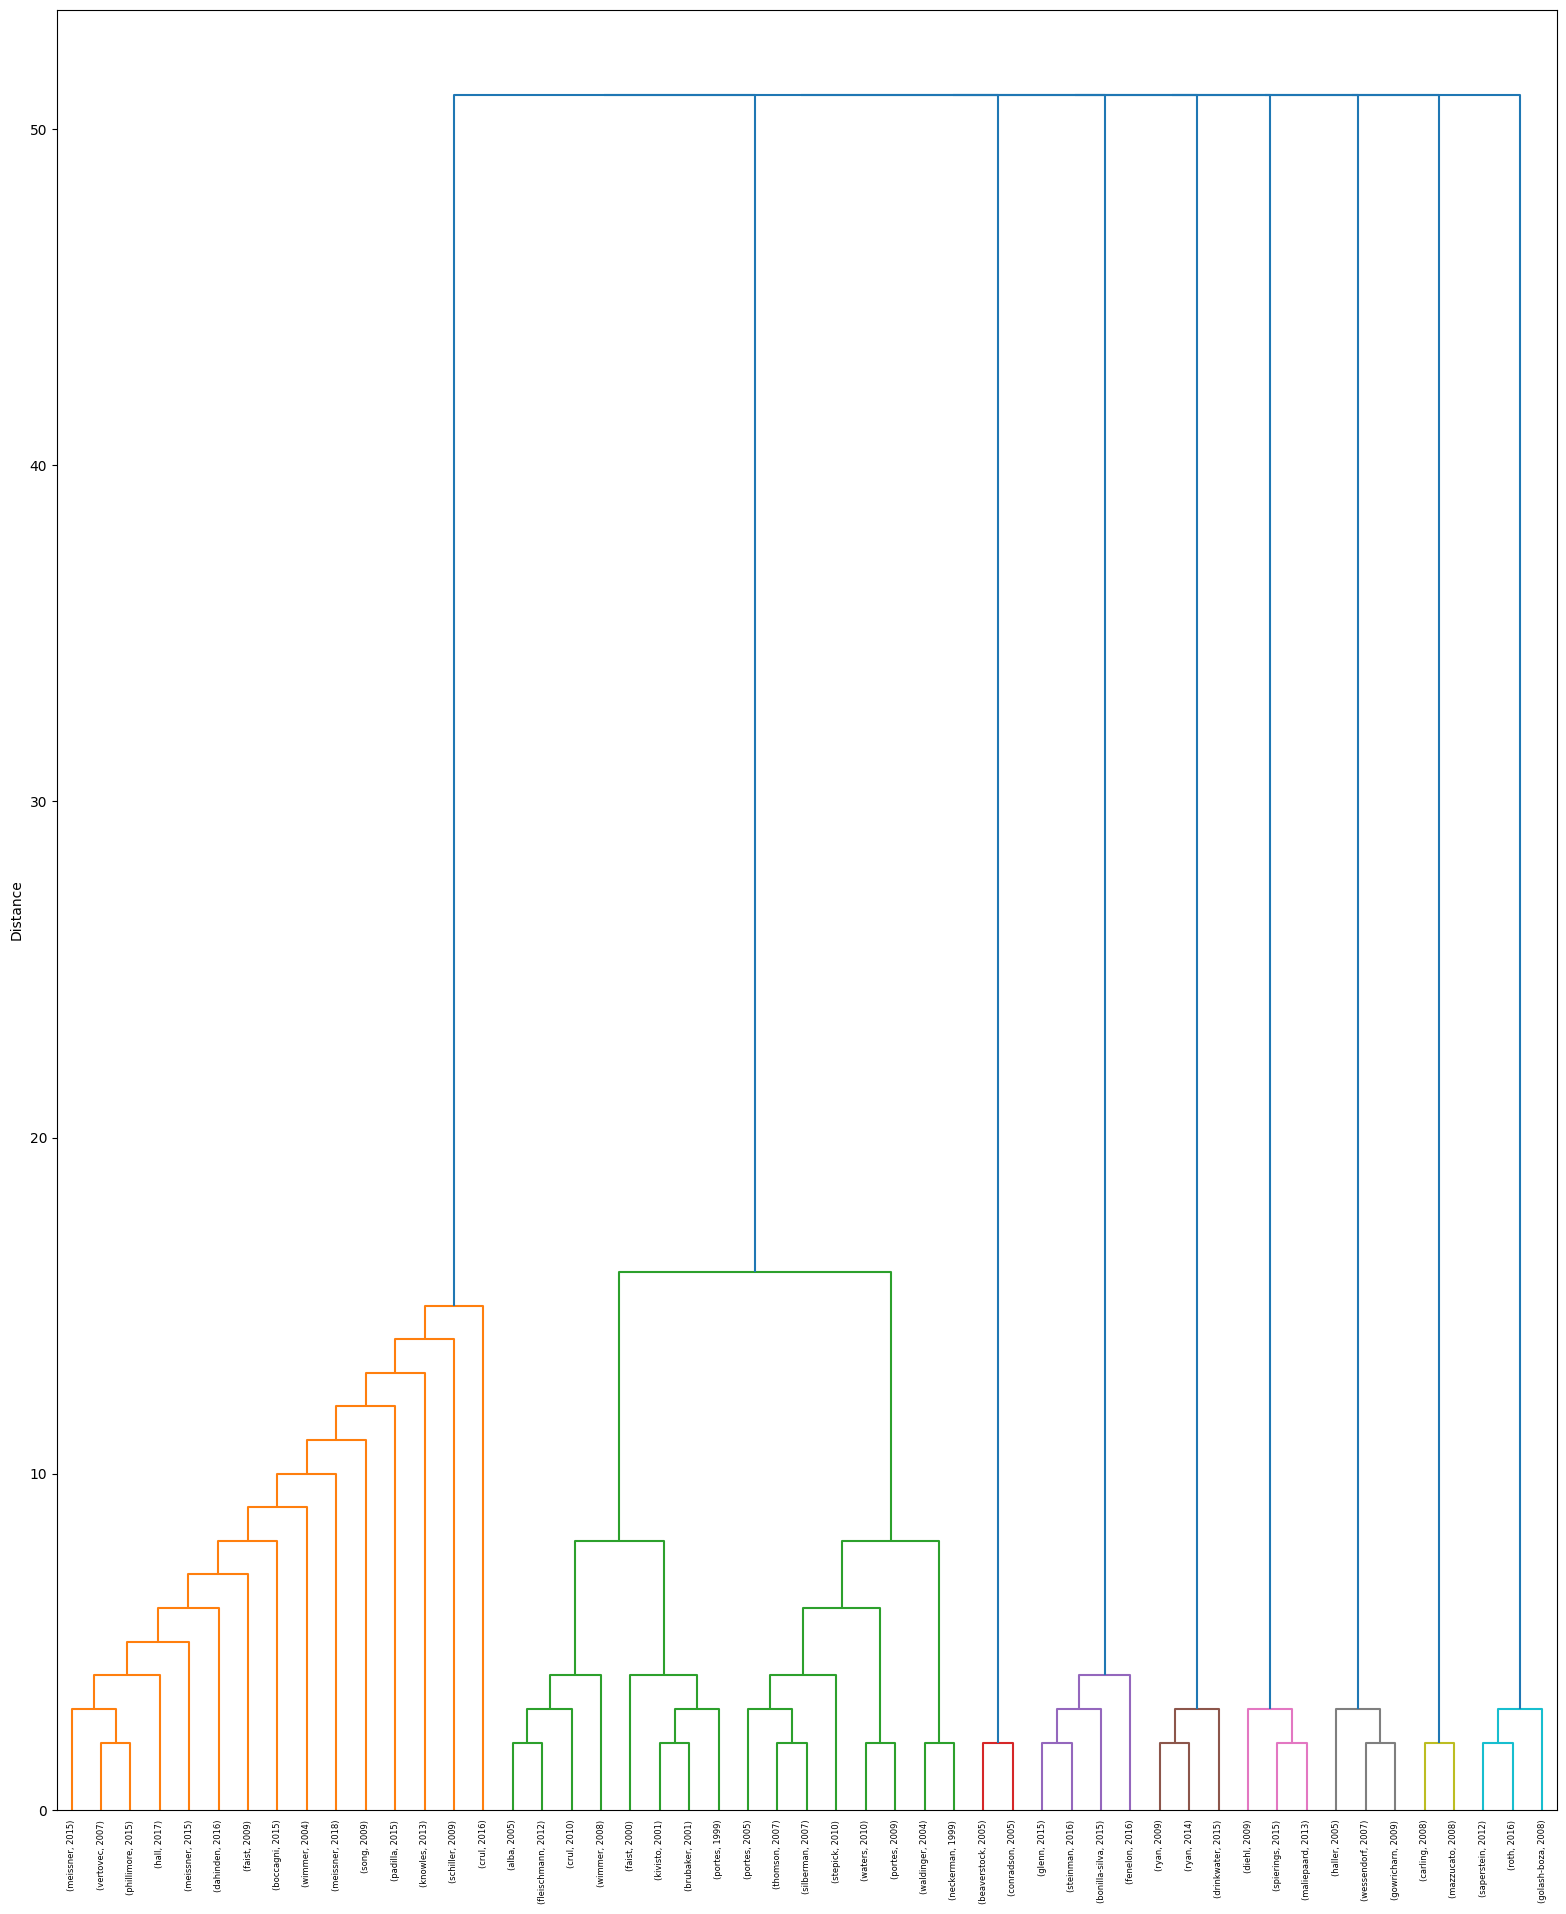

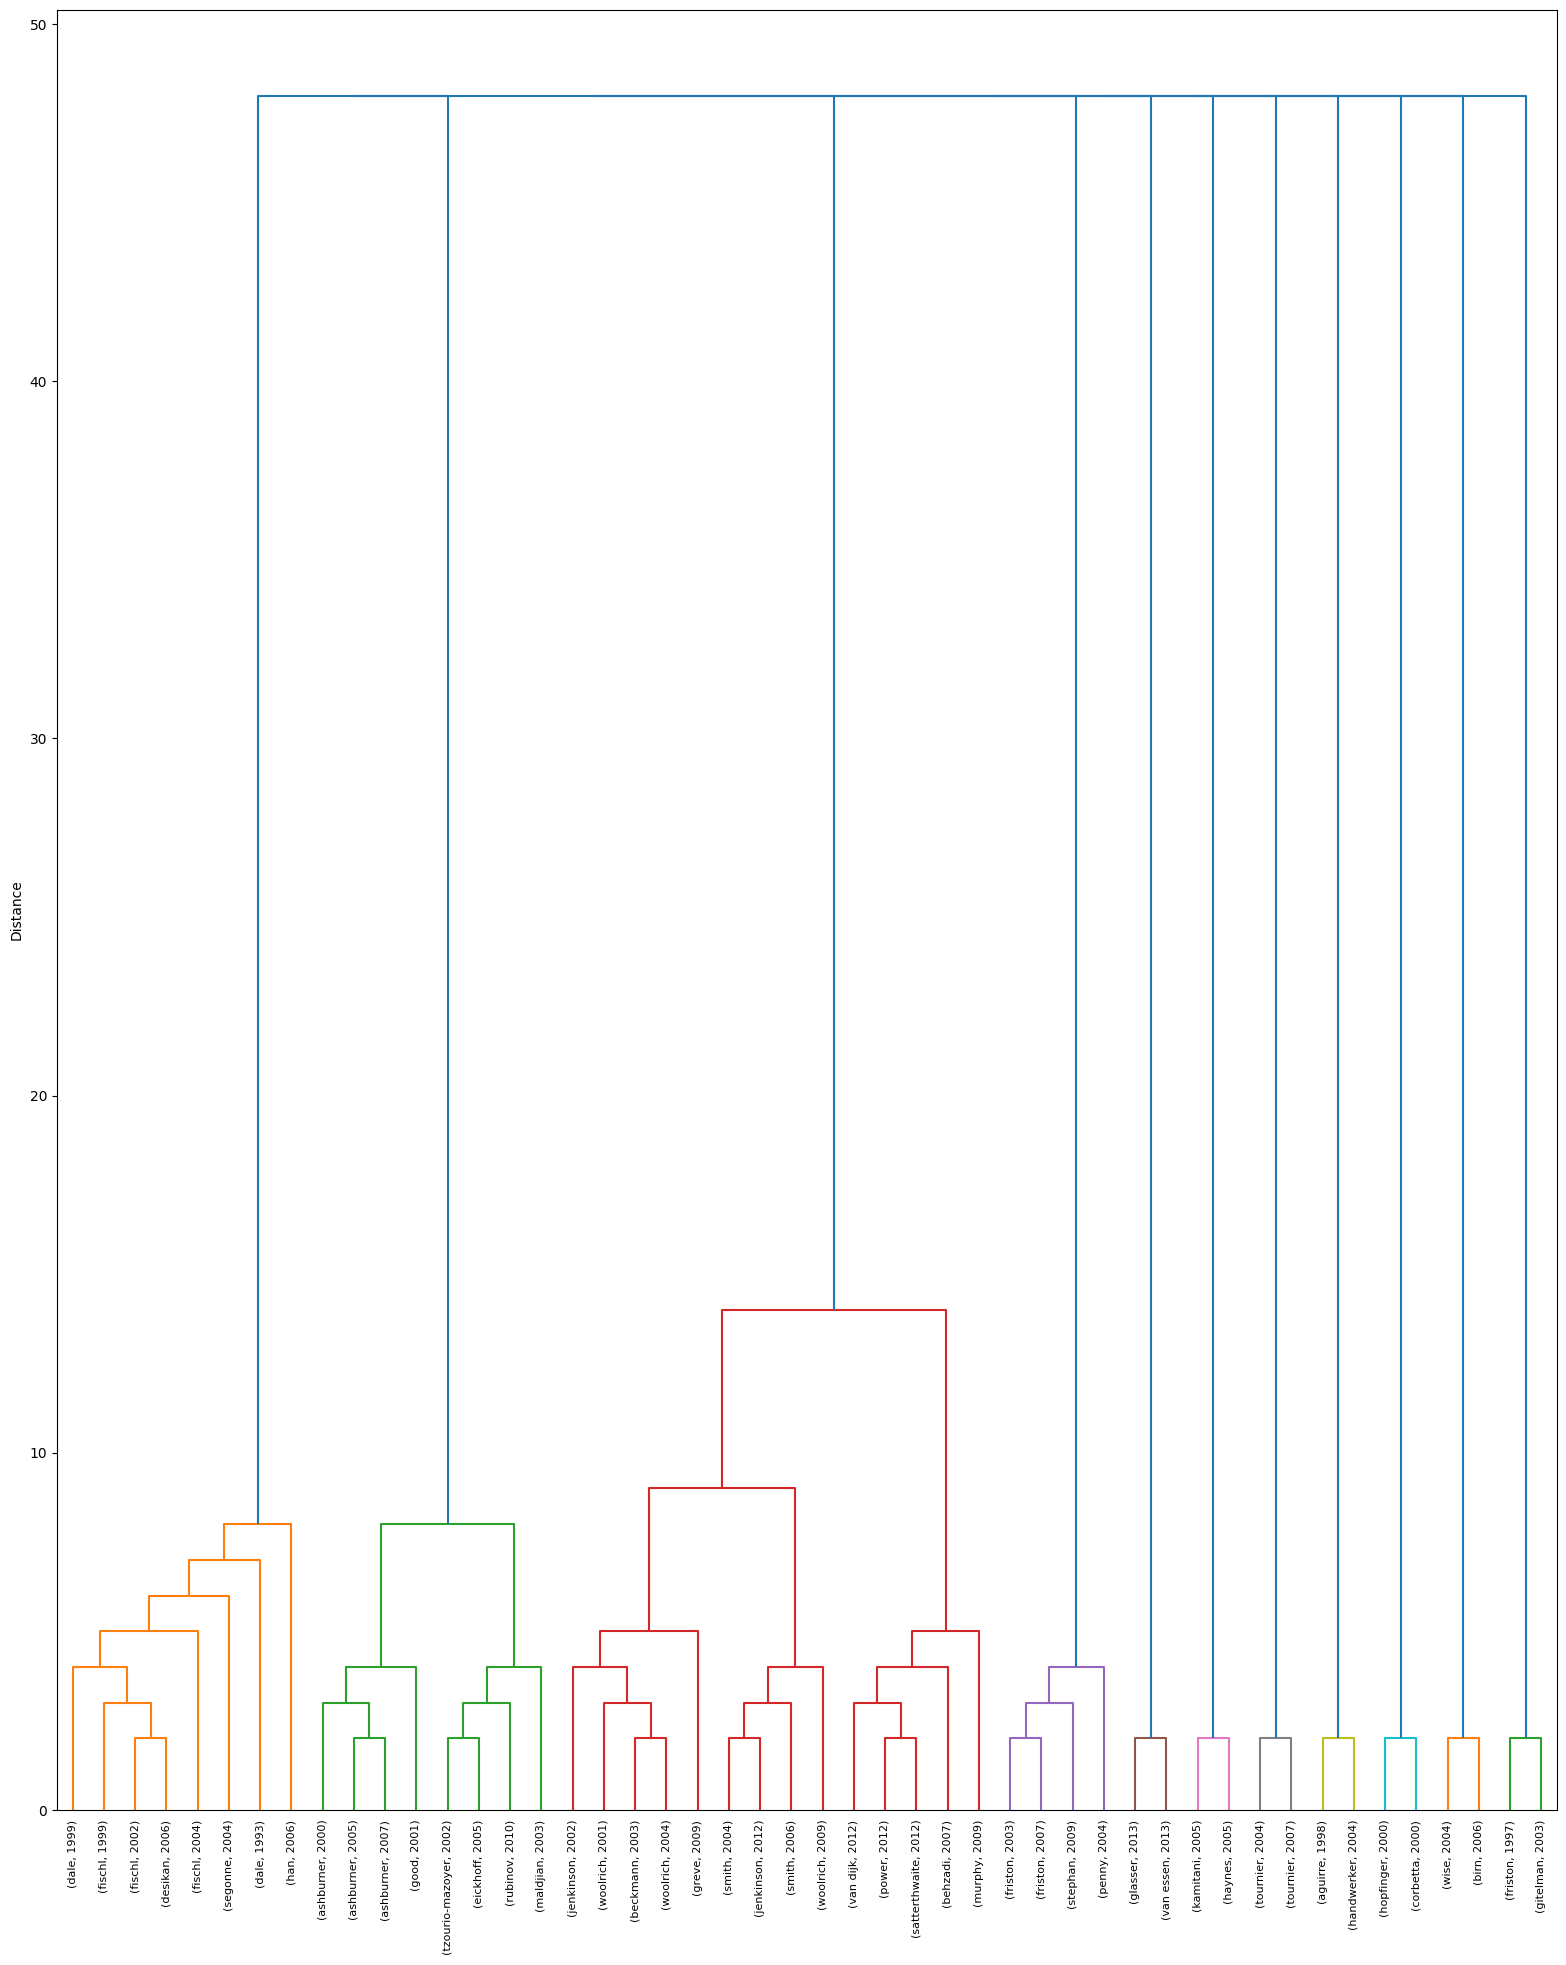

In [7]:
sns.reset_defaults()

for (field_name, G) in Gs.items():

    print(field_name)

    nodes = list(G.nodes)
    comms = list(nx_comm.girvan_newman(G))
    comms.insert(0, (set(nodes),))

    Z, leaves = compute_Z(comms)
    
    new_leaves = dict(
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(leaves))
        .to_numpy()
    )

    leaves = dict(zip(leaves, leaves))
    leaves.update(new_leaves)

    fig = plt.figure(figsize=(15, 18))
    ax = fig.add_axes([0, 0, 1, 1])

    # ax.set_xlabel('Node')
    ax.set_ylabel('Distance')
    
    dendrogram(Z, labels=list(leaves.values()), ax=ax)
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
    fig.tight_layout()

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_girvan_newman_hier_comm', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=300,
        bbox_inches='tight'
    )

    

# Louvain

Gender Studies


/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_69179/1908715851.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


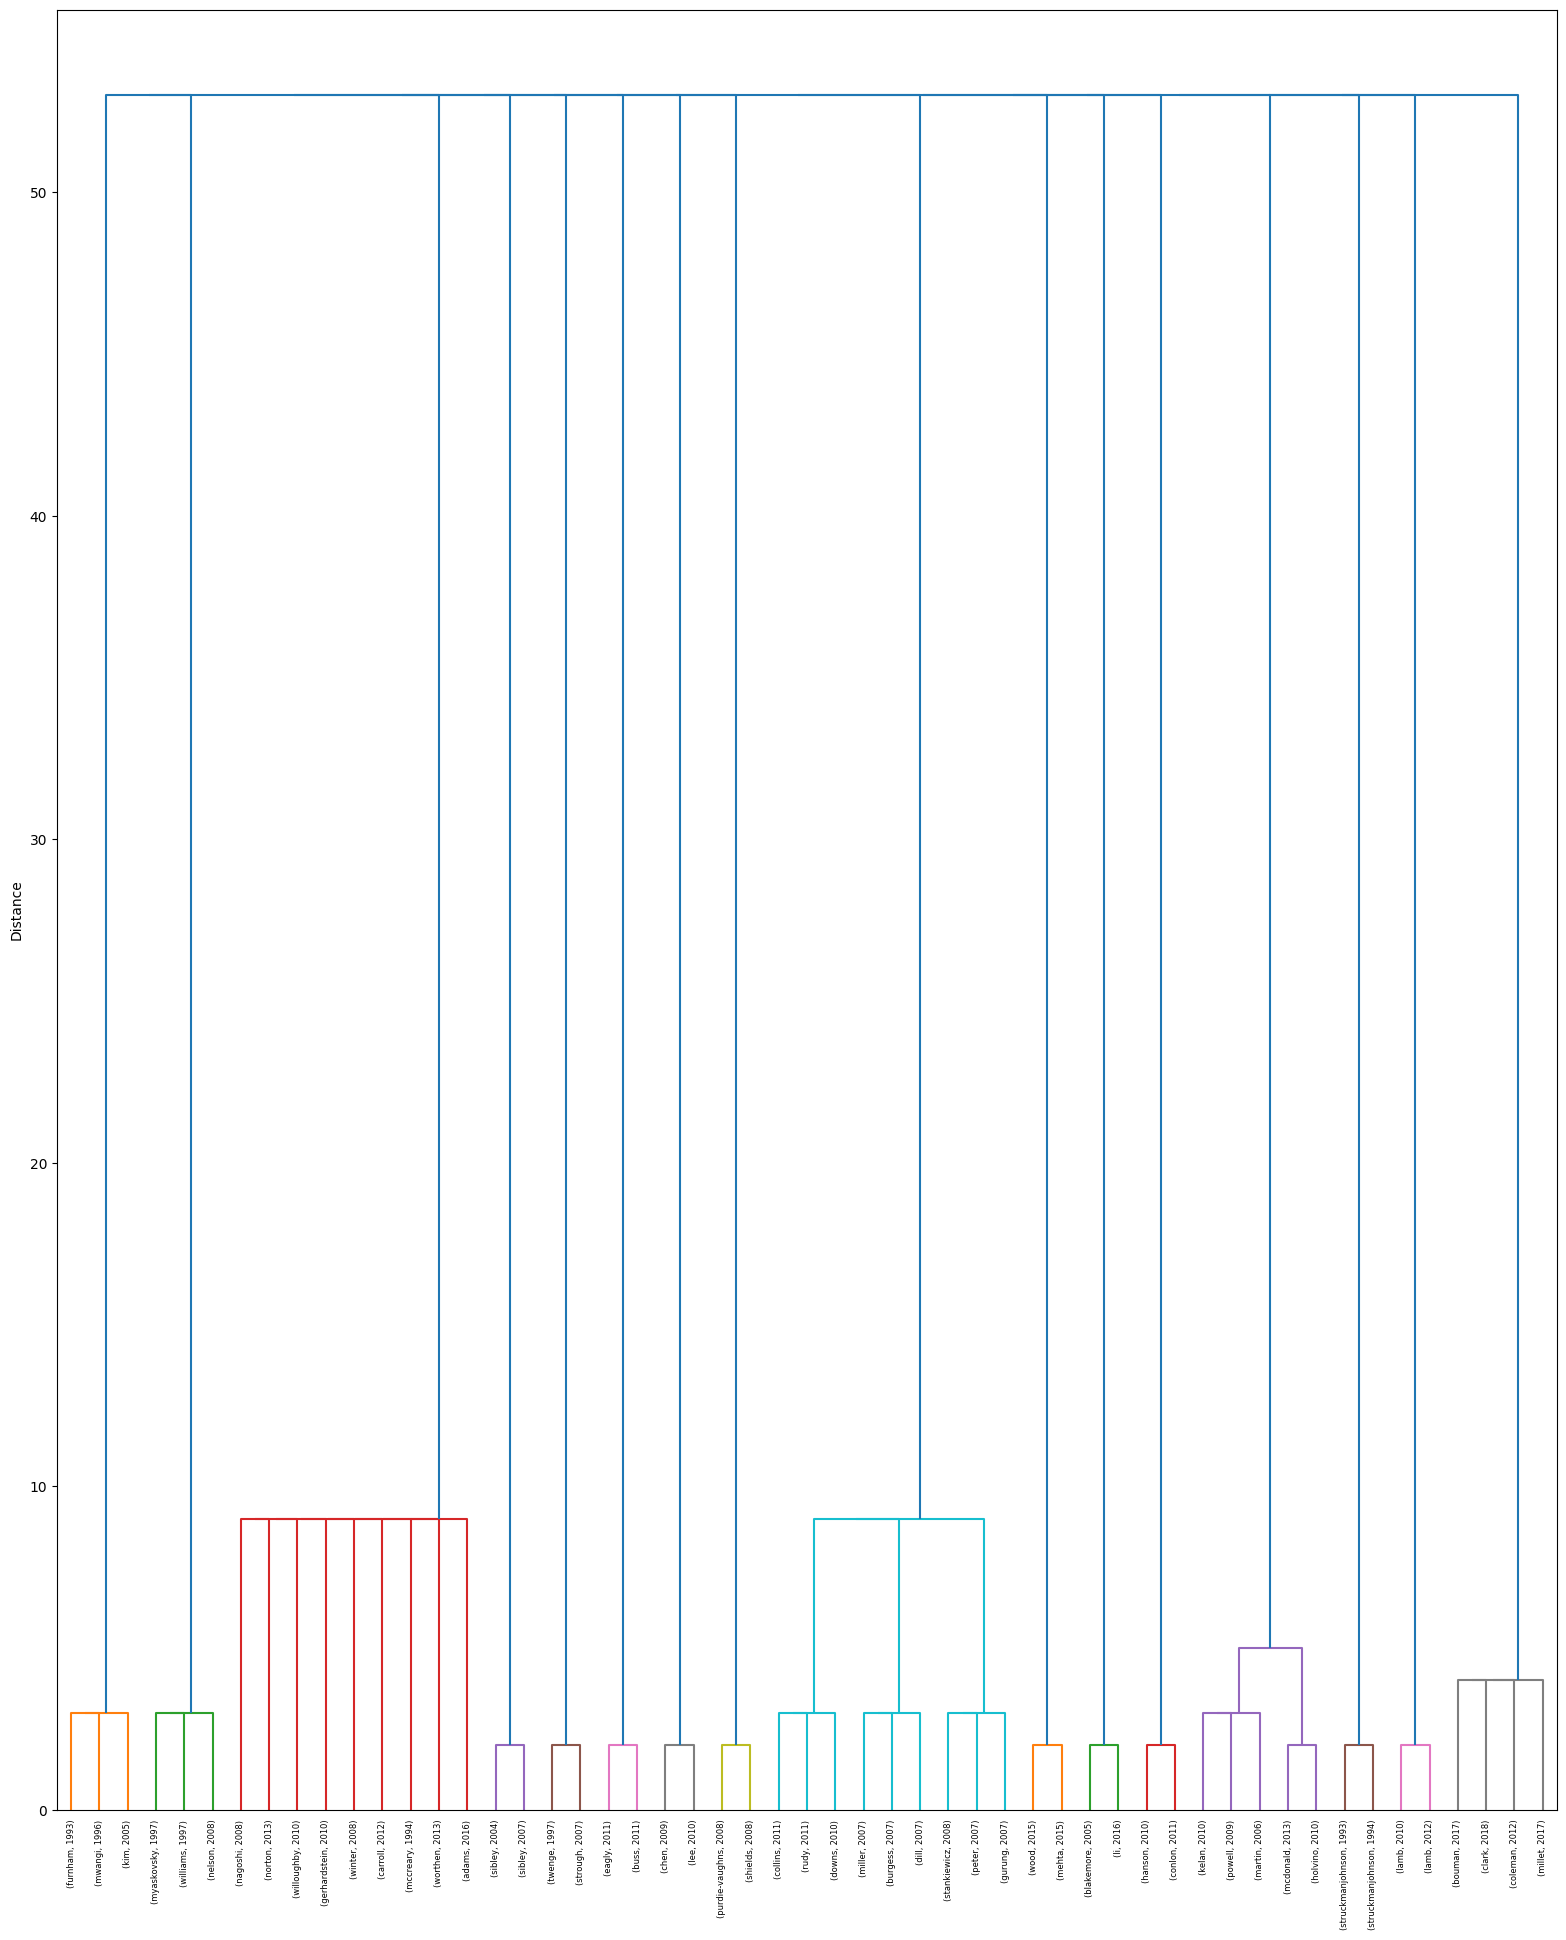

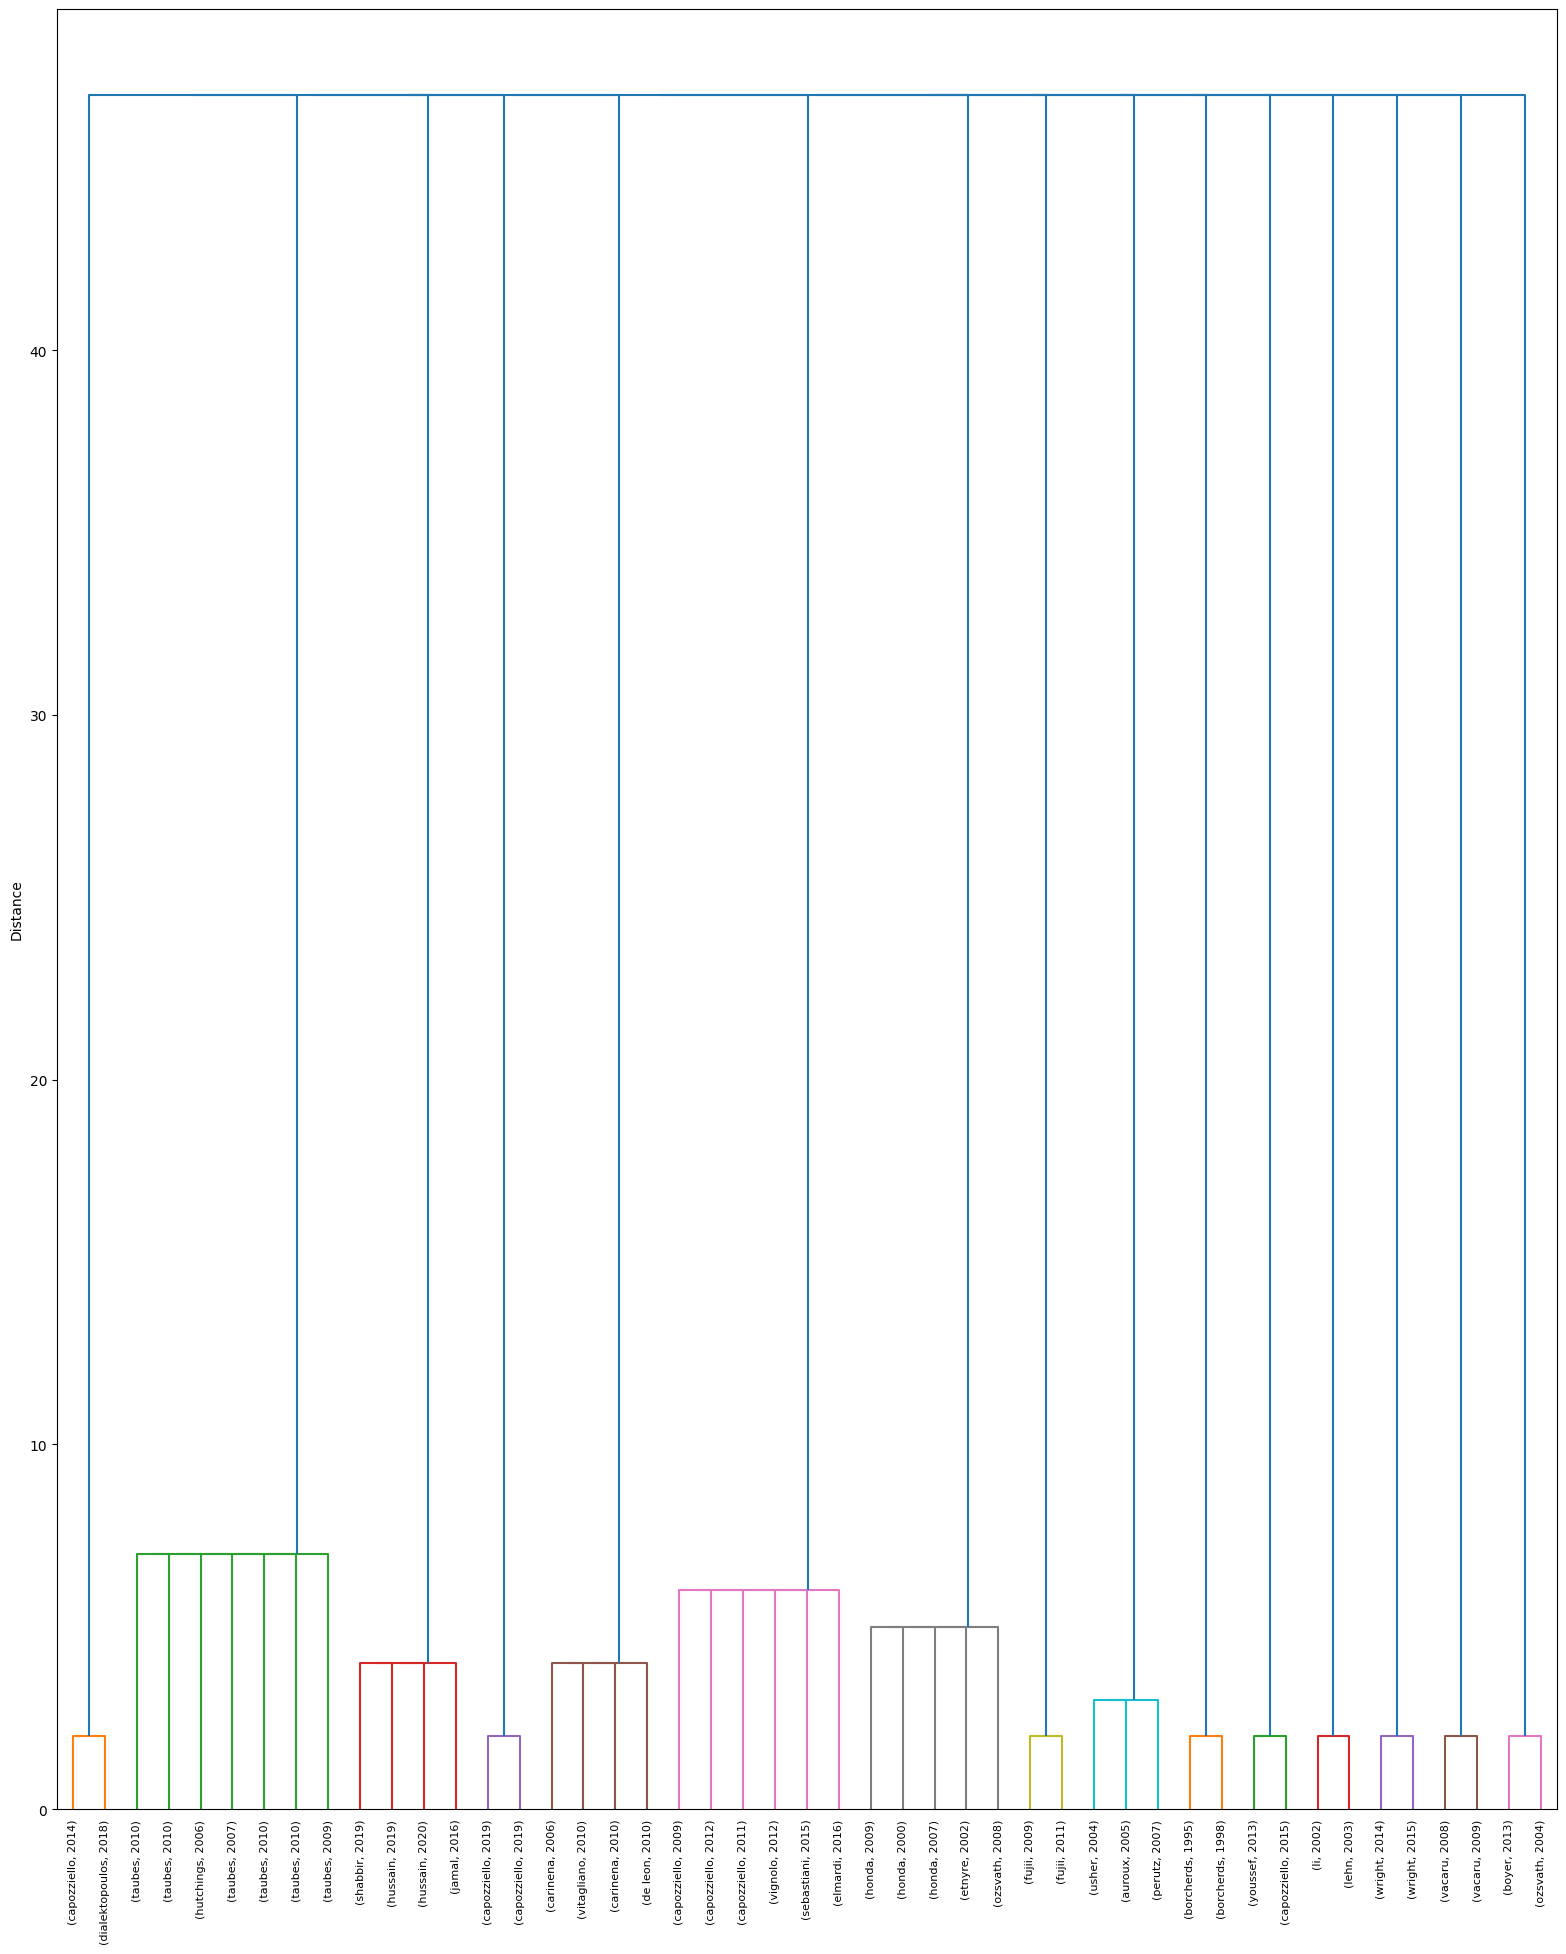

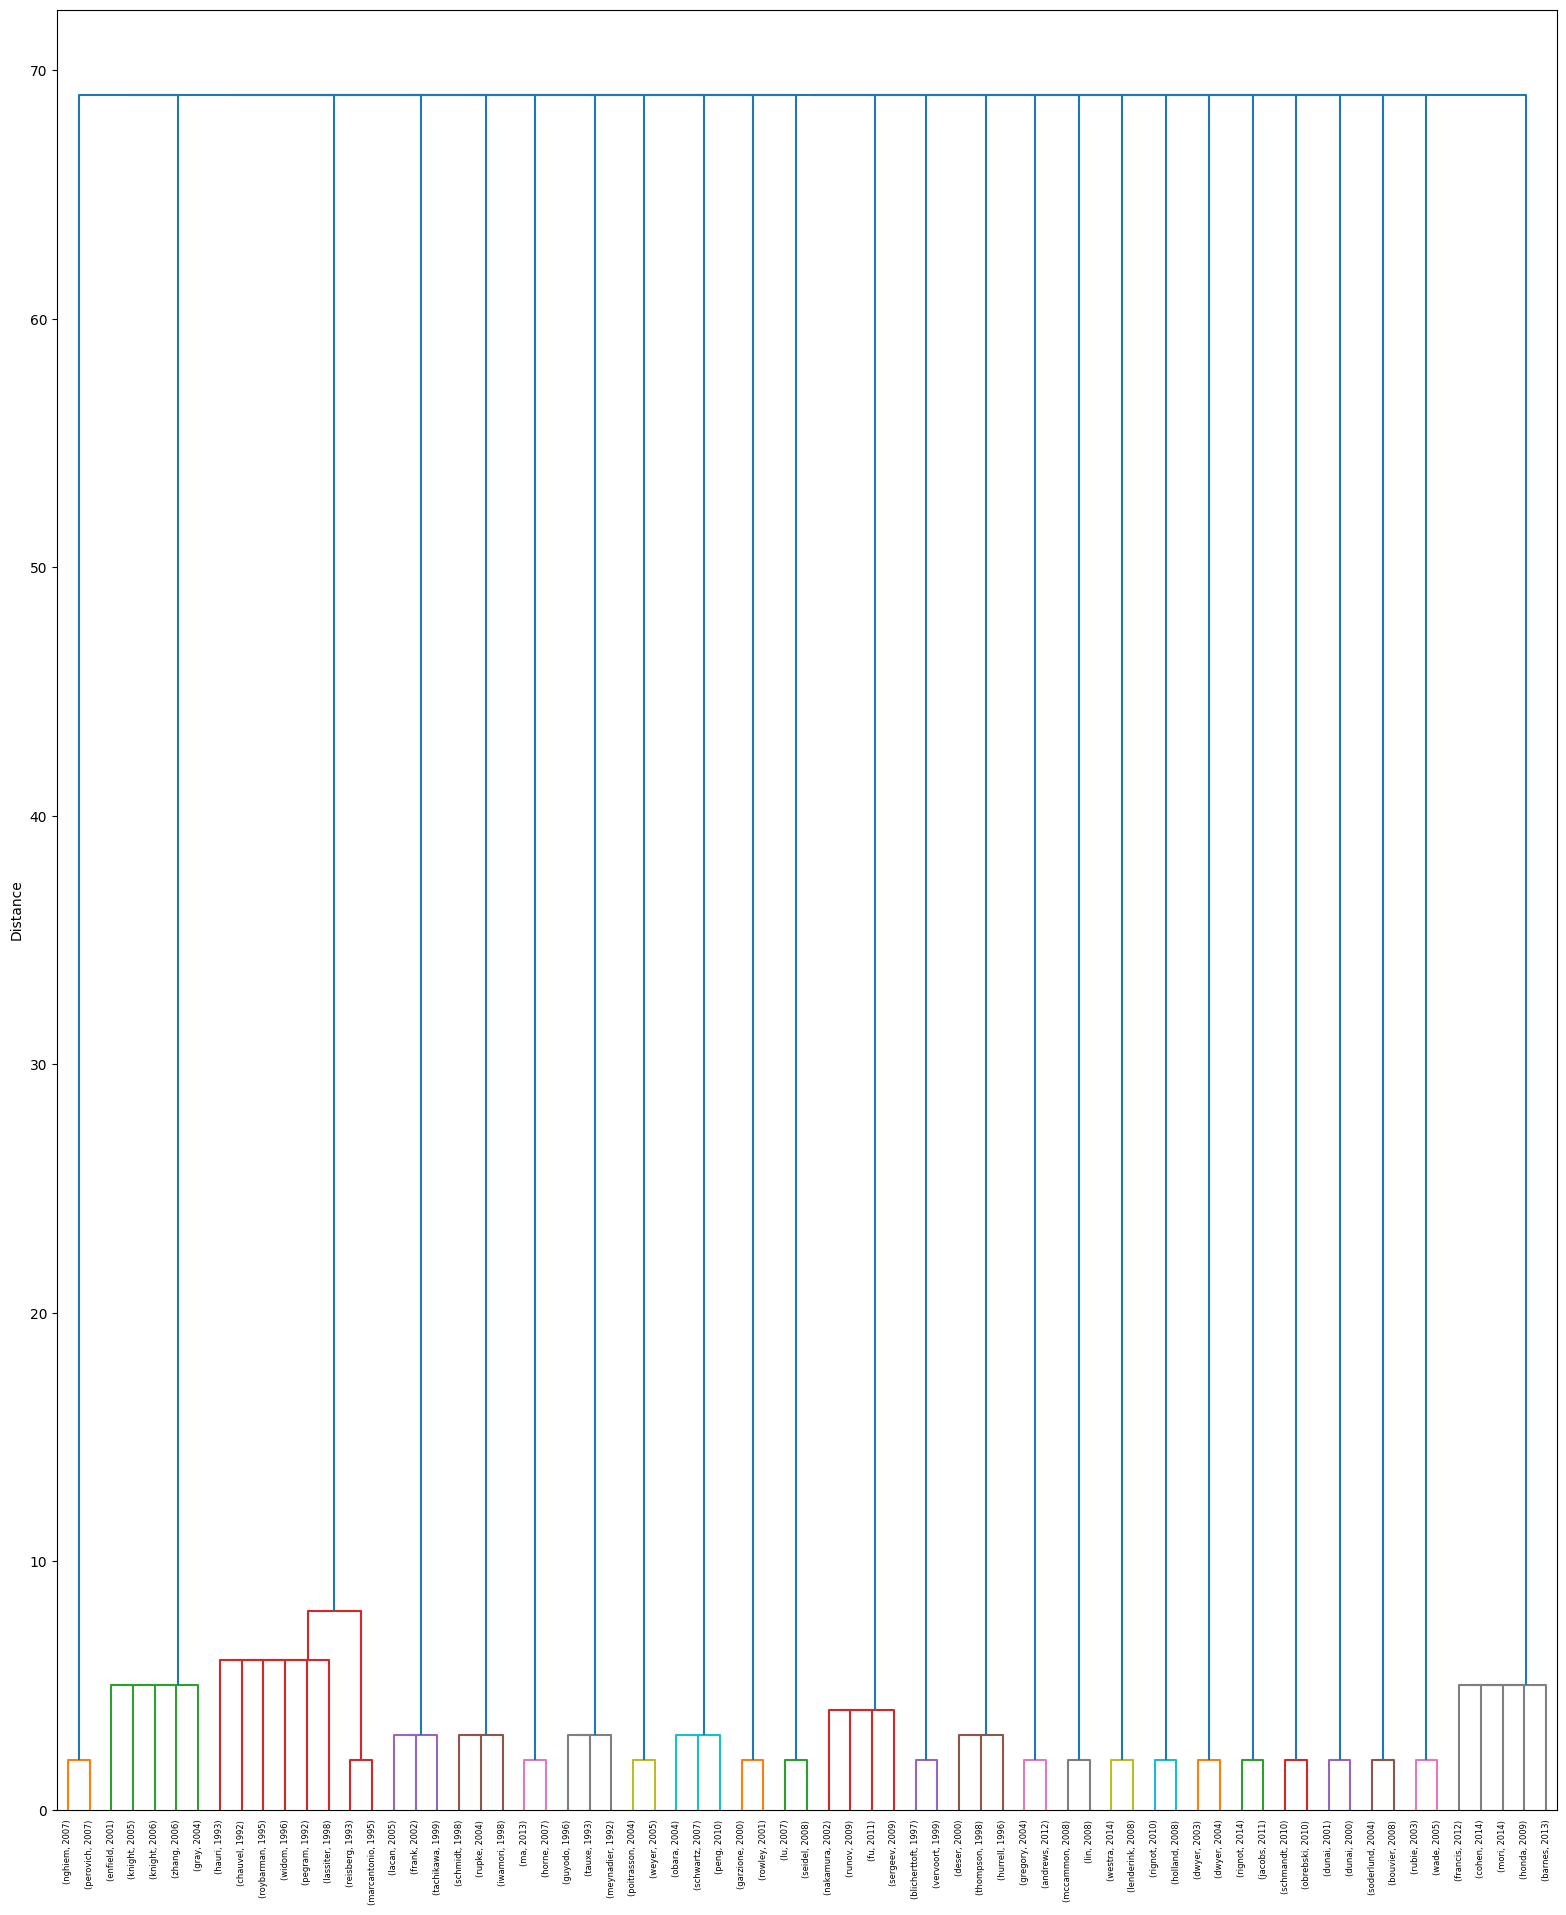

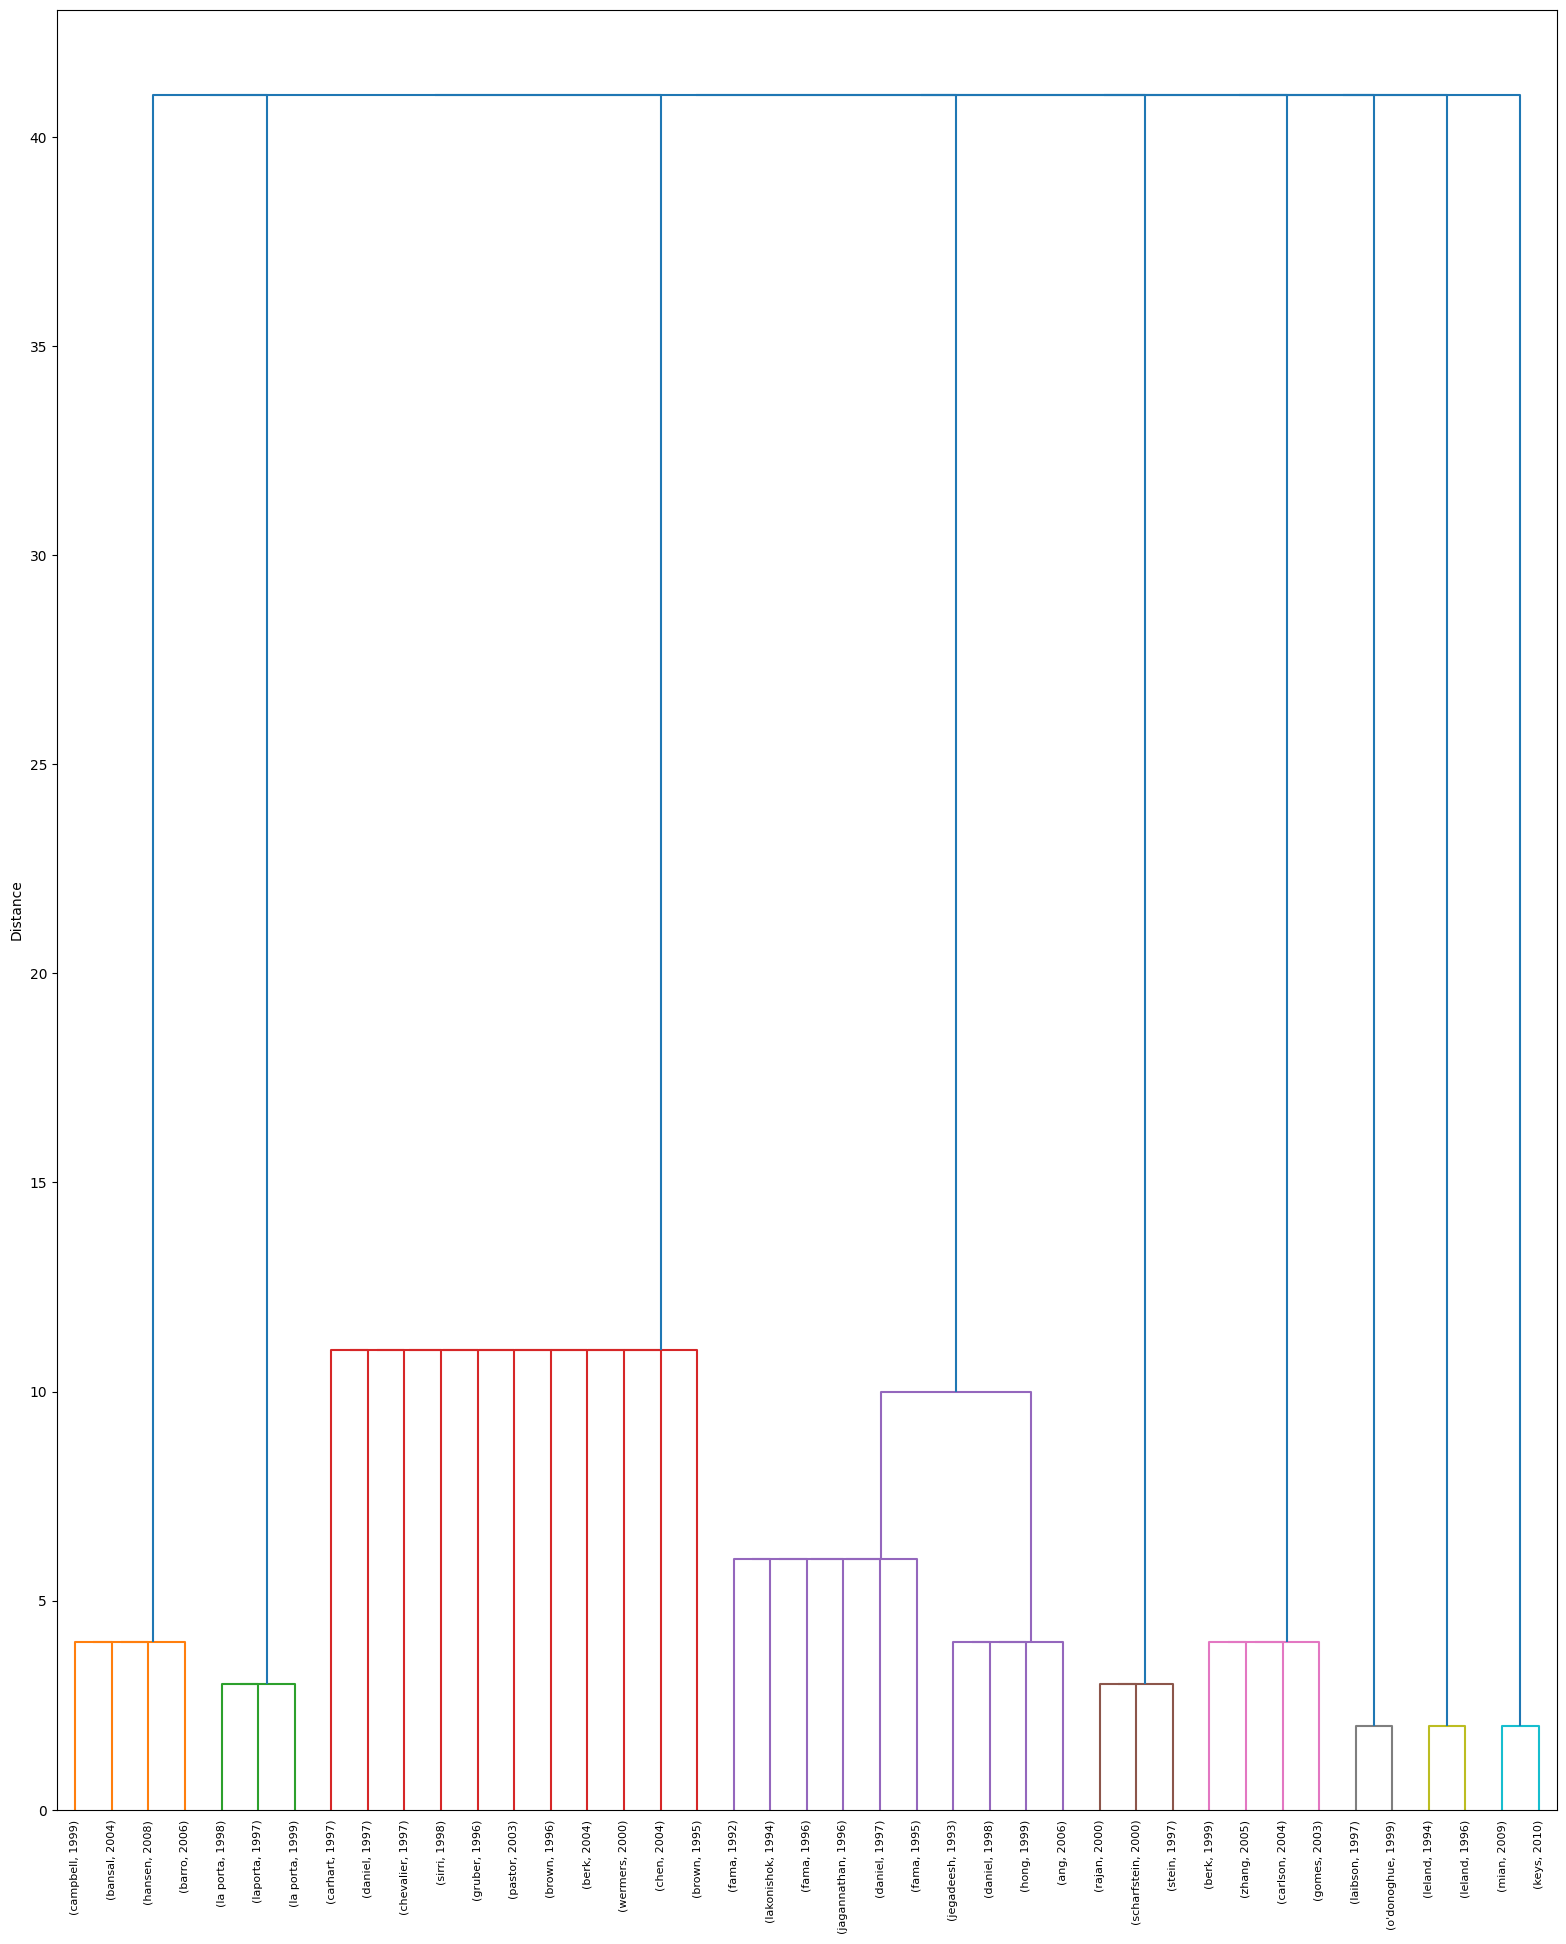

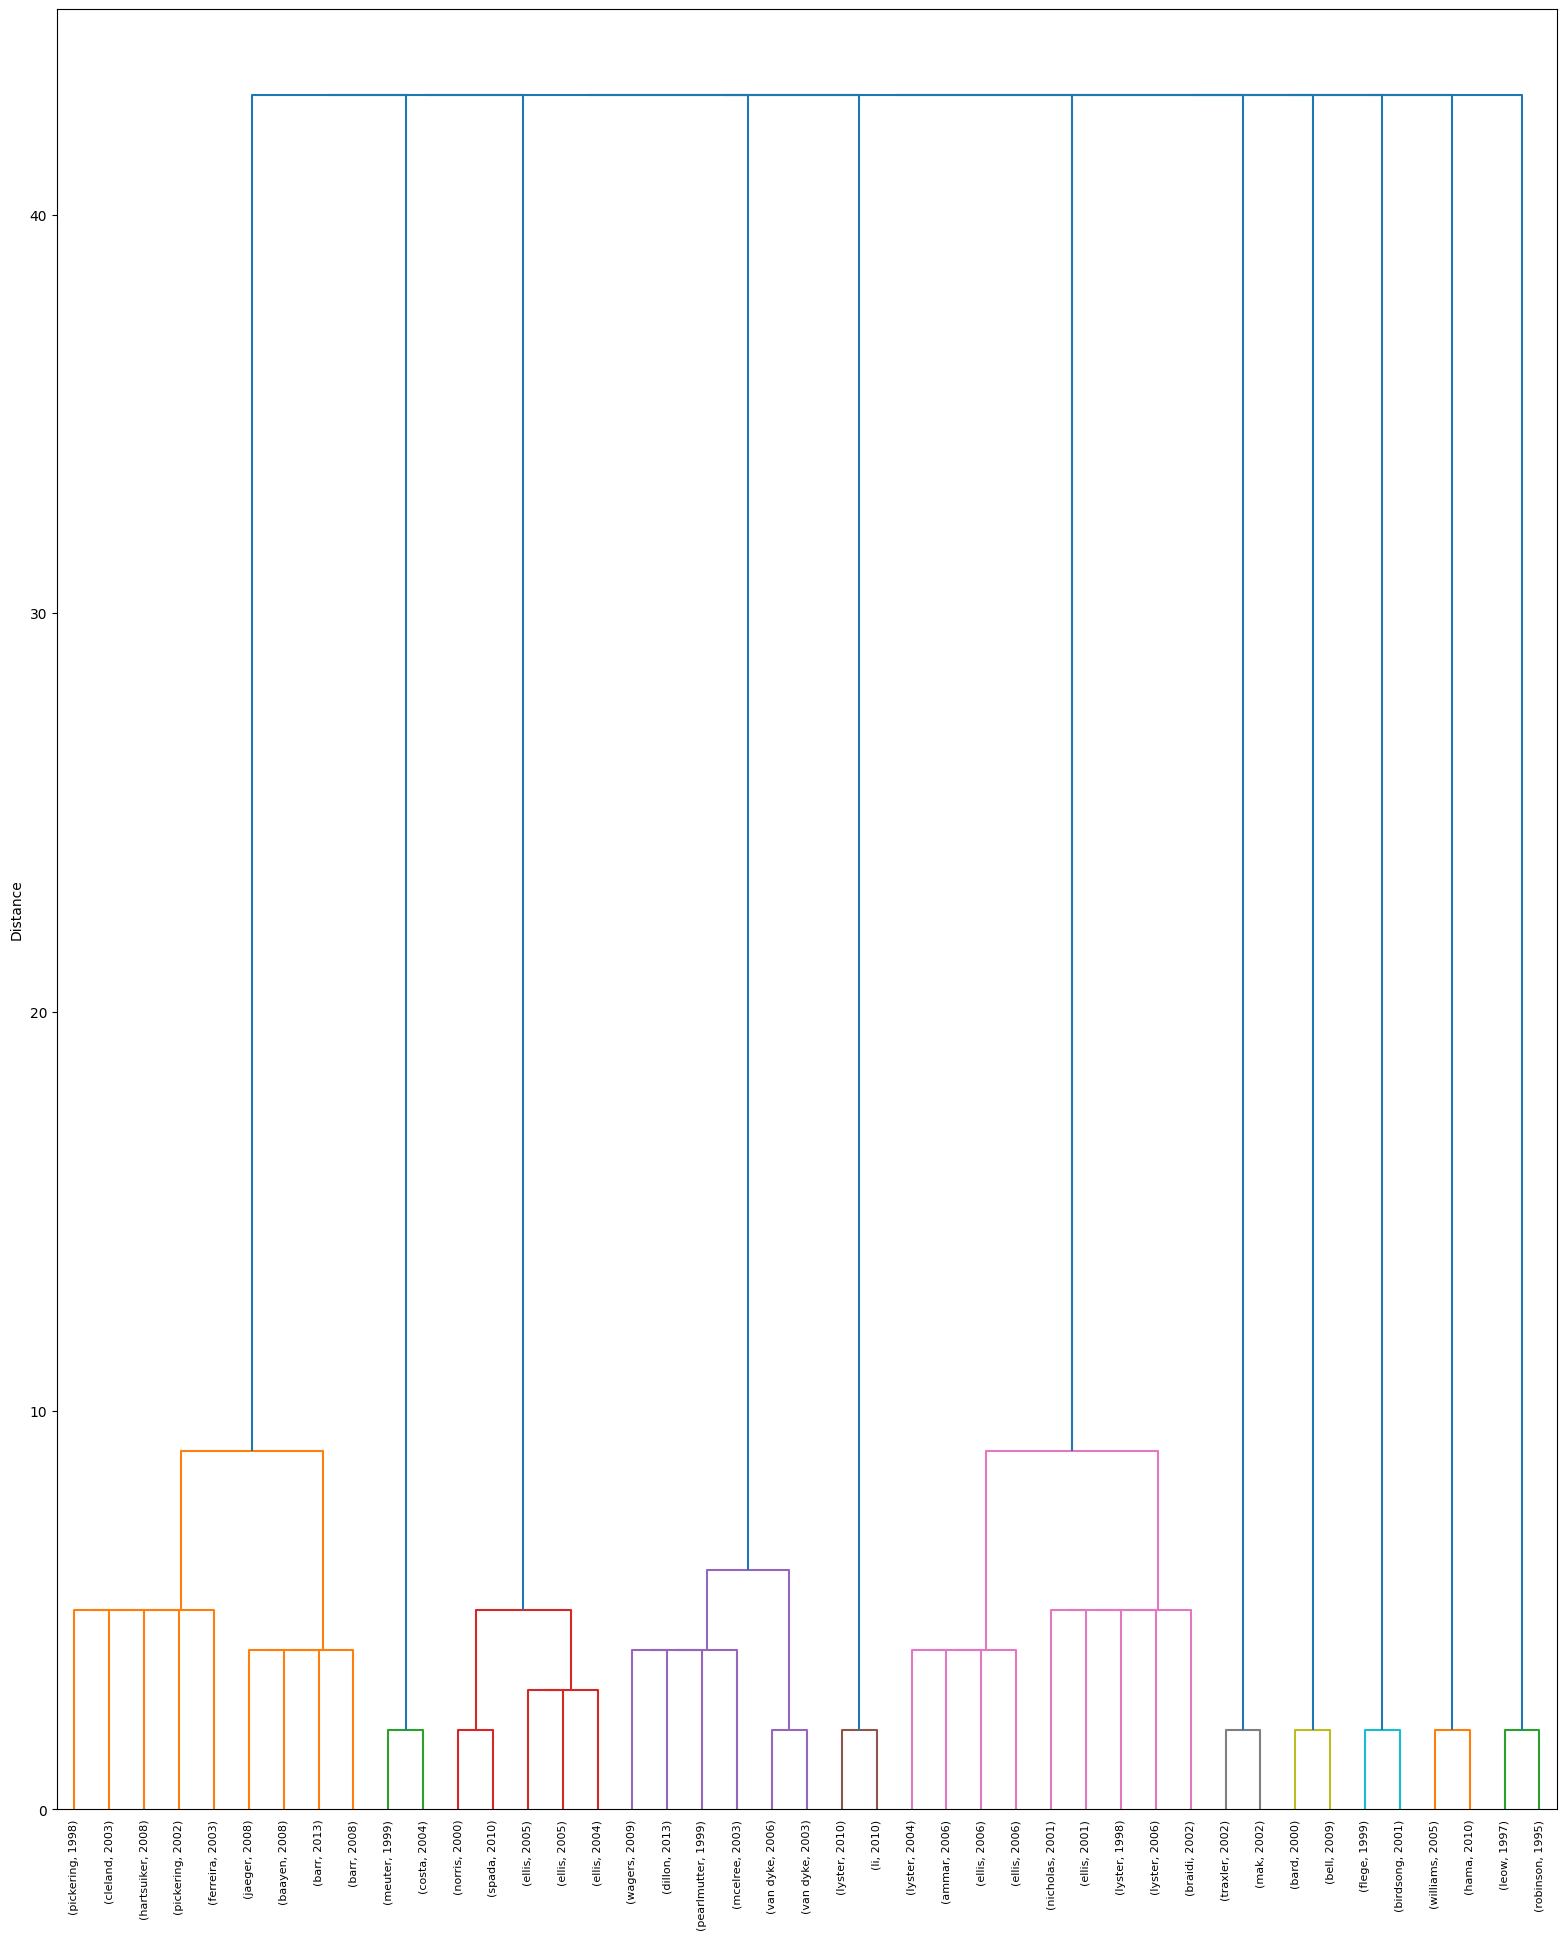

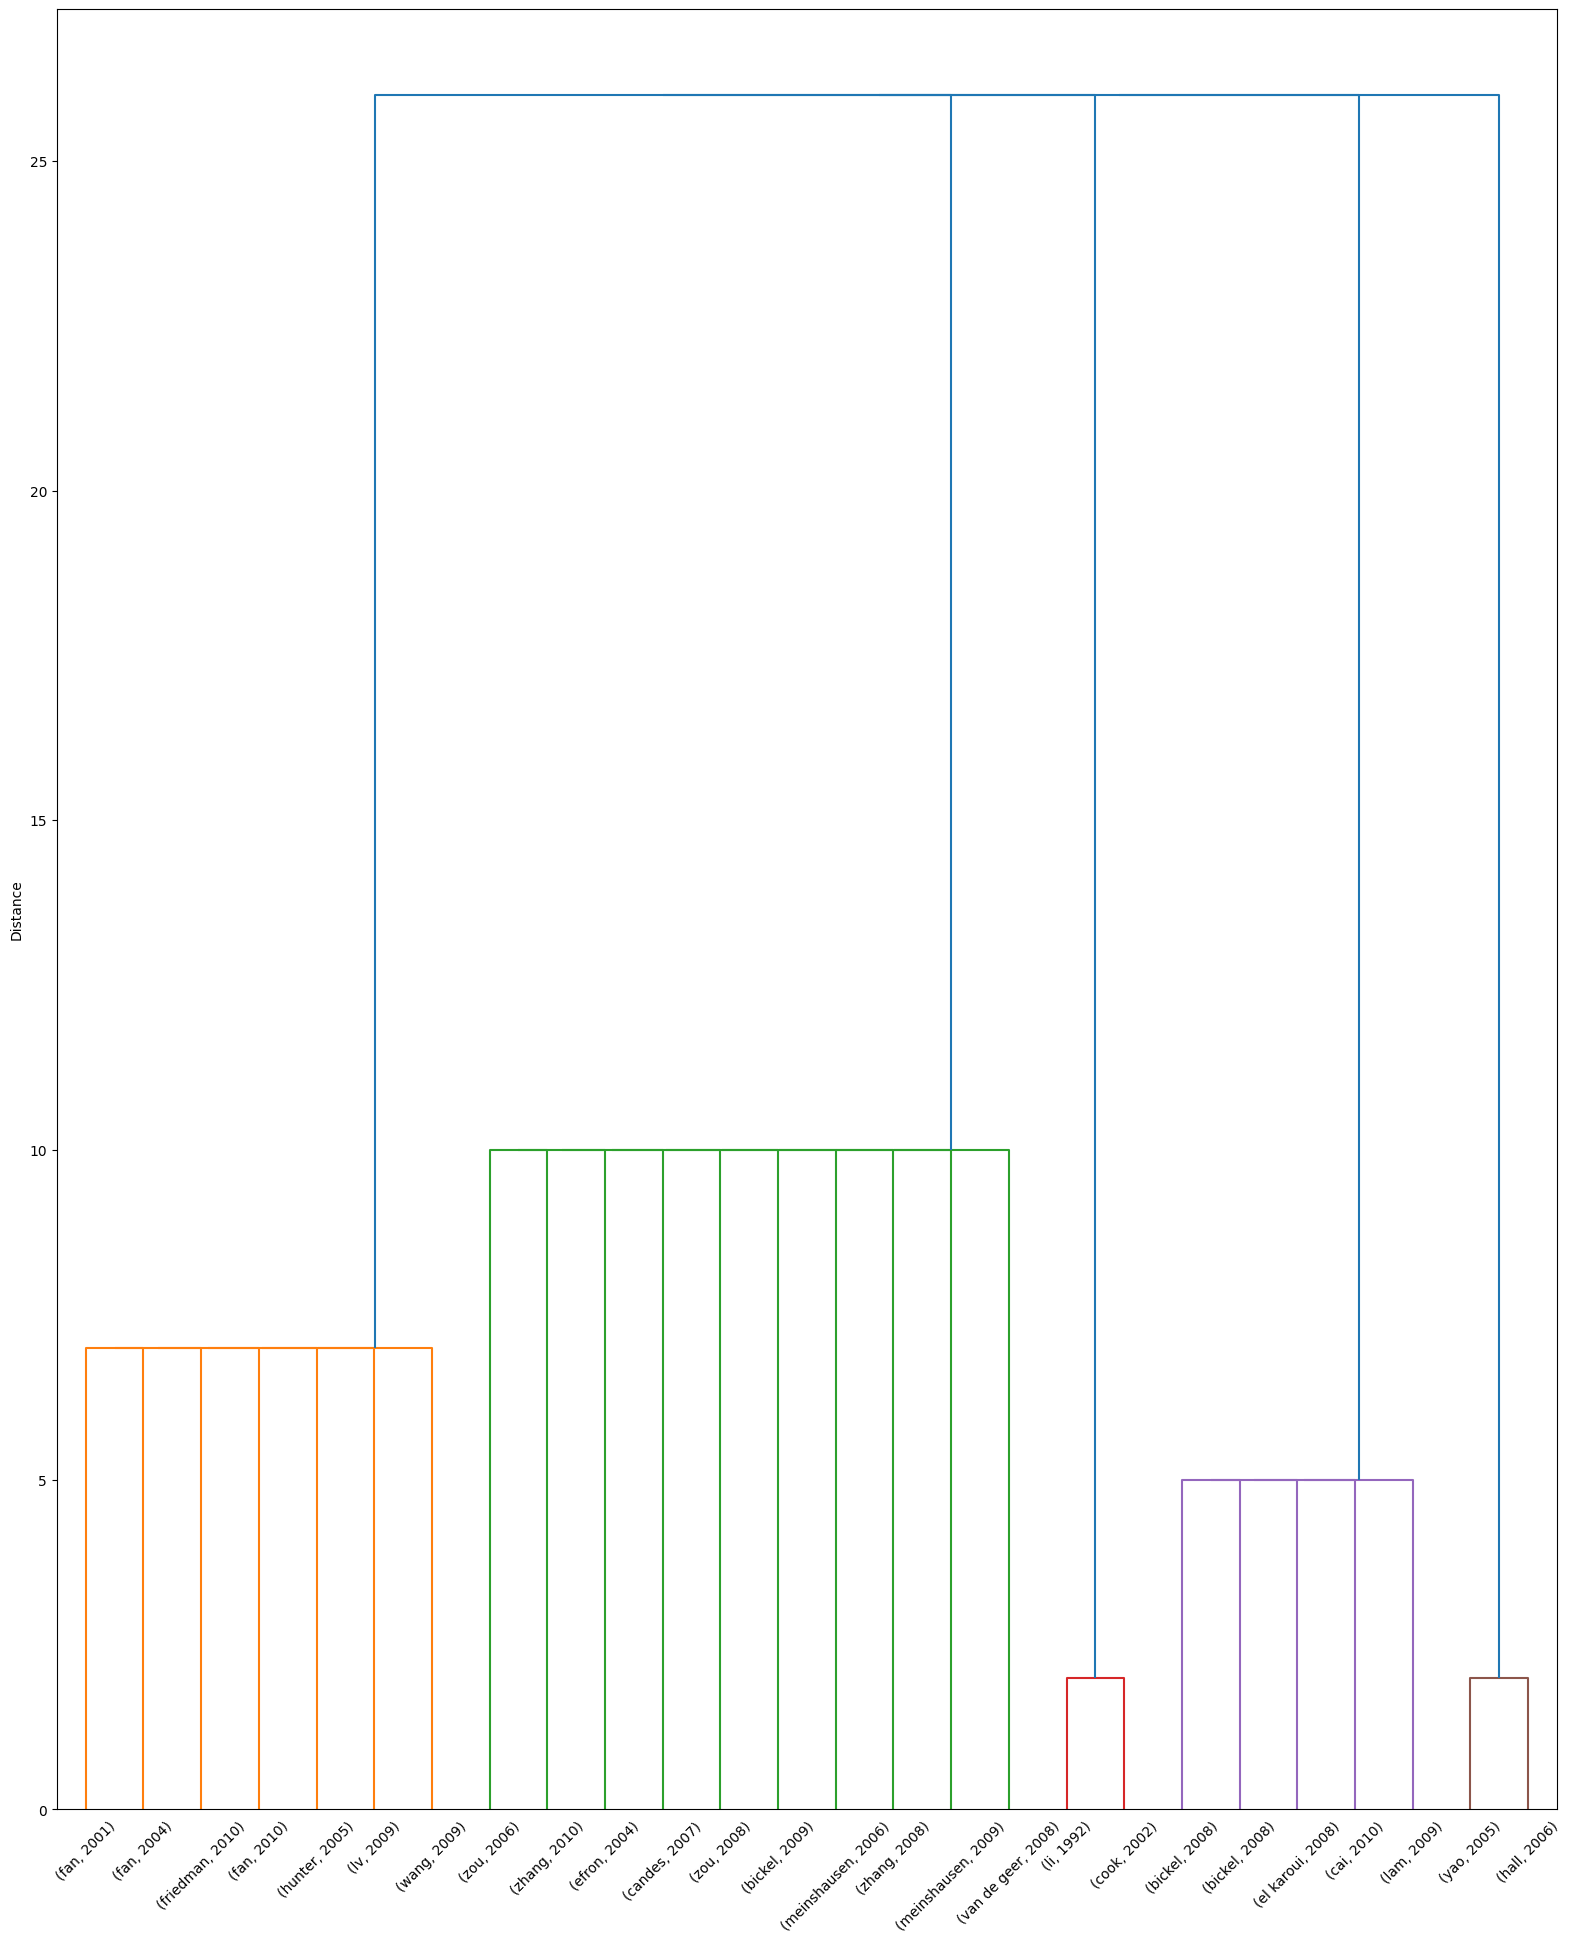

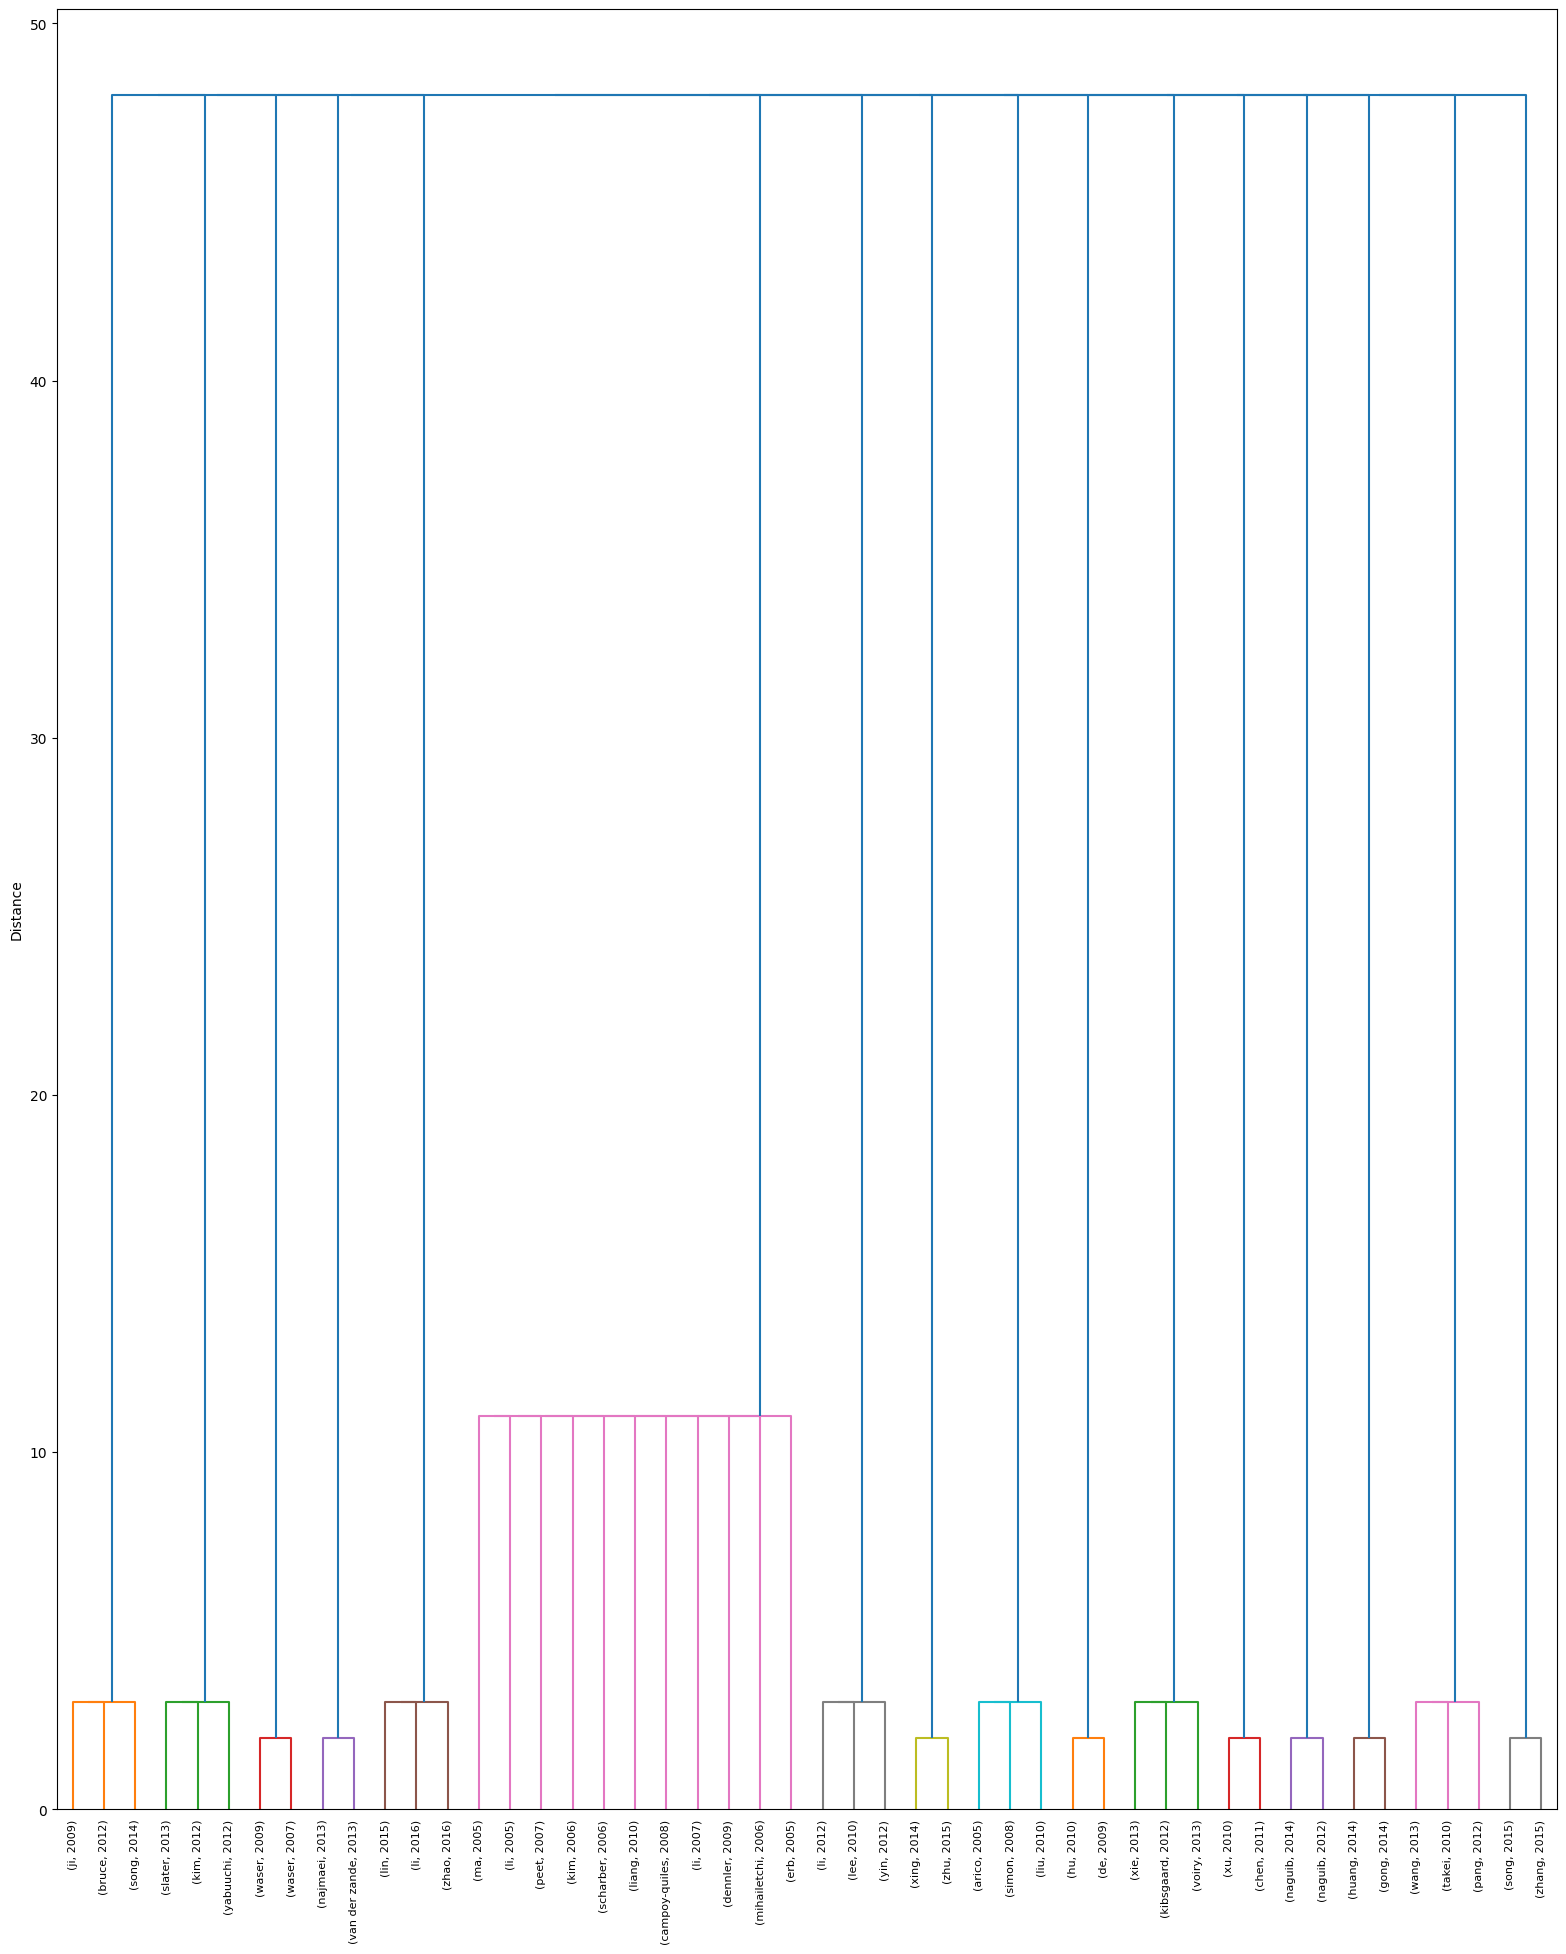

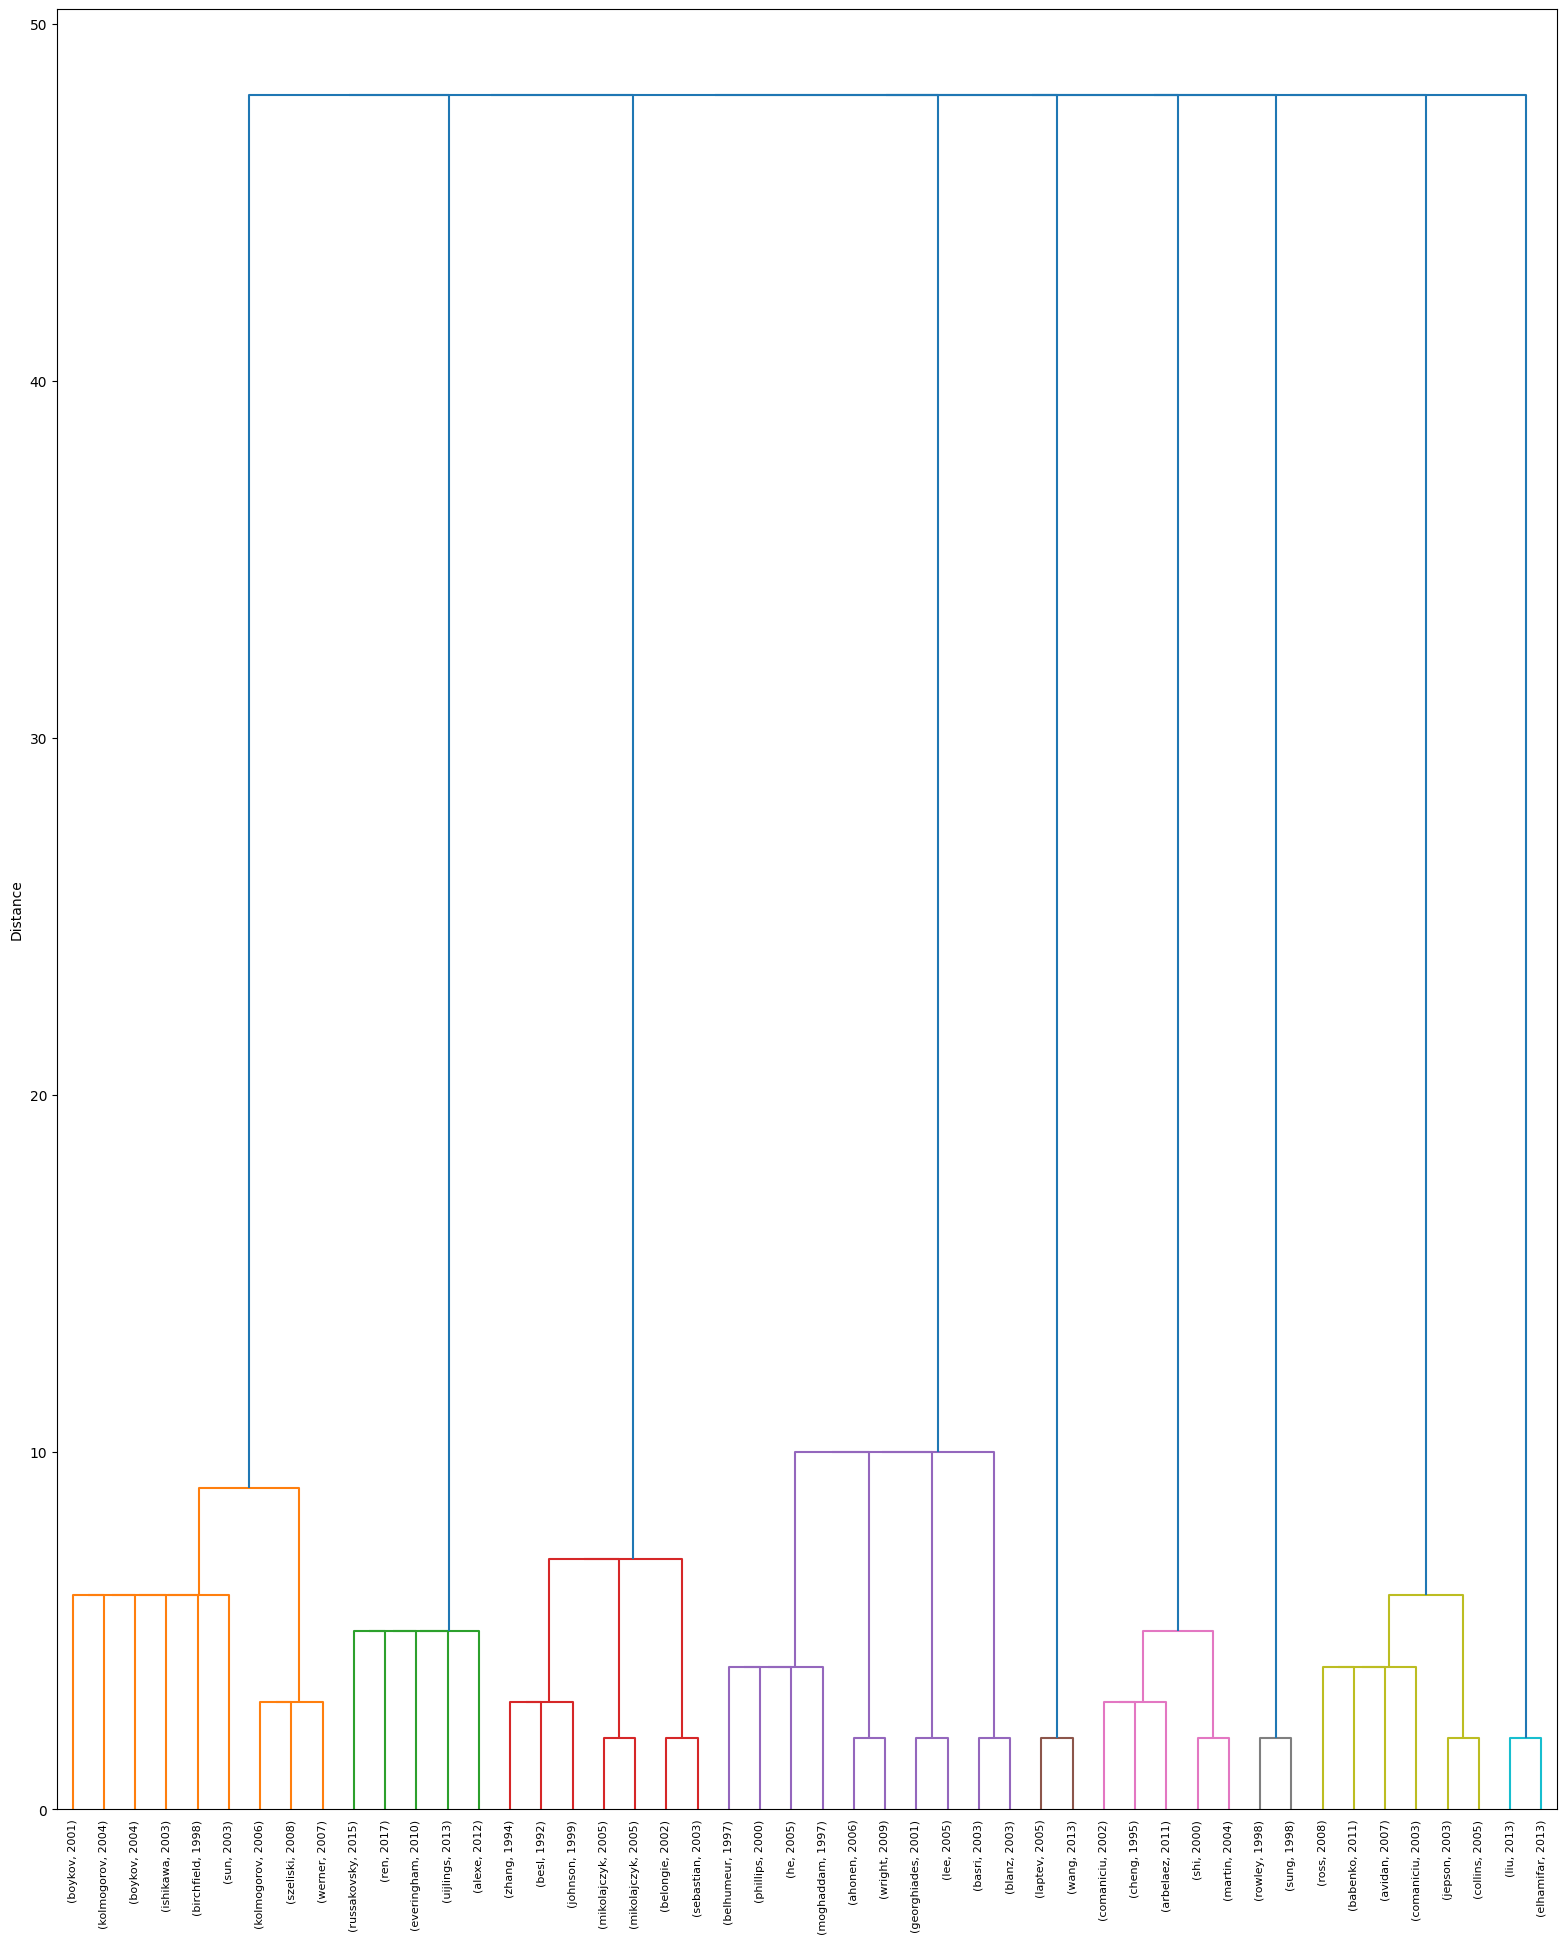

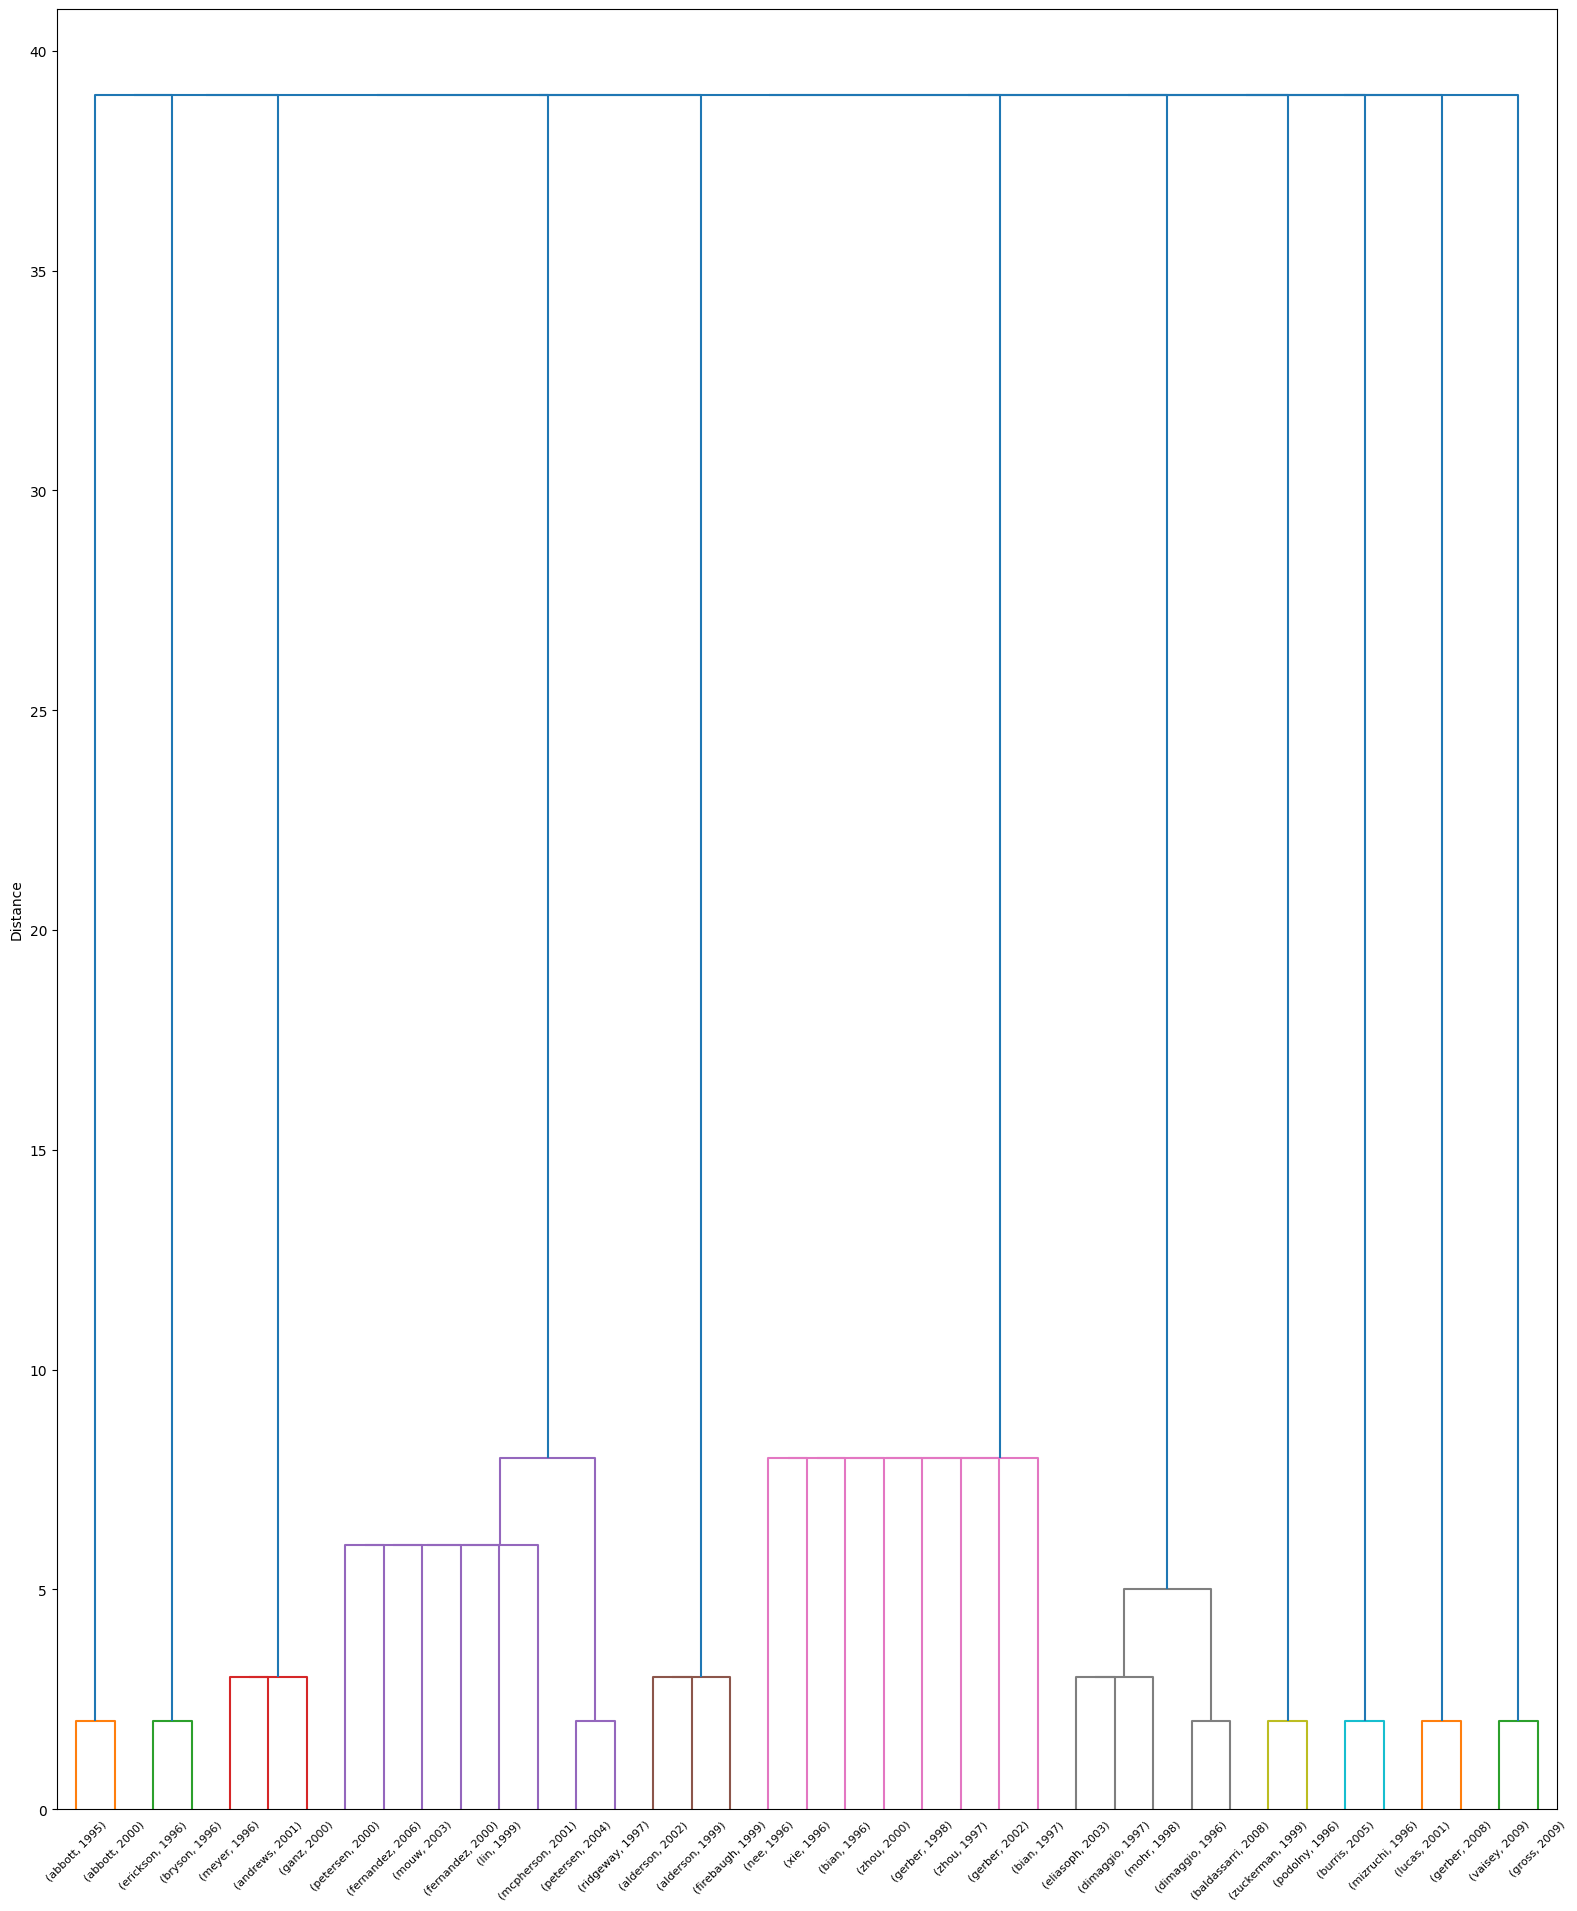

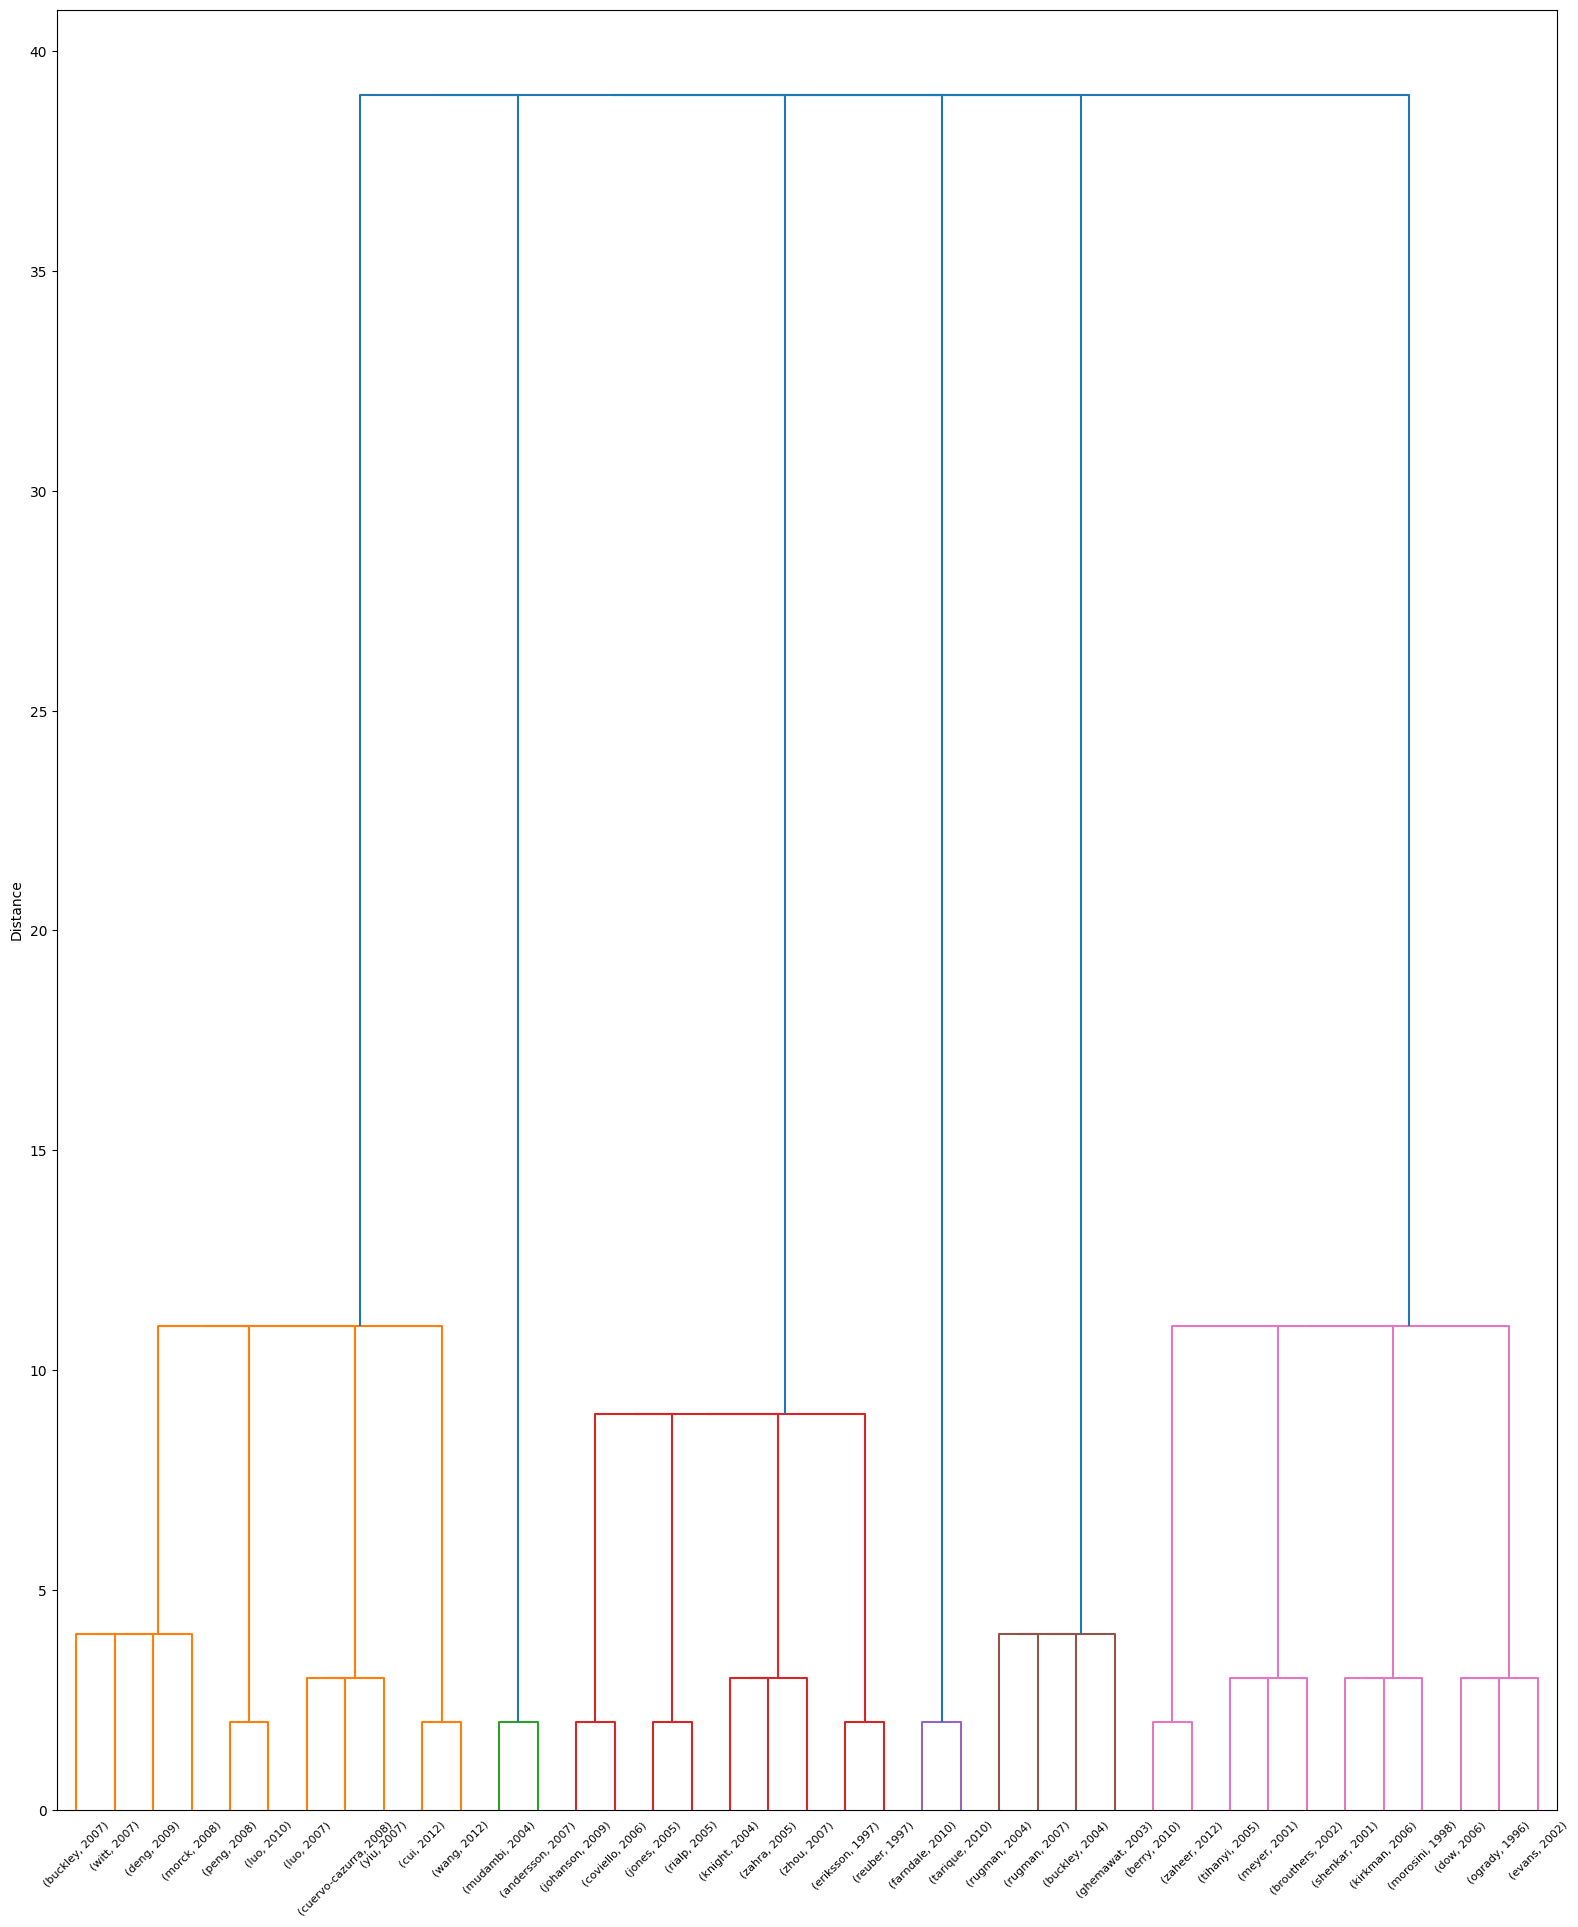

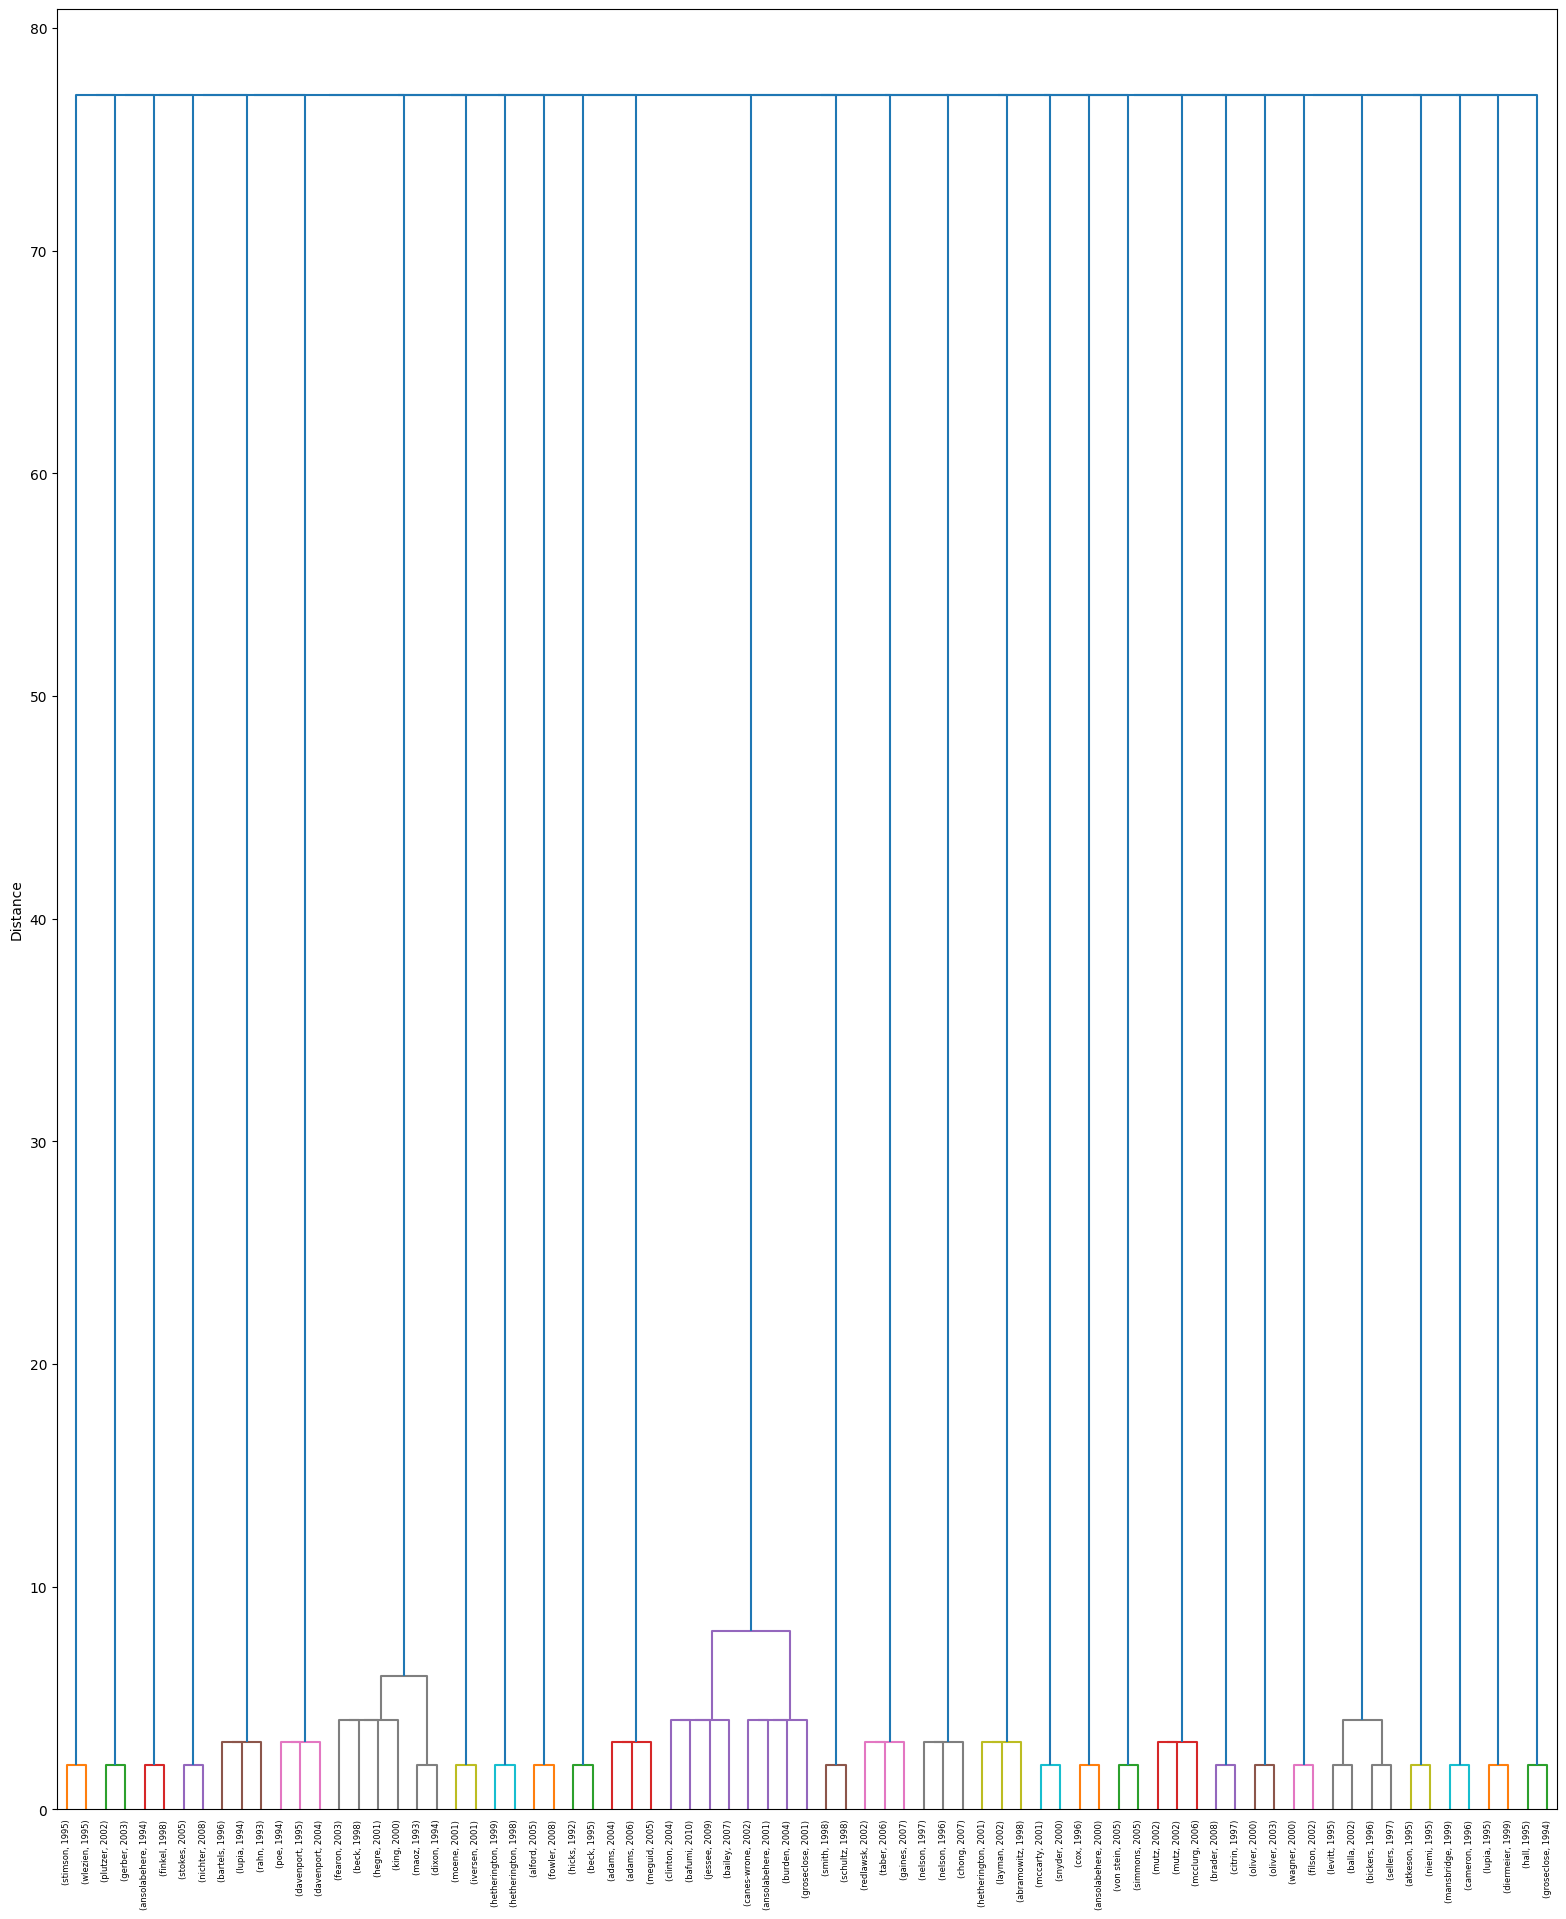

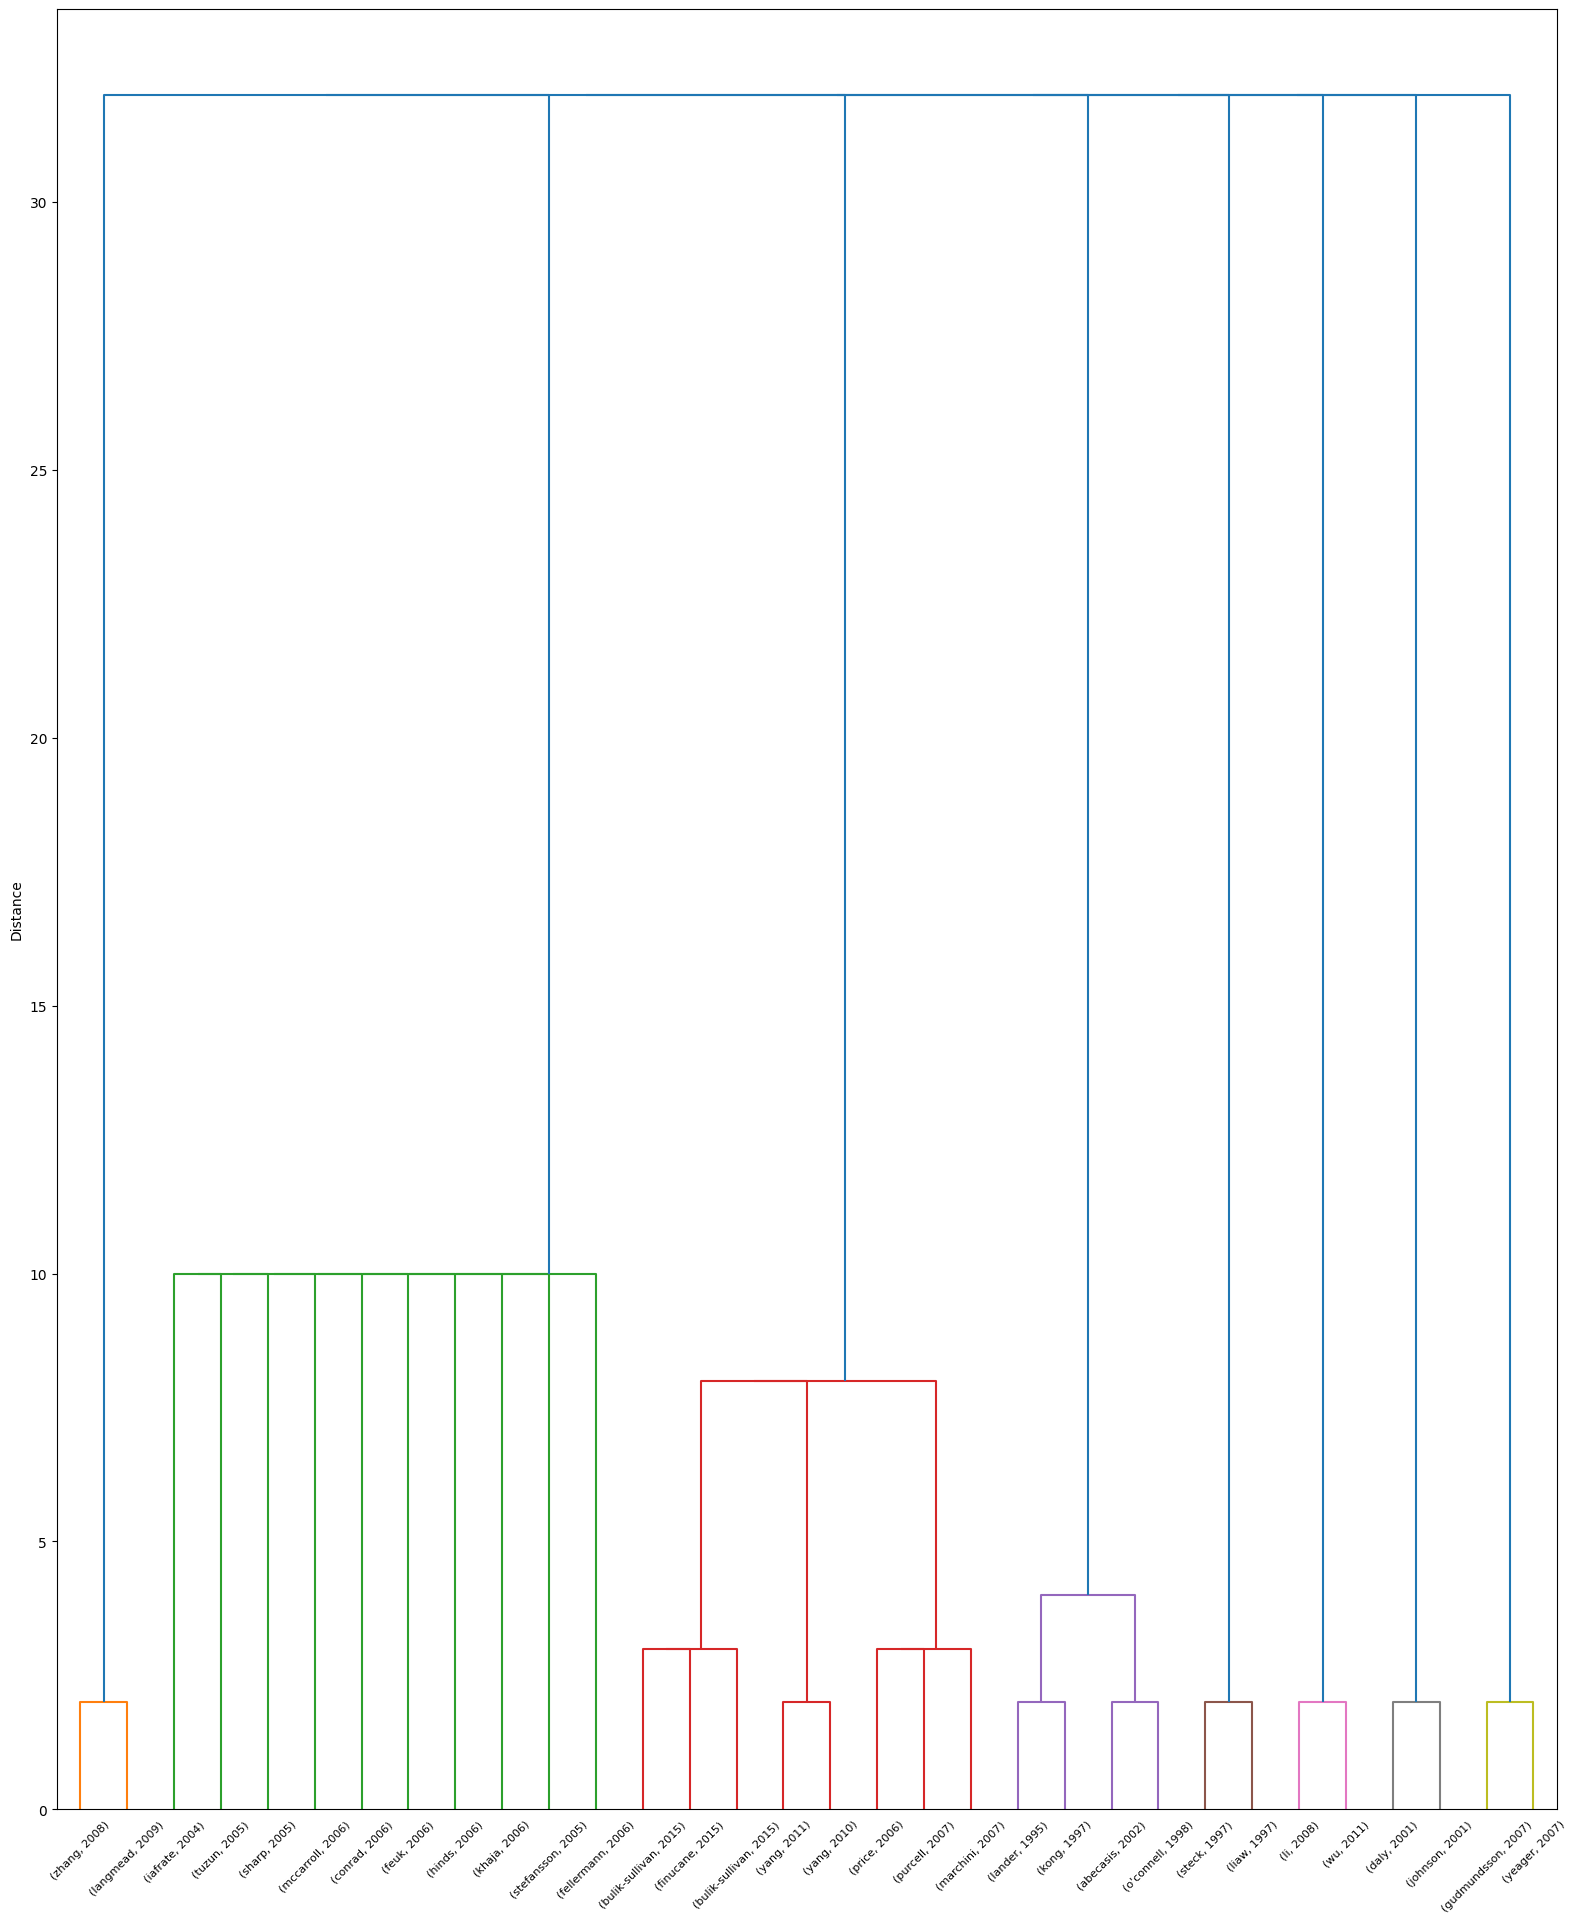

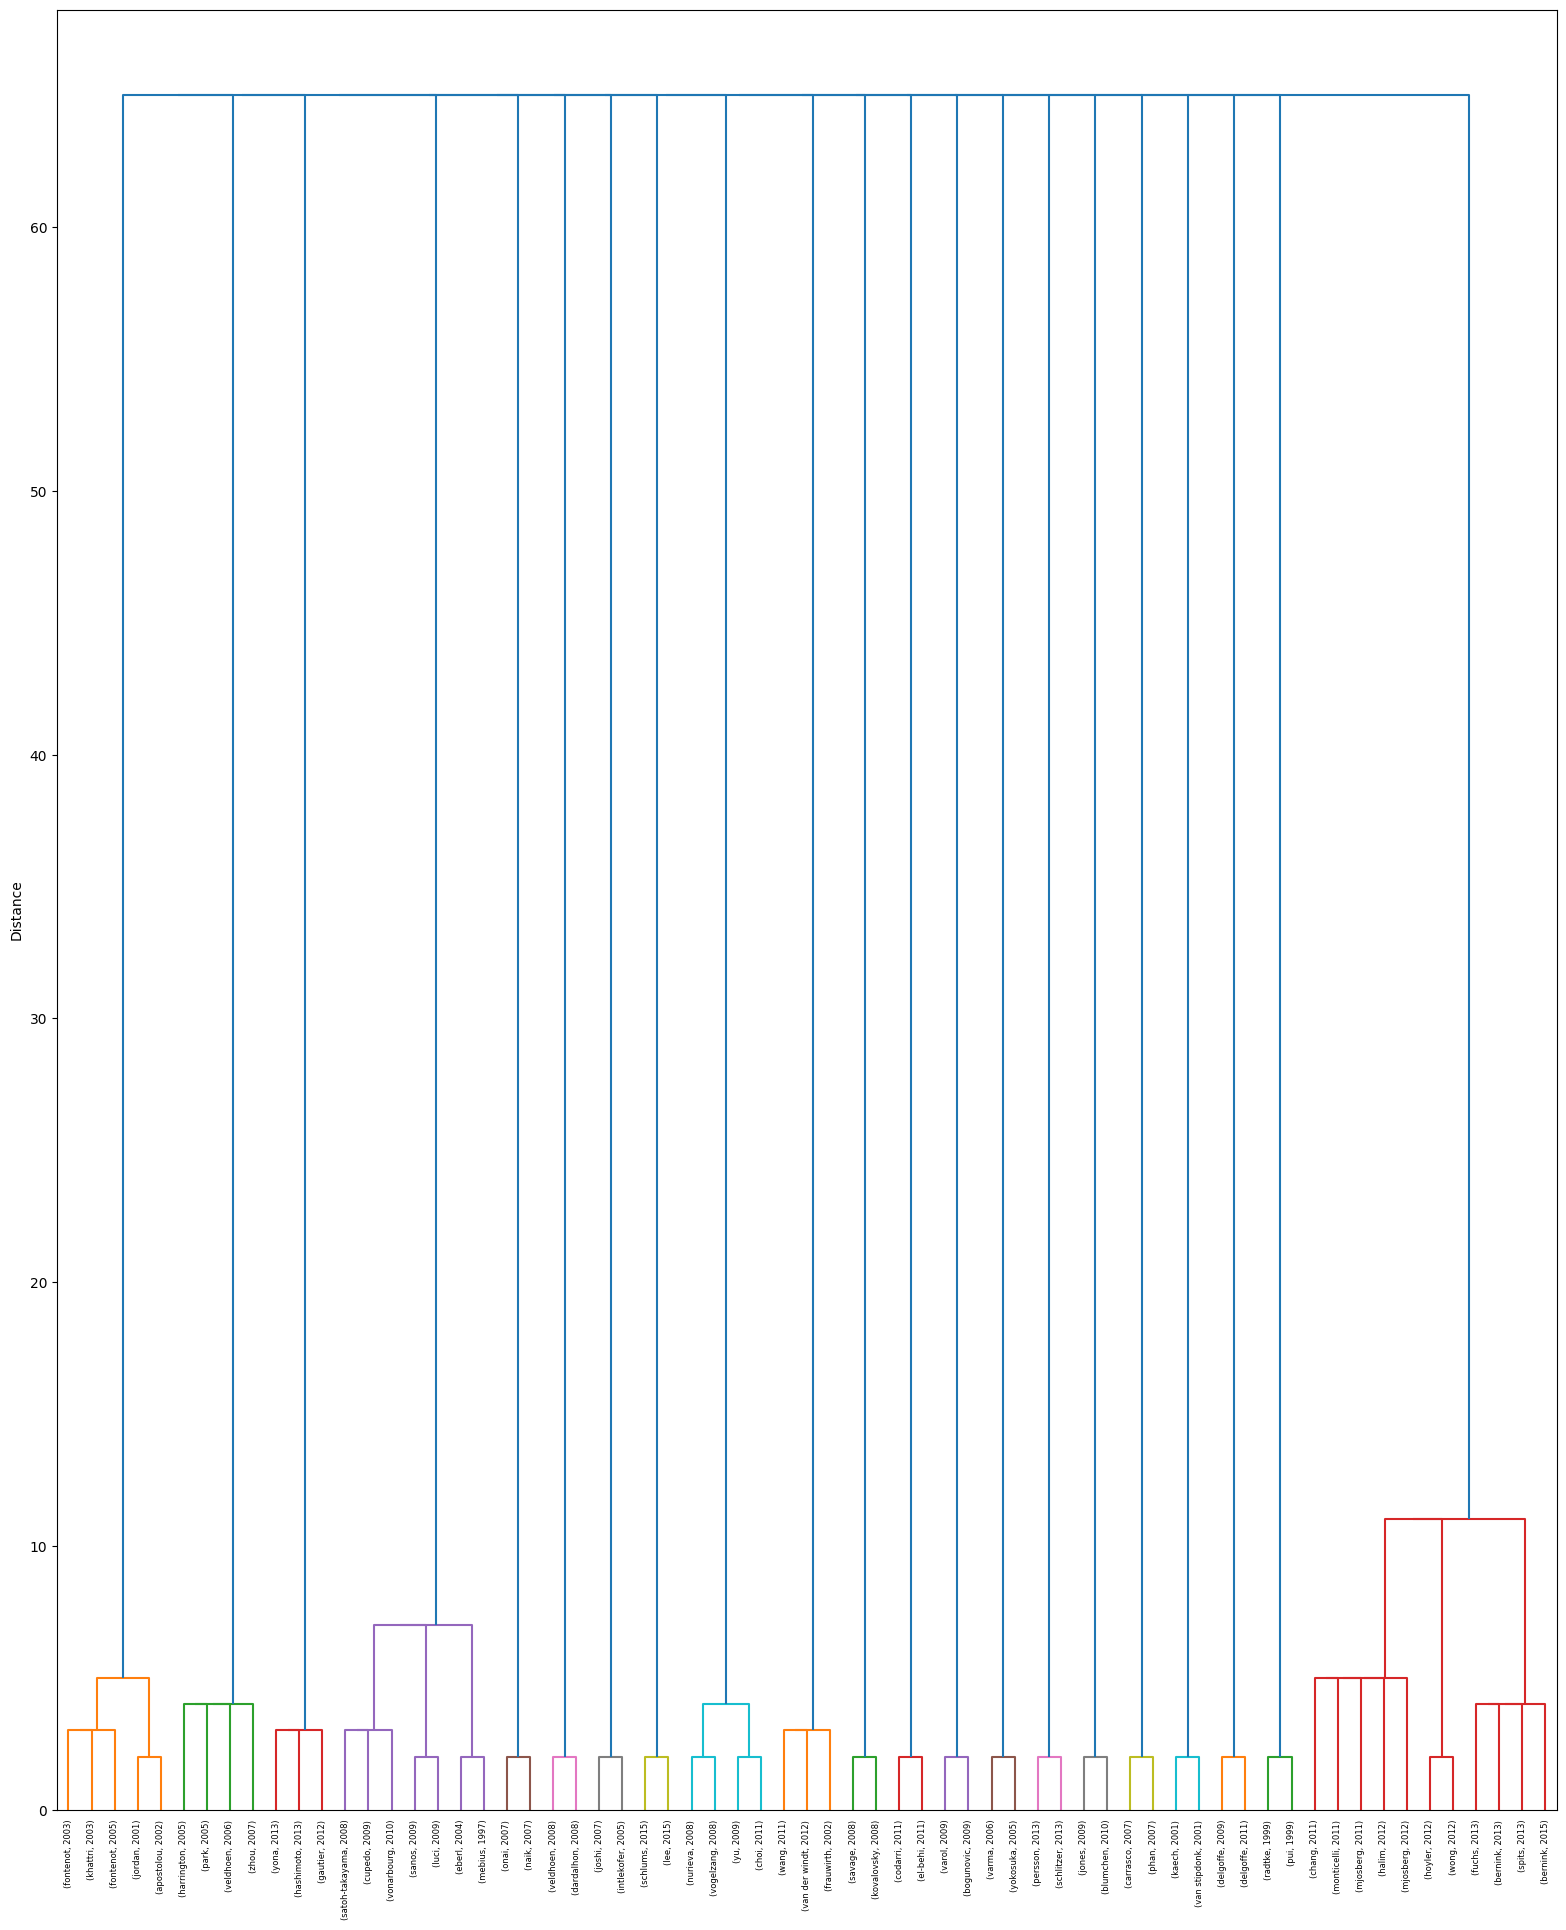

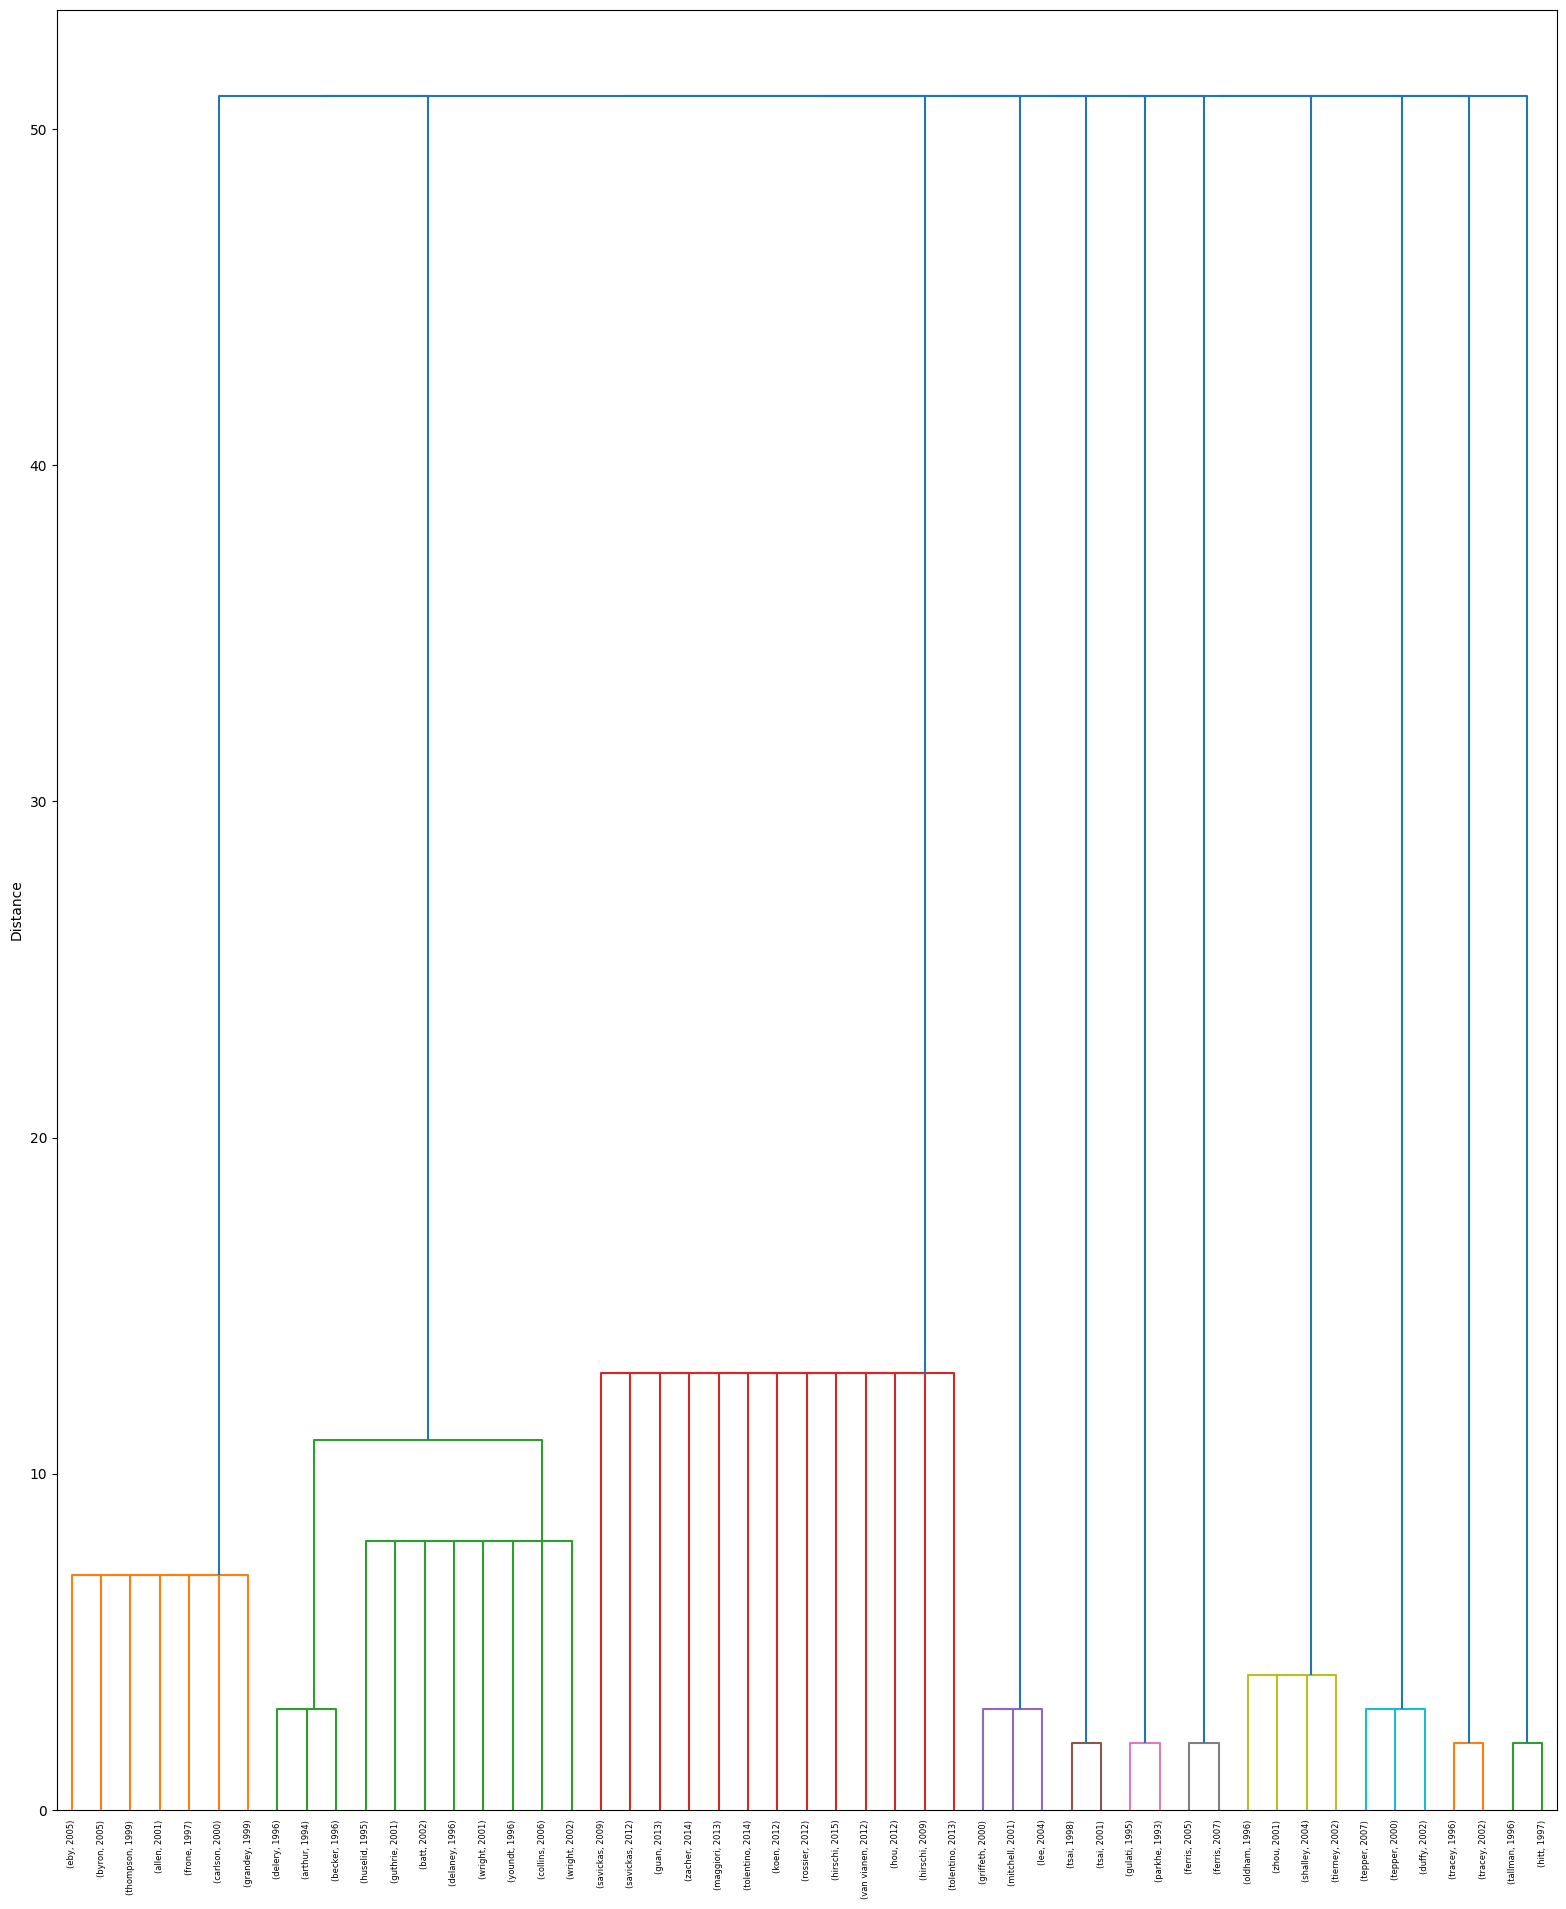

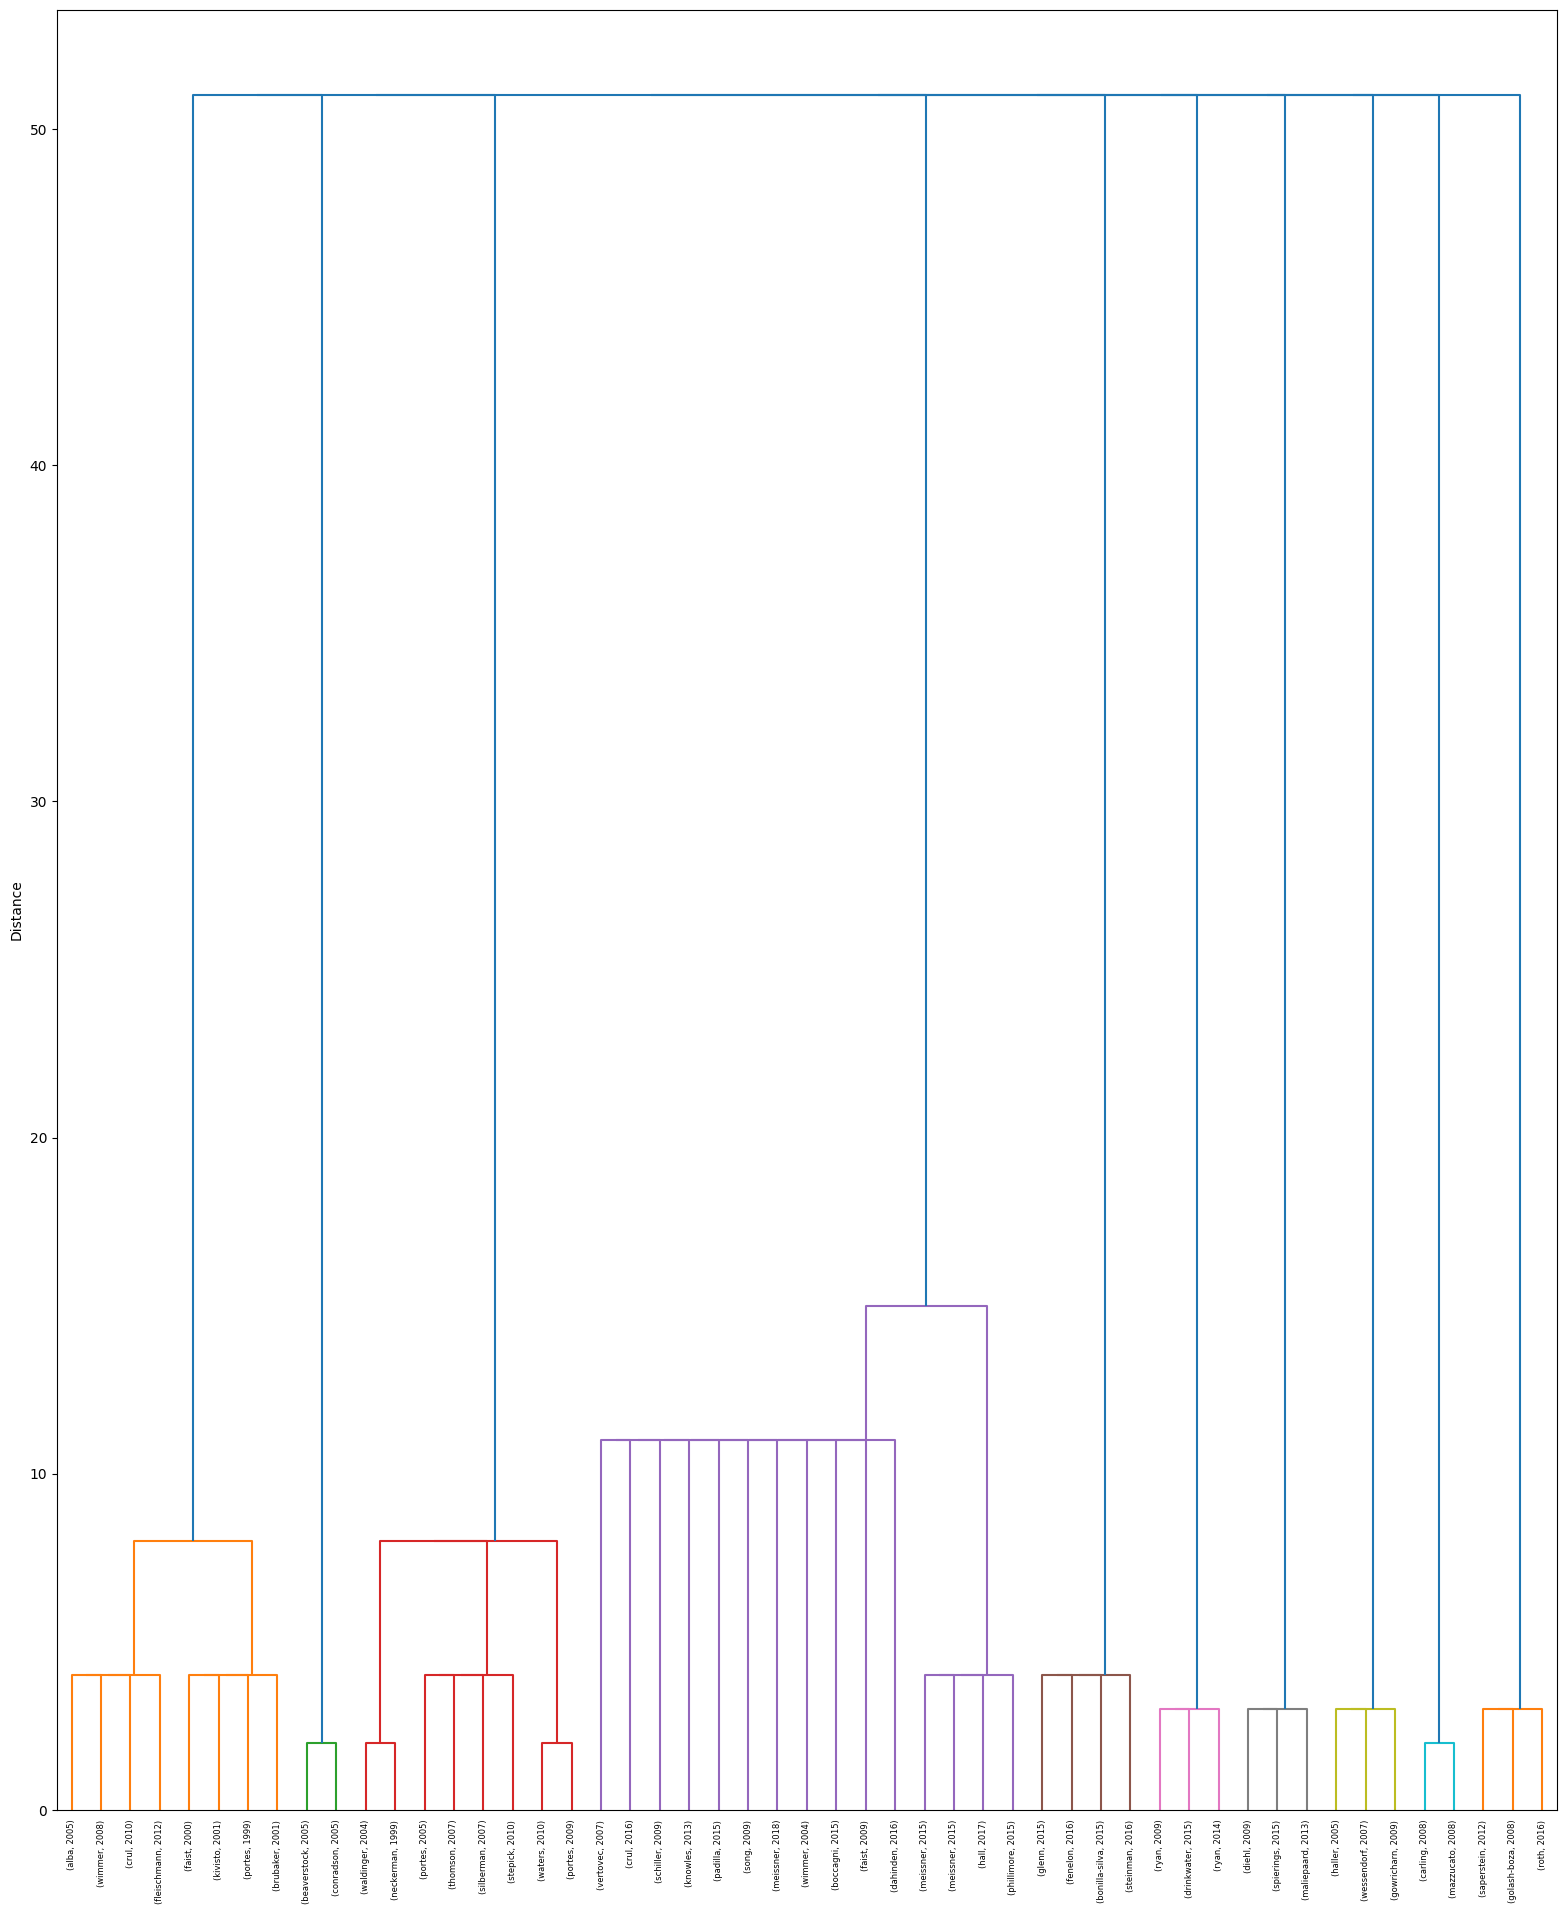

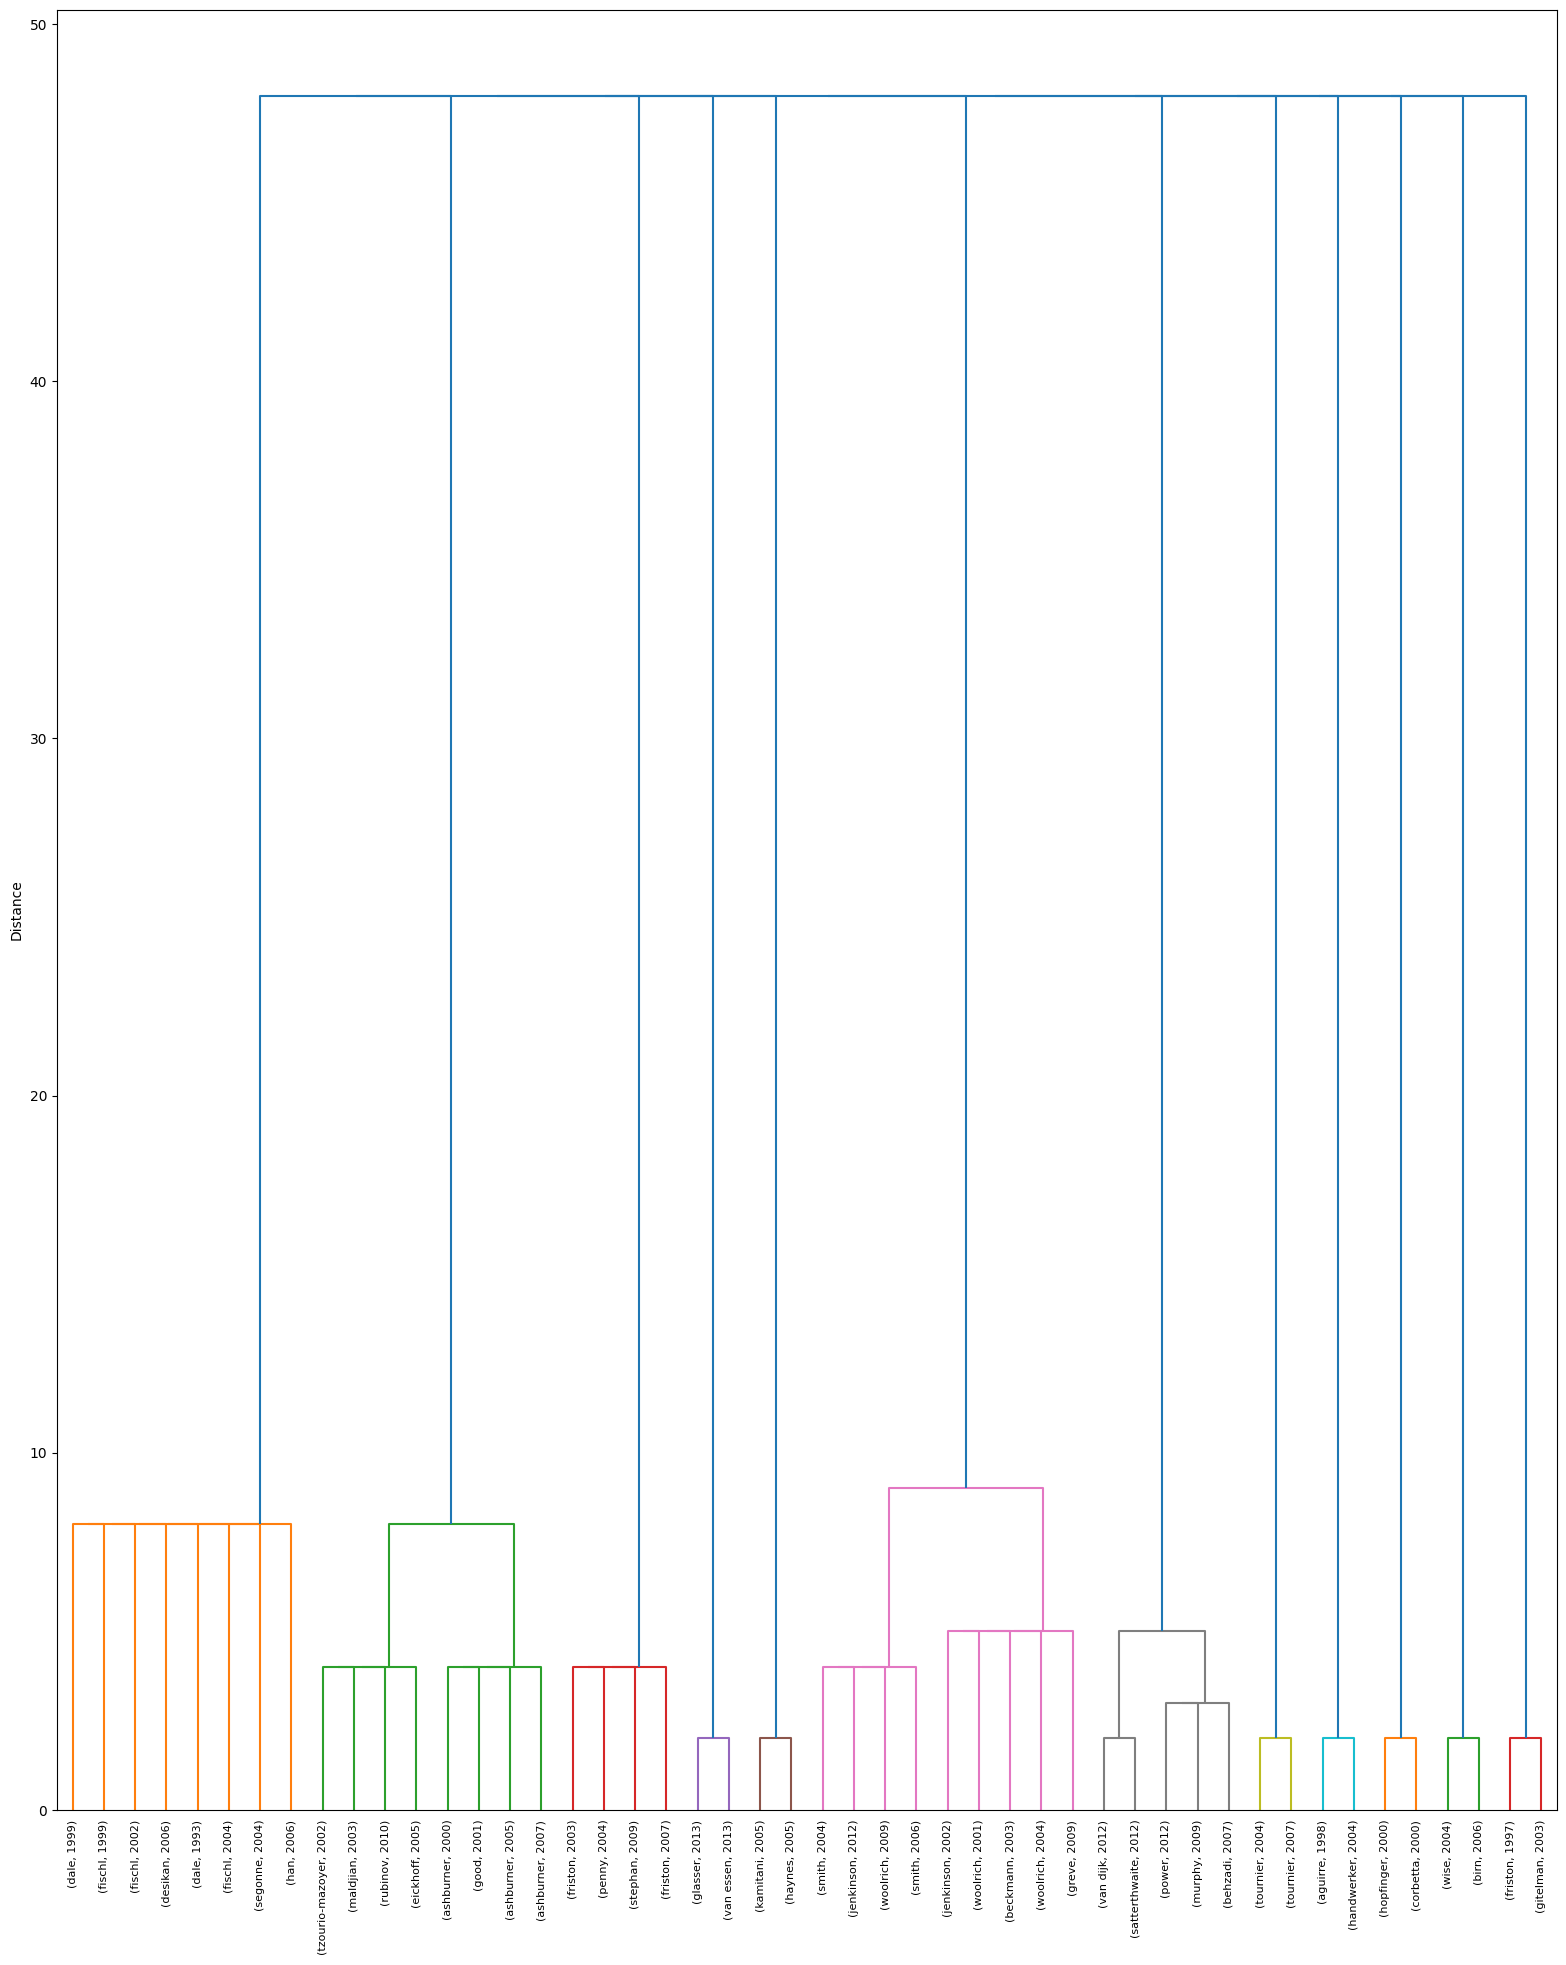

In [10]:


for (field_name, G) in Gs.items():

    print(field_name)

    nodes = list(G.nodes)
    
    comms = list(sorted(nx_comm.louvain_partitions(G, weight=None), key=len))
    comms.insert(0, (set(nodes),))
    comms.append(tuple({n} for n in nodes))

    Z, leaves = compute_Z(comms)

    new_leaves = dict(
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(leaves))
        .to_numpy()
    )

    leaves = dict(zip(leaves, leaves))
    leaves.update(new_leaves)


    fig = plt.figure(figsize=(15, 18))
    ax = fig.add_axes([0, 0, 1, 1])

    # ax.set_xlabel('Node')
    ax.set_ylabel('Distance')
    
    dendrogram(Z, labels=list(leaves.values()), ax=ax)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
    fig.tight_layout()

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_louvain_hier_comm', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=300,
        bbox_inches='tight'
    )
